# Parse Parameters

In [40]:
import configparser

confParser = configparser.ConfigParser()
confParser.read('config.ini')
confParser.sections()

['parameters',
 'python library path',
 'gnn library path',
 'flags',
 'Spline',
 'Local Order Analysis',
 'neighbor list',
 'modulus analysis',
 'ml flags',
 'props',
 'input files']

# import libraries

In [54]:
#--- system libraries
import sys
sys.path.append(confParser['python library path']['path'])
import pdb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import sys
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import patsy
import sklearn
from sklearn import linear_model, mixture
import sklearn.mixture as skm
from scipy import optimize
import scipy
import re
from scipy.stats import norm, kurtosis
from pandas.plotting import scatter_matrix
from scipy.ndimage import gaussian_filter
import time
from scipy import ndimage
from scipy.stats import chi2
from scipy.optimize import curve_fit
import functools as ftl

#from backports 
#
warnings.filterwarnings('ignore')
from sklearn.svm import LinearSVR, LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, SVR

#--- user modules
#from utility import *
import utility as utl
import LammpsPostProcess2nd as lp
import imp
imp.reload(lp)
imp.reload(utl)

#--- figure settings
if not eval(confParser['flags']['RemoteMachine']):
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
DFset=(0.18,0.17,0.15,0.06,0.05)
FontSize = 19

In [42]:
class Symbols:
    def __init__(self):
        self.colors = ['C0','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
        self.fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
        self.markers=['o','s','D','^','<','>','v']
        self.markersizes=[10,10,10,12,12,12,12]
        self.nmax=7
        
    def GetAttrs(self,count=0,label='',nevery=1,fmt='.-',zorder=1,linewidth=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':self.colors[count],
            'markeredgecolor':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':linewidth, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
             'zorder':zorder,
         }
        return attrs
    
    def GetAttrs2nd(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':'white',
#            'markeredgecolor':'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
            'zorder':zorder,
          }
        return attrs

class Legends:
    def __init__(self):
        pass
    def Set(self,fontsize=20,
                 labelspacing=0,
                 **kwargs
#                 bbox_to_anchor=(0.5,0.48,0.5,0.5),
           ):
        self.attrs = {'frameon':False,'fontsize':fontsize,
                   'labelspacing':labelspacing,
                      'handletextpad':.2,
                   'handlelength':1,
                    **kwargs
                     }
    def Get(self):
        return self.attrs
    
DRAW_FRAME=(0.23,0.08,0.12,0.07,0.1)


## class Temperature

In [43]:
class Temperature:
    
    def __init__(self,temp_range,nrun,verbose=False):
        self.temps =  temp_range
        self.nrun = nrun
        self.verbose = verbose
#         pdb.set_trace()
#        self.temps_runs = np.concatenate(list(map(lambda x:self.BuildTempRealizationPair([x[0]],np.arange(x[1])),
#            zip(self.temps,self.nrun))))

        self.temps_runs = np.concatenate(list(map(lambda x:self.BuildTempRealizationPair([x[0]],x[1]),
             zip(self.temps,self.nrun))))
        
    
    def BuildTempRealizationPair(self,temps,nrun):
        t,r=np.meshgrid(temps,nrun,indexing='ij')
        return np.array(list(zip(t.flatten(),r.flatten())))
        
    def ModifyNrun(self,dirs):
        #--- modify dirs
        count = -1
        dirs_copy = dirs[:]
        for _, indx in zip(self.temps,range(len(self.temps))):
            nrun_mod = self.nrun[indx][:]
            for y in self.nrun[indx]:
                count += 1
                x = dirs[count]
                if not os.path.isfile(x): #--- if false: remove file from "dirs"
                    dirs_copy.remove(x)
                    nrun_mod.remove(y)
            self.nrun[indx] = nrun_mod[:]

            assert len(self.nrun[indx]) > 0, 'temp = %s has no data!'%(self.temps[indx])
                
        self.temps_runs = np.concatenate(list(map(lambda x:self.BuildTempRealizationPair([x[0]],x[1]),
             zip(self.temps,self.nrun))))
        return dirs_copy
        
    def Parse(self,dirs,skip_rows=0):
            
        dirs = self.ModifyNrun(dirs)
#         print('dirs:',dirs)
        self.data=list(map(lambda x:np.loadtxt(x,ndmin=2, skiprows=skip_rows),dirs))
        if self.verbose:
            n = np.array(self.nrun).flatten()
            list(map(lambda x:print('Parsing: %s data.shape is: %s'%(x[1],x[0].shape)),zip(self.data,n)))
#        print('np.array(self.data):',np.array(self.data))

        
    def PlotScatter(self,shift = False, shift_factor=10,  
                    rescale=False,alpha=1.0,
                    mylegends='',
                    powerlaw=False, prefact=1.0,
                    markersizes=np.array([10,10,10,12,12,12,10])*8,
                    transparency=0.1,
                    addPoints = [],
                    colorIndex = [],
                    col_x=0,col_y=1,
                    **kwargs):
        self.ax = utl.PltErr(None,
                        None,
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=Symbols(markersizes=markersizes)
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5)
                   )
        kounts = colorIndex if colorIndex else range(len(self.temps)) 
        for temp, count in zip(self.temps,kounts): 
            text = mylegends[count] if not mylegends == '' else ' '
            #
            data = self.data_reduced[temp]            
            xdata = data[:,col_x]
            ydata = data[:,col_y]
            
            if powerlaw and count == 0:
                Xdata = xdata.copy()

            if rescale:
                ydata *= xdata ** alpha 

            ydata = ydata*shift_factor**count if shift else ydata

            self.ax.scatter(xdata,ydata,
                        **symbols.GetAttrsScatter(count=count%7,label='%s'%text,fmt='.',alpha=transparency),
                       )
        #--- add points
        for points in addPoints:
            utl.PltErr([points[0]],
                       [points[1]],
                       attrs={'fmt':'.','ms':10,'color':'red'},
                       ax=self.ax,
                       Plot=False,
                      )
            
        #
        attrs = {} if mylegends == '' else {'legend':legends.Get()}
        if powerlaw:
            Xdata.sort()
        utl.PltErr(Xdata if powerlaw else None,
                   prefact/Xdata**alpha if powerlaw else None,
                   ax=self.ax,
                   Plot=False,
                   DrawFrame=DRAW_FRAME,
                   **attrs,
                   **kwargs
                  )
        
    def Plot(self,**kwargs):
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5)
                   )
        xdata_column = 0 if 'xdata_column' not in kwargs else kwargs['xdata_column']
        ydata_column = 0 if 'ydata_column' not in kwargs else kwargs['ydata_column']
        for data, temp_run, count in zip(self.data,self.temps_runs,range(len(self.data))): 
            temp = temp_run[0]
            try:
                utl.PltErr(data[:,xdata_column],data[:,ydata_column],
#                       yerr=data[:,2],
                       ax = self.ax,
                       attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp),
                       Plot=False,
                      )
            except:
                continue
        #
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
                   DrawFrame=DRAW_FRAME,
#                 legend=legends.Get(),
                   **kwargs
                  )
        
    def PlotPdf(self,shift = False, shift_factor=10,
                rescale=False,alpha=1.0,
                powerlaw=False, prefact=1.0,
                mylegends='', 
                **kwargs):
        self.ax = utl.PltErr(None,
                        None,
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=utl.Symbols()
        legends = utl.Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5),
                    labelspacing=kwargs['labelspacing'] if 'labelspacing' in kwargs
                    else 0.0
                   )
        for temp, count in zip(self.temps,range(len(self.temps))): 
            text = mylegends[count] if not mylegends == '' else ' '
            #
            data = self.data_averaged[temp]
            xdata = data[ :,1 ]
            ydata = data[ :,0 ]
            yerr  = data[:,2]
            #
            if powerlaw and count == 0:
                Xdata = xdata.copy()
            if rescale:
                ydata *= xdata ** alpha 
                yerr *= xdata ** alpha 
                
            ydata = ydata * shift_factor**count if shift else ydata
            yerr  = yerr  * shift_factor**count if shift else yerr

            try:
                utl.PltErr(xdata,ydata,
                        yerr=yerr,
                       ax = self.ax,
                       attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%text,**kwargs),
                       Plot=False,
                   
                      )
            except:
                traceback.print_exc()
                continue
        #
        attrs = {} if mylegends == '' else {'legend':legends.Get()}
        attrs2 = {} if 'DrawFrame' in kwargs else {'DrawFrame':DRAW_FRAME}
        utl.PltErr(Xdata if powerlaw else None,
                   prefact/Xdata**alpha if powerlaw else None,
                   ax=self.ax,
                   Plot=False,
                   #DrawFrame=DRAW_FRAME,
                   **attrs2,
                   **attrs,
                   **kwargs
                  )
    def Concatenate(self):
        kount = 0
        self.data_reduced = {} 
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            nruns = len(self.nrun[indx])
            data = self.data[kount:kount+nruns]
            filtr = list(map(lambda x:x.shape[0] > 0,data)) #--- filter empty arrays
            self.data_reduced[temp] = np.concatenate(np.array(data)[filtr]) #,axis=0)
            if self.verbose:
                print('temp:%s, data.shape:%s'%(temp,self.data_reduced[temp].shape)) 
            kount += nruns

    def Transform(self,**kwargs):
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            if 'multBy' in kwargs:
                if 'col' in kwargs:
                    if 'temp' in kwargs and temp != kwargs['temp']:
                        continue
                    self.data_reduced[temp][:,kwargs['col']] *=  kwargs['multBy']

            if 'zscore' in kwargs and kwargs['zscore']:
                if 'col' in kwargs:
                    if 'temp' in kwargs and temp != kwargs['temp']:
                        continue
                    data = self.data_reduced[temp][:,kwargs['col']]
                    data -= np.mean(data)
                    data /= np.std(data)
                    self.data_reduced[temp][:,kwargs['col']] = data
                    
    def EnsAverage(self,logscale=False):
        kount = 0
        self.data_averaged = {} 
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            nruns = len(self.nrun[indx])
            if not logscale:
                data = self.data[kount:kount+nruns]
            else:
                data = [np.log10(item) for item in self.data[kount:kount+nruns]]

            if self.verbose:
                print('data.shape:',np.array(data).shape) 
#            filtr = list(map(lambda x:x.shape[0] > 0,data)) #--- filter empty arrays
#            data = np.concatenate(np.array(data)[filtr]) #,axis=0)
#            pdb.set_trace()
            data_reduced = ftl.reduce(Temperature.myadd,data)/nruns
    
#            pdb.set_trace()
            #--- std err
            std = [item**2 for item in data]
            std_reduced =ftl.reduce(Temperature.myadd,std) / nruns
            
            std_reduced -=  data_reduced**2
            std_reduced /= nruns
            if self.verbose:
                print('data_reduced=',data_reduced)
            self.data_averaged[ temp ] = np.c_[data_reduced,std_reduced[:,1]**0.5] #self.hist(data_reduced,nruns) #self.nrun[indx])
            if logscale:
                self.data_averaged[ temp ] = 10 ** self.data_averaged[ temp ]
            kount += nruns #self.nrun[indx]

    def hist(self,data,nrun):
        count, edge_left, edge_right, _ = data.T
        
        edge_left /= nrun
        edge_right /= nrun
        
        ntot = np.sum(count)
        
        edges = np.sqrt( edge_left * edge_right )
        
        hist = count / ntot / (edge_right-edge_left)
#        print(np.sum(hist*(edge_right-edge_left)))

        err = hist / count ** 0.5
        
        filtr = count > 1
        
        return np.c_[hist[filtr], edges[filtr], err[filtr]]
                    


    def func2nd(self,x,k,x0,xc,beta,alpha):
        return k*np.exp(-(x/xc)**beta)/(1+(x/x0)**alpha)

    def func(self,x,k,xc,beta,alpha):
        return k*np.exp(-(x/xc)**beta)/(x)**alpha

    def Fit(self,Plot=None,
            shift = False,
            plotAttrs={},
            bounds=(-np.inf, np.inf),
            xlo=float('-inf'),xhi=float('inf'),
            mylegends='',
            **kwargs):
        self.exponent = {}
        pref=1e-10*1e-10 #--- ang^2 to m^2
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=plotAttrs['bbox_to_anchor'] if 'bbox_to_anchor' in plotAttrs
                    else (1.0,0.5,0.5,0.5))

        if Plot:
            ax = utl.PltErr(None,None,
                            Plot=False)
        #
        for temp, count in zip(self.temps,range(len(self.temps))): 
            self.smat = smat = self.data_averaged[ temp ] #if len(self.nrun) > 1 else self.data[count]

            xdata = smat[ :,1 ]
            ydata = smat[ :,0 ]
            yerr  = smat[:,2]

        
            #--- set limits:
            if self.verbose:
                print('limits:',xlo,xhi)

            filtr = np.ones(xdata.shape[0],dtype=bool)
            filtr = np.all([filtr,xdata > xlo],axis=0)
            filtr = np.all([filtr,xdata <= xhi],axis=0)
            assert np.any(filtr), 'empty arrays!'
            if self.verbose:
                print('filtr=',filtr)
            
            #--- error in y
            if 'sigma' in kwargs:
                kwargs['sigma'] = 2*yerr[filtr]

            #--- fit
#             print(kwargs)
            popt, pcov = curve_fit(self.func, xdata[filtr], ydata[filtr],
                                   bounds=bounds, 
                                    **kwargs
                                    )
            self.popt = popt
            self.filtr = filtr
            #--- uncertainties
            if self.verbose:
                print('Temp=%s,y0,c0,alpha'%temp,list(popt),pcov)
            alpha=popt[-1]
            err_alpha = pcov[-1,-1]**0.5
            self.exponent[temp] = [alpha,alpha+err_alpha,alpha-err_alpha]
            if Plot:
                text = mylegends[count] if not mylegends == '' else ' '
                #---fit
                shift_factor = 100**count if shift else 1
                utl.PltErr(xdata,
                                (self.func(xdata,*popt))*shift_factor,#-y0)/xdata_shift,
                                attrs={'fmt':'-.','color':symbols.colors[count%7]},
                           Plot=False,ax=ax)
                #--- points
#                temp= [1000,1200,1400,1600,1800,2000][count]
                utl.PltErr(xdata,
                           ydata*shift_factor,#-y0)/xdata_shift,
                           yerr=yerr*shift_factor,#-y0),#/xdata_shift,
                           attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%text,fmt='.',**plotAttrs),
                           ax=ax,
                           Plot=False,
                          )
        if Plot:
            attrs = {} if mylegends == '' else {'legend':legends.Get()}
            utl.PltErr(None,
                       None, 
                       ax=ax,
                       Plot=False,
                       DrawFrame=DRAW_FRAME,
                       **plotAttrs,
                       **attrs
                      )

    def PlotDiff(self,**kwargs):
        symbols=utl.Symbols()
        utl.PltErr(1.0/np.array(self.temps),
                   list(map(lambda x:self.Diffusion[x][0],self.temps)),
                   yerr=list(map(lambda x:(self.Diffusion[x][1]-self.Diffusion[x][2])/2,self.temps)),
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )

    def PlotExponent(self,**kwargs):
        symbols=utl.Symbols()
        ax=utl.PltErr([0.5e-3,1e-3],[1,1],attrs={'fmt':'-.r'},Plot=False)
        utl.PltErr(1.0/np.array(self.temps),
                   list(map(lambda x:self.exponent[x][0],self.temps)),
                   yerr=list(map(lambda x:1.0*(self.exponent[x][1]-self.exponent[x][2]),self.temps)),
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   ax=ax,
                   **kwargs
                  )

    @staticmethod
    def myadd(a,b):
        return a+b
        



## Dump File

In [369]:
#--- parse lammps data
path = confParser['input files']['path']
indx = confParser['input files']['fileIndex']
fileName = confParser['input files']['filename'].split()[int(indx)]

#--- dump files
if eval(confParser['flags']['ReadDump']):
    print('parsing %s/%s'%(path,fileName))
    t0 = time.time()
    lmpData = lp.ReadDumpFile( '%s/%s'%(path,fileName ) ,verbose=False)
    lmpData.GetCords( ncount = sys.maxsize, 
    #                 columns = {'c_mystress[4]':'sxy'}, #--- multi-component glass
    #                 columns = {'c_mystress1':'sxx','c_mystress2':'syy','c_mystress3':'szz','c_mystress4':'sxy'},
    #                 columns = {'c_1[4]':'sxy'}, #--- cuzr
                    )
    print('duration=%s s'%(time.time()-t0))
    print('time steps:',lmpData.coord_atoms_broken.keys())
    print('ref. frame:')
    itime0=list(lmpData.coord_atoms_broken.keys())[0]
    print(lmpData.coord_atoms_broken[itime0].head())

parsing ../simulations/shear/glassCo5Cr2Fe40Mn27Ni26/age0/Run0/dumpSheared.xyz
duration=20.284202098846436 s
time steps: dict_keys([0, 20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 220000, 240000, 260000, 280000, 300000, 320000, 340000, 360000, 380000, 400000, 420000, 440000, 460000, 480000, 500000, 520000, 540000, 560000, 580000, 600000, 620000, 640000, 660000, 680000, 700000, 720000, 740000, 760000, 780000, 800000, 820000, 840000, 860000, 880000, 900000, 920000, 940000, 960000, 980000, 1000000, 1020000, 1040000, 1060000, 1080000, 1100000, 1120000, 1140000, 1160000, 1180000, 1200000, 1220000, 1240000, 1260000, 1280000, 1300000, 1320000, 1340000, 1360000, 1380000, 1400000, 1420000, 1440000, 1460000, 1480000, 1500000, 1520000, 1540000, 1560000, 1580000, 1600000, 1620000, 1640000, 1660000, 1680000, 1700000, 1720000, 1740000, 1760000, 1780000, 1800000, 1820000, 1840000, 1860000, 1880000, 1900000, 1920000, 1940000, 1960000, 1980000, 2000000])
ref. frame:
   id

In [370]:
def AddRndStrs(df):
    df['z']=np.zeros(len(df))

if eval(confParser['parameters']['dimension'])==2:

    #--- add z
    list( map(lambda x:AddRndStrs(lmpData.coord_atoms_broken[x]),lmpData.coord_atoms_broken.keys()) )


In [371]:
#--- write ovito input
OVITO = False
if OVITO:
    !mkdir dumpFiles
    !rm dumpFiles/grains_mapped.dump dumpFiles/grains.dump
    keys = list(lmpData.coord_atoms_broken.keys())
    keys.sort()
    box0=lp.Box(BoxBounds=lmpData.BoxBounds[keys[0]])
    sfile=open('dumpFiles/grains_mapped.dump','a')
    sfile0=open('dumpFiles/grains.dump','a')
    for key in keys:
        atoms = lp.Atoms(**lmpData.coord_atoms_broken[key].to_dict(orient='series'))
        box=lp.Box(BoxBounds=lmpData.BoxBounds[key])
        
        #--- bare cords      
        wd0 = lp.WriteDumpFile(atoms, box)
        wd0.Write(sfile0, 
                itime=key,
                attrs=['id', 'type', 'x', 'y', 'radius'], 
                fmt = '%i %i %6.5e %6.5e %f' )
                    
                    
        #--- wrap coordinates
        wrap = lp.Wrap( atoms, box )
        wrap.WrapCoord()
        wrap.Set( atoms ) #--- atoms: set wrapped xyz     


        #--- map to square box
        mapp = lp.Map( atoms, box ) 
        mapp.ChangeBasis()
        mapp.Set( atoms ) #--- atoms: add mapped xyz

        #--- print
        atoms.x=atoms.xm
        atoms.y=atoms.ym
    
    
        wd = lp.WriteDumpFile(atoms, box0)
        wd.Write(sfile, 
                 itime=key,
                 attrs=['id', 'type', 'x', 'y', 'radius'], 
                 fmt = '%i %i %6.5e %6.5e %f' )
    sfile.close()
    sfile0.close()


In [372]:
def GetStrainn(box0,box ):
    ebulk = {}
    #--- bulk strain
    dx=box.CellVector[0,1]-box0.CellVector[0,1]
    l1=box.CellVector[1,1]
    ebulk = dx/l1
    return ebulk




# stress-strain curve

In [373]:
!mkdir loadCurve

mkdir: cannot create directory ‘loadCurve’: File exists


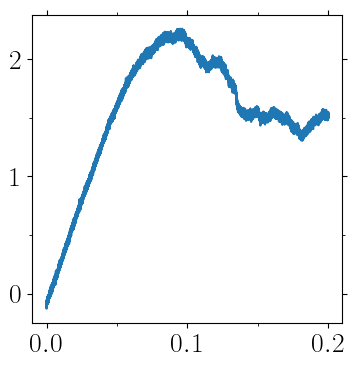

In [374]:
path = confParser['input files']['path']
indx = confParser['input files']['fileIndex']
fileNamee = confParser['input files']['filenamee'].split()[int(indx)]
latexx = eval(confParser['flags']['RemoteMachine']) == False
legend = Legends()
legend.Set()
try:
    stress = np.loadtxt('%s/%s'%(path,fileNamee),skiprows=1 ) #--- stress input file
    times  = stress[:,1]
    strain = stress[:,2]
    Virial = stress[:,6]
#         if fileNamee == 'look':
#             strain = stress[:,2]
#             Virial = -stress[:,6]

    ax=utl.PltErr(strain,Virial,
           yerr=None,
           attrs={'fmt':'-','label':'annealed'},
    #      ylim=[0,5],
           xstr=r'$\gamma_{xy}$' if latexx else '',
           ystr=r'$\sigma_{xy}$' if latexx else '',#'(Gpa)',
           title='loadCurve/stress_strain.png',
                Plot=False,
          )
    #
    np.savetxt('loadCurve/%s'%fileNamee,np.c_[np.array(strain), Virial],header='gamma\tsigma')
except:
    traceback.print_exc()
    confParser.set('flags','ReadStrsFromDump','True')
        
#

## multiple systems

In [375]:
def main():

    if eval(confParser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    #--- temp object
    temp = Temperature(
        [0,1,2,3,4,5,9],[list(range(1))]*10,
#        [5],[[0]]*10,
#         verbose = True,
                     )
    #
    #--- parse data
    temp.Parse( list(map(lambda x:'../simulations/shear/glassCo5Cr2Fe40Mn27Ni26/age%s/Run%s/thermo-shear.txt'%(x[0],x[1]),
                        temp.temps_runs )),
               skip_rows=1,
             )
    #
    #--- plot
    print('single realizations')
    dump_every=100;nevery=100;dt=1e-3;factor=dump_every*nevery*dt
    #
    symbols=Symbols()
    #
    legend=Legends()
    legend.Set(fontsize=16,
               bbox_to_anchor=(.53,0.44,0.5,0.5),
              )
    ax = utl.PltErr(None,None,Plot=False,attrs={})
    xdata_column=2;ydata_column=6
    for age, indx in zip(temp.temps,range(len(temp.temps))):
        xdata = temp.data[indx][:,xdata_column]
        ydata = temp.data[indx][:,ydata_column]
        utl.PltErr(xdata,ydata,
                  attrs=symbols.GetAttrs(count=indx%7,nevery=20000,label=r'$%d$'%(age*factor),linewidth=0.1),
                   ax=ax,
                   Plot=False,
                  )

    utl.PltErr(None,None, attrs={},
#                xstr=r'$\gamma_{xy}$',
#                ystr=r'$\sigma_{xy}$(Gpa)',
               ax=ax,
               legend=legend.Get(),
               title = 'png/stress_strain_age.png',
               Plot=False,
               ylim=(-0.1,4),
              DrawFrame=DRAW_FRAME,
              )
    
    return temp
temp = main()

## swap rate

In [376]:
def main():

    if eval(confParser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    #--- temp object
    temp = Temperature(
        [0],[[0]],
#         verbose = True,
                     )
    #
    #--- parse data
#    temp.Parse(['./msd/msd.txt'])
    temp.Parse( list(map(lambda x:'../simulations/annealing/glassCo5Cr2Fe40Mn27Ni26/Run%s/thermo_swap.txt'%(x[1]),
                        temp.temps_runs )),
               skip_rows=1,
             )
    #
    #--- plot
    print('single realizations')
    transform = True
#    dump_every=100;nevery=100;dt=1e-3;factor=dump_every*nevery*dt
    legend=Legends()
    legend.Set(bbox_to_anchor=(.9,0.48,0.5,0.5))
    ax = utl.PltErr(None,None,Plot=False)
    xdata_column=1;ydata_column=4
    for age, indx in zip(temp.temps,range(len(temp.temps))):
        xdata = temp.data[indx][:,xdata_column]
        ydata = temp.data[indx][:,ydata_column]
        if transform:
            ydata = np.gradient(ydata,xdata)
        utl.PltErr(xdata,ydata,
                  attrs={'fmt':'-','color':'C0'},#,'label':r'$%2.1f$'%(age*factor)},
                   ax=ax,
                   Plot=False,
                  )

    xdata = temp.data[indx][:,xdata_column]
    ydata = temp.data[indx][:,ydata_column+1]
    if transform:
        ydata = np.gradient(ydata,xdata)
    utl.PltErr(xdata[2:],ydata[2:],
               attrs={'fmt':'-','color':'red'},
                xstr=r'$t_\mathrm{age}$(ps)',
                ystr=r'$\mathrm{swap~rate~(per~ps)}$', #r'$V(\r{A}^3)$',
               ax=ax,
               yscale='log',
#               legend=legend.Get(),
               title = 'png/swap_rate_age.png',
               Plot=False)
    
    return temp
temp = main()

## find stress peak and corresponding strain
### Fit a spline

### test error vs. complexity

In [377]:
def Validate(x,y,deg_f=range(0,40,10),cv_samples=10):
    mse={}
    for df in deg_f:
    #    for df in map(int,np.logspace(0,12,20,base=2,endpoint=True)):
        try:
            transfrm = utl.ReturnShapeFunc(x,df)
            reg = utl.TrainModel(transfrm,y)
            #--- vadidate    
            scores = cross_validate(reg,  transfrm, y, cv=cv_samples,
                                         scoring=('r2', 'neg_mean_squared_error'),
                                         return_train_score=True)
            mse[df] = np.mean(scores['train_neg_mean_squared_error'])
        except:
            traceback.print_exc()
            continue
    return mse

# if eval(confParser['flags']['FitSpline']):
#     x, y = np.array(strain), np.array(Virial)
#     mse = Validate(x,np.c_[y],deg_f=np.logspace(2,13,num=12,base=2,dtype=int))
#     keys=mse.keys()
#     utl.PltErr(keys, [-mse[key] for key in keys],
#               xscale='log',yscale='log',
#               title='loadCurve/mse.png'
#               )


In [378]:
latexx = eval(confParser['flags']['RemoteMachine']) == False

if eval(confParser['flags']['FitSpline']):
    

    x, y = np.array(strain), np.array(Virial)
    #--- training points
    deg_f = eval(confParser['Spline']['deg_f']) #--- pick the spline degree based on the mse curve
    transfrm = utl.ReturnShapeFunc(x,deg_f) #13)

    #--- train
    reg = utl.TrainModel(transfrm,np.c_[y])

    #--- prediction
    y_pred = reg.predict( transfrm )


    #--- validate
    #mse = Validate(reg, strain,np.c_[y])

    #--- yield stress
    try:
        (ey,sy), (em,sm,dsm), (ef,sf), gmodu = utl.YieldStress(x,y_pred)
    except:
        (ey,sy), (em,sm,dsm), (ef,sf), gmodu = utl.YieldStress2nd(x,y_pred)

    #--- write on the disk
    np.savetxt('loadCurve/NegativeModulus.txt',np.c_[em,-dsm],header='Strain\tModulus')
    np.savetxt('loadCurve/ShearModulus.txt',np.c_[0,gmodu],header='Strain\tModulus')

    #--- Plot
    attrs={ 'alpha':0.5,
            'fmt':'x',
            'markersize':4,
            'color':'C0',
             'markerfacecolor':'white',
             'markeredgecolor':'black',
             'markevery':int(len(x)/128),

          }
#    ax=None   
    kwargs = {
            'borderwidth' : 0.1,
    #       'xlim':(0,0.2),
    #       'ylim':(0,2.5),
            'title':'loadCurve/hminIllustration.png',
             }
    #
    ax = utl.PltErr(x,y, 
           yerr=None, 
           attrs = attrs,
           Plot = False,
           xstr=r'$\gamma$' if latexx else '',
           ystr=r'$\sigma$(Gpa)' if latexx else '',
          )
    #
    utl.PltErr(x,y_pred, 
           yerr=None, 
           attrs = {'fmt':'-.r'},
           Plot = False,
           ax = ax,
           **kwargs
          )
#     if eval(confParser['flags']['AssignYieldTime']):
    utl.PltErr([ey,ey], [ax.axis()[2],sy], 
           yerr=None, 
           attrs = {'fmt':'-.r'},
           Plot = False,
           ax = ax,
           **kwargs
          )    
#    elif eval(confParser['flags']['AssignMaxDropTime']):
    utl.PltErr(em, sm, 
           yerr=None, 
           attrs = {'fmt':'s','color':'black','markersize':8},
           Plot = False,
           ax = ax,
           **kwargs
          )    
#    elif eval(confParser['flags']['AssignFlowTime']):
    utl.PltErr([ef,ef], [ax.axis()[2],sf], 
           yerr=None, 
           attrs = {'fmt':'-.r'},
           Plot = False,
           ax = ax,
           xlim=(0.6*ey,1.3*ef),
           ylim=(0.7*sf,1.1*sy),
           **kwargs
          )    


In [379]:
if not eval(confParser['flags']['RemoteMachine']):
    #--- Plot
    attrs={ #'alpha':0.5,
            'fmt':'-',
    #        'markersize':4,
            'color':'C0',
             'markerfacecolor':'white',
             'markeredgecolor':'black',
             'markevery':int(len(x)/128),
             'linewidth':3,

          }
    ax=None   
    kwargs = {
           'DrawFrame':(0.17,0.17,0.15,0.06,0.1),
#           'xlim':(-0.01,0.21),
#           'ylim':(-0.5,2.5),
            'title':'loadCurve/loadCurve2nd.png',
             }
    #
    ax = utl.PltErr(x,y, 
           yerr=None, 
           attrs = attrs,
           Plot = False,
           xstr='',#r'$\gamma$',
           ystr='',#r'$\sigma$(Gpa)',
#           xlim=(-0.01,0.21),
#           ylim=(-0.5,2.5),
          )
    #
    utl.PltErr([0.05,ey,em], [y[x>=0.05][0],sy,sm]
           , 
           yerr=None, 
           attrs = {'fmt':'s','color':'black','markersize':10,
                    'markerfacecolor':'white',
                    'markeredgecolor':'black'},
           Plot = True,
           ax = ax,
           **kwargs
          )

In [380]:
if eval(confParser['flags']['FitSpline']):
#     times = lmpData.coord_atoms_broken.keys()
#     times = np.array(sorted(times))
    strainDump=strain #list(map(lambda x:GetStrainn(lp.Box(BoxBounds=lmpData.BoxBounds[times[0]]),
#                                             lp.Box(BoxBounds=lmpData.BoxBounds[x])),times))
    if eval(confParser['flags']['AssignYieldTime']):
        itime = times[strainDump>=ey][0]
        print('itime(peak)=%s'%itime)    
    elif eval(confParser['flags']['AssignMaxDropTime']):
        itime = times[strainDump>=em][0]
        print('itime(max. drop)=%s'%itime)
    elif eval(confParser['flags']['AssignFlowTime']):
        itime = times[strainDump>=ef][0]
        print('itime(flow)=%s'%itime)

    #--- set parameter
    #confParser.set('parameters','itime',value='%s'%itime)


### drop vs. age

In [381]:
def main():

    if eval(confParser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    #--- temp object
    temp = Temperature(
        [0,1,2,3,4,5,6,7,8,9],[[0,1,2]]*10,
#        [0,9],[list(range(3))]*10,
#         verbose = True,
                     )
    #
    #--- parse data
    temp.Parse( list(map(lambda x:'shear/glassCo5Cr2Fe40Mn27Ni26/age%s/Run%s/loadCurve/NegativeModulus.txt'%(x[0],x[1]),
                        temp.temps_runs )),
               skip_rows=1,
             )
    #
    #--- scatter plot
    print('single realizations')
    dump_every=100;nevery=100;dt=1e-3;factor=dump_every*nevery*dt
    #
    symbols=Symbols()
    #
    legend=Legends()
    legend.Set(fontsize=16,
               bbox_to_anchor=(.7,0.4,0.5,0.5),
              )
    ax = utl.PltErr(None,None,Plot=False,attrs={})
    xdata_column=0;ydata_column=1
    counter = 0
    for item in temp.temps_runs:
        age  = item[0]
        irun = item[1]
        xdata = age*factor #temp.data[indx][:,xdata_column]
        ydata = temp.data[counter][:,ydata_column]
        utl.PltErr(xdata,ydata,
                  attrs=symbols.GetAttrs(count=0,nevery=20000,label=r'$%d$'%(age*factor),linewidth=0.1),
                   ax=ax,
                   Plot=False,
                  )
        counter += 1
    utl.PltErr(None,None, attrs={},
#               yscale='log',
#                xstr=r'$\gamma_{xy}$',
#                ystr=r'$\sigma_{xy}$(Gpa)',
               ax=ax,
#               legend=legend.Get(),
#               title = 'png/stress_strain_age.png',
               Plot=False,
#               ylim=(-0.1,4),
              DrawFrame=DRAW_FRAME,
              )
    
    
    
    #--- average
    temp.EnsAverage(logscale=False)
    ax = utl.PltErr(None,None,Plot=False,attrs={})
    xdata_column=0;ydata_column=1
    counter = 0
    for item in temp.data_averaged:
        age  = item
        xdata = age*factor #temp.data[indx][:,xdata_column]
        ydata = temp.data_averaged[item][:,ydata_column]
        yerr = 2*temp.data_averaged[item][:,2]
        utl.PltErr(xdata,ydata,yerr=yerr,
                  attrs=symbols.GetAttrs(count=0,nevery=20000,label=r'$%d$'%(age*factor),linewidth=0.1),
                   ax=ax,
                   Plot=False,
                  )
        counter += 1
    utl.PltErr(None,None, attrs={},
#               yscale='log',
#                xstr=r'$\gamma_{xy}$',
#                ystr=r'$\sigma_{xy}$(Gpa)',
               ax=ax,
#               legend=legend.Get(),
               title = 'png/stressDrop_age.png',
               Plot=False,
               xlim=(-2,100),
              DrawFrame=DRAW_FRAME,
              )
    
    
    
    return temp
temp = main()

In [382]:
def main():

    if eval(confParser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    #--- temp object
    temp = Temperature(
        [0,1,2,3,4,5,6,7,8,9],[[0,1,2]]*10,
#        [0,9],[list(range(3))]*10,
#         verbose = True,
                     )
    #
    #--- parse data
    temp.Parse( list(map(lambda x:'hmodu/glassCo5Cr2Fe40Mn27Ni26/age%s/df1/Run%s/loadCurve/NegativeModulus.txt'%(x[0],x[1]),
                        temp.temps_runs )),
               skip_rows=1,
             )
    #
    #--- scatter plot
    print('single realizations')
    dump_every=100;nevery=100;dt=1e-3;factor=dump_every*nevery*dt
    #
    symbols=Symbols()
    #
    legend=Legends()
    legend.Set(fontsize=16,
               bbox_to_anchor=(.7,0.4,0.5,0.5),
              )

    
    
    #--- average
    temp.EnsAverage(logscale=False)
    ax = utl.PltErr(None,None,Plot=False,attrs={})
    xdata_column=0;ydata_column=1
    counter = 0
    for item in temp.data_averaged:
        age  = item
        xdata = age*factor #temp.data[indx][:,xdata_column]
        ydata = temp.data_averaged[item][:,ydata_column]
        yerr = temp.data_averaged[item][:,2]
        utl.PltErr(xdata,ydata,yerr=yerr,
                  attrs=symbols.GetAttrs(count=0,nevery=20000,label=r'$%d$'%(age*factor),linewidth=0.1),
                   ax=ax,
                   Plot=False,
                  )
        counter += 1
    utl.PltErr(None,None, attrs={},
#               yscale='log',
#                xstr=r'$\gamma_{xy}$',
#                ystr=r'$\sigma_{xy}$(Gpa)',
               ax=ax,
#               legend=legend.Get(),
               title = 'png/stressDrop_age.png',
               Plot=False,
               xlim=(-2,100),
              DrawFrame=DRAW_FRAME,
              )
    
    
    
    return temp
temp = main()

## mismatch parameter 

In [383]:
def GetMismatch(lmpData,itime,AtomicRadius):
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
    df = pd.DataFrame(atoms.__dict__)
    #size = list(map(LatticeConstant.get,list(map(int,df['type'].tolist()))))
    size = list(map(AtomicRadius.get,list(map(int,df['type'].tolist()))))
    assert len(size) == len(df)
    df = pd.DataFrame(np.c_[df,size],columns=list(df.keys())+['size'])

    return df['size'].std()/df['size'].mean()


if eval(confParser['flags']['FitSpline']):
    types = list(map(int,confParser['props']['types'].split()))
    radii = list(map(float,confParser['props']['AtomicRadius'].split()))
    gmods = list(map(float,confParser['props']['Gmodu'].split()))
    AtomicRadius = dict(list(zip(types,radii)))
    Gmodu = dict(list(zip(types,gmods)))

    delta = GetMismatch(lmpData,0,AtomicRadius)
    delta_g = GetMismatch(lmpData,0,Gmodu)

    if eval(confParser['flags']['AssignYieldTime']):     
        np.savetxt('YieldDelta.txt',np.c_[delta,sy],header='AtomMismatch\tYieldStress')
    np.savetxt('ModuMismatch.txt',[delta_g],header='ModuMismatch')



### multiple frames

In [384]:
if not eval(confParser['flags']['RemoteMachine']):
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    Xdata = []
    Ydata = []
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
#     ax.set_xlabel('$\delta$',fontsize=20)
#     ax.set_ylabel('$\sigma_y$(Gpa)',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
                                         'FeNi',
                                          'CoNiFe',
                                           'CoNiCrFe',
                                            'CoCrFeMn',
                                            'CoNiCrFeMn',
                                            'Co5Cr5Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):

        sarr  = MultipleFrames2nd(path='YieldStrs%s'%GlassType,nrun=3,title='YieldDelta.txt',ncols=2)
        #--- fliter
        xdata = sarr[:,0]
        ydata = sarr[:,1]
        Xdata += list(xdata[~np.isnan(xdata)])
        Ydata += list(ydata[~np.isnan(ydata)])
        #
        ax.plot(xdata,ydata,'.',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                label = '%s'%GlassType)

    #
#    ax.legend(frameon=False, fontsize=16)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('YieldDelta.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    np.savetxt('YieldDelta.txt',np.c_[Xdata,Ydata],header='Mismatch\tYieldStrs')
    plt.show()

## Avalanche Size

In [385]:
# if eval(confParser['flags']['ReadStrsFromDump']:
#     strain = strainDump
# df = AvalancheSize(strain, y_pred) #
# esmax,dsmax=df.sort_values(by='ds',ascending=False).iloc[0][['t_end','ds']]
# np.savetxt('StrsDrop.txt',np.c_[esmax,dsmax],header='StressDrop')

# # #--- plot
# fig = plt.figure(figsize=(16,4))
# ax = fig.add_subplot(211)
# ax.set_xlim(strain.min(),strain.max())
# ax.tick_params(axis='x',labelsize=0)
# ax.set_ylabel('F(N)')
# #
# ax.plot(strain, y_pred,'-')
# #
# ax = fig.add_subplot(212)
# ax.set_ylabel('ds')
# ax.set_xlabel('Time(s)')
# ax.set_yscale('log')
# ax.set_xlim(strain.min(),strain.max())
# #
# ax.scatter(df['t_end'],df['ds'])
# #
# plt.show()

### Correlations with band width

In [386]:
if not eval(confParser['flags']['RemoteMachine']):
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    # ax.set_xlabel('$w(A^o)$',fontsize=20)
    # ax.set_ylabel('$\Delta\sigma$(Gpa)',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
                                         'FeNi',
                                         'CoNiFe',
                                         'CoNiCrFe',
                                         'CoCrFeMn',
                                         'CoNiCrFeMn',
                                         'Co5Cr5Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles)):

        sarr_StrsDrop  = MultipleFrames2nd(path='StrsDrop%s'%GlassType,nrun=3,title='StrsDrop.txt',ncols=2)
        sarr_BandWidth = MultipleFrames2nd(path='StrsDrop%s'%GlassType,nrun=3,title='rc_d2min.txt',ncols=3)
        assert sarr_StrsDrop.shape[0] == sarr_BandWidth.shape[0]
        #--- fliter
        ydata = sarr_StrsDrop[:,1] #--- first 2nd col is stress drop
        xdata = sarr_BandWidth[:,1:3] #--- 2nd and 3rd cols are widths
        indices = np.any(~np.isnan(xdata),axis=1)
        xdata = xdata[~np.isnan(xdata)]
        ydata = ydata[indices]
        assert xdata.shape == ydata.shape
        #
        ax.plot(xdata,ydata,'.',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                label = '%s'%GlassType)

    #
    #ax.legend(frameon=False, fontsize=16)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('StrsDropAndWidth.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

### (negative) modulus and band width

In [387]:
if not eval(confParser['flags']['RemoteMachine']):
    PlotPaperVersionScatter( 2, #--- path:
                            xindx=6, colx = 0, #--- x: delta (1st column)
                            yindx=5, coly = 1, #--- y: hmin( 2nd column)
#                        xlabel=r'$\delta_a$',
#                        ylabel=r'$h_{min}$',
                        title='SoftModuAndDelta2nd.png',
                        xlim=(0.006,0.011),
                        ylim=(-40.0,-10.0),
#                        legend = True,
                        borderwidth = 0.01,
                        fontsize = 23,
                        markersize = 12,
                    )

### correlation coefficient

In [388]:
def zscore(x):
    y = np.copy(x)
    y-=np.mean(y)
    y/=np.std(y)
    return y

if not eval(confParser['flags']['RemoteMachine']):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    ax.set_xlabel('$w(A^o)$',fontsize=16)
    ax.set_ylabel('$H$(Gpa)',fontsize=16)
    ax.tick_params(labelsize=16)
    x = zscore(Xdata)
    y = zscore(Ydata)
    ax.scatter(x,y,
                   marker='x',s=50,
    #               label=GlassType
              )

    print(np.sum(x*y)/len(x))

# Displacements


In [389]:
# if CompDisp:
#     #--- extract atom and box properties
#     atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
#     #
#     box = lp.Box( BoxBounds = lmpData.BoxBounds[itime] )
#     box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))

#     #--- wrap coordinates
#     wrap = lp.Wrap( atoms, box )
#     wrap.WrapCoord()
#     wrap.Set( atoms ) #--- atoms: set wrapped xyz     

#     #--- print actual xyz
#     # PrintOvito( pd.DataFrame(atoms.__dict__), 
#     #              open( 'xyz_actual.xyz','w'), 
#     #              footer = 'ITIME=%s'%itime,
#     #              attr_list=['id','type','x','y','z'])

#     #--- map to square box
#     mapp = lp.Map( atoms, box ) 
#     mapp.ChangeBasis()
#     mapp.Set( atoms ) #--- atoms: add mapped xyz

#     #--- print mapped xyz
#     # PrintOvito( pd.DataFrame(atoms.__dict__), 
#     #             open( 'xyz_mapped.xyz','w'), 
#     #             footer = 'ITIME=%s'%itime,
#     #             attr_list=['id','type','xm','ym','zm'] )

#     #--- include copies
#     copy = lp.Copy( atoms, box )
#     copy.FullCopies()
#     xatoms = copy.Get()

#     #--- print mapped xyz
#     # PrintOvito( pd.DataFrame(xatoms.__dict__), 
#     #             open( 'xyz_full.xyz','w'), 
#     #             footer = 'ITIME=%s'%itime,
#     #             attr_list=['id','type','xm','ym','zm'] )

#     #--- compute displacements
#     #--- need attributes for the reference state
#     atoms0 = lp.Atoms( **lmpData.coord_atoms_broken[0].to_dict(orient='list') )
#     box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0] )
#     box0.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
#     wrap = lp.Wrap( atoms0, box0 )
#     wrap.WrapCoord()
#     wrap.Set( atoms0 ) #--- atoms: set wrapped xyz    
#     mapp = lp.Map( atoms0, box0 ) 
#     mapp.ChangeBasis()
#     mapp.Set( atoms0 ) #--- atoms: add mapped xyz
#     copy = lp.Copy( atoms0, box0 )
#     copy.FullCopies()
#     xatoms0 = copy.Get()
#     #
#     cdisp = lp.ComputeDisp( xatoms, box, xatoms0, box0 ) #--- pass full copies!
#     cdisp.SetWrapped() 
#     uatoms = cdisp.Get(attrs = ['id','type','x','y','z','xm','ym','zm','dx','dy','dz'] ) #--- all atom-wise props
#     #
#     pd.DataFrame(uatoms.__dict__).head()

In [390]:
if eval(confParser['flags']['Displacements']):
    !mkdir disp
    try:
        os.system('rm disp/disp.xyz')
    except:
        pass
    
    itime = eval(confParser['parameters']['itime'])
    itime0 = eval(confParser['parameters']['itime0'])
    #--- assign frames
    times = np.array(list(lmpData.coord_atoms_broken.keys()))
    times.sort()
    #--- current
    current_frames = [itime]#times[1:]
    print('current_frames=',current_frames)
    #--- reference
    reference_frames = [itime0]#times[:-1]
    print('reference_frames=',reference_frames)
    
    #--- call function
    utl.WrapperDisp(lmpData,reference_frames,current_frames,dim=2)
    
    #--- parse
    lmpDisp = lp.ReadDumpFile( 'disp/disp.xyz' )
    lmpDisp.GetCords( ncount = sys.maxsize )

In [391]:
# # #--- shuffled displacements
# if CompDisp and ShuffleDisp:
#     xrand = np.c_[uatoms.dx,uatoms.dy,uatoms.dz]
#     np.random.shuffle(xrand)
#     junk = np.c_[uatoms.id, uatoms.type, uatoms.x, uatoms.xm, uatoms.y, uatoms.ym, uatoms.z,
#            uatoms.zm]
#     cols = [u'id', u'type', u'x', u'xm', u'y', u'ym', u'z',u'zm']
#     #np.c_[junk,xrand]
#     uatoms = lp.Atoms(**pd.DataFrame(np.c_[junk,xrand],columns=cols+['dx','dy','dz']).to_dict(orient='list'))

## Print

In [392]:
#--- get a chunk
# cptmp = lp.Copy(atoms0, box0) #--- important: must be reference frame!!
# indices = cptmp.isInsideExpanded( np.c_[xatoms0.xm,xatoms0.ym,xatoms0.zm], 
#                                   epsilon = 0.0, mode = 'isotropic' )


# PrintOvito( pd.DataFrame(uatoms.__dict__)[indices], 
#             open( 'xyz_expanded.xyz','w'), 
#             footer = 'ITIME=%s'%itime,
#             attr_list=['id','type','x','y','z','dx','dy','dz'] )

# local strain

In [393]:
if eval(confParser['flags']['StrainAnalysis']):
    !mkdir strain
    try:
        os.system('rm strain/strain.xyz')
    except:
        pass
    itime=eval(confParser['parameters']['itime'])
    itime0=eval(confParser['parameters']['itime0'])

    #--- assign frames
    times = np.array(list(lmpData.coord_atoms_broken.keys()))
    times.sort()
    #--- reference
    reference_frames = [itime0] #times[:-1]
    print('reference_frames=',reference_frames)
    
    #--- current
    timess = np.array(list(lmpData.coord_atoms_broken.keys()))
    timess.sort()
    itime_strain = timess[timess>itime0][0] #--- first perturbed step
    current_frames = [itime_strain]
    print('current_frames=',current_frames)


    
    #--- call function
    utl.WrapperStrain(lmpData,reference_frames,current_frames,dim=2)
    
    #--- parse
    lmpStrn = lp.ReadDumpFile( 'strain/strain.xyz' )
    lmpStrn.GetCords( ncount = sys.maxsize )

# Neighbor list

In [394]:
os.system('mkdir neighList')
os.system('rm -r neighList/neighList.xyz')

mkdir: cannot create directory ‘neighList’: File exists
rm: cannot remove 'neighList/neighList.xyz': No such file or directory


256

In [395]:
if eval(confParser['flags']['NeighList']):    
    if not eval(confParser['neighbor list']['ReadDisc']) and\
        eval(confParser['neighbor list']['WritDisc']):
        
        itime0 = eval(confParser['parameters']['itime0'])
        cutoff = eval(confParser['neighbor list']['cutoff'])
        print('cutoff=',cutoff)

        utl.Wrapper_neighList(lmpData,[itime0],cutoff)
        
        #--- parse
        lmpNeigh = lp.ReadDumpFile( 'neighList/neighList.xyz' )
        lmpNeigh.GetCords( ncount = sys.maxsize)
        print(lmpNeigh.coord_atoms_broken[itime0].head())

#  Pair correlation function

In [396]:
# if eval(confParser['flags']['PairCorrelationFunction']) and not Ovitos:
#     d2min = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
#     thresh=np.log10(thresh[itime])
#     cutoff=20.0/2
#     NMAX=10000*4
#     filtr = np.log10(d2min.d2min)>thresh


#     rdf = lp.ComputeRdf(  atoms, box, 
#                        cutoff = cutoff, NMAX = NMAX)

#     rdf.Distance(WRAP = True, FilterCenter = filtr)
#     rdf.PairCrltn( nbins = 100, bins=np.linspace(2.0,cutoff,100) )
#     bin_edges, hist, err = rdf.Get()

#     #--- plot
#     plt.errorbar(bin_edges,hist,yerr=err,fmt='-o')
    
#     #---
#     np.savetxt('grGood95.txt',np.c_[bin_edges,hist,err],header='r\tg(r)\terr', fmt='%s')
#     plt.show()

In [397]:
if eval(confParser['flags']['PairCorrelationFunction']):
    itime=0
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
    neigh = lmpNeigh.coord_atoms_broken[itime]

    pairs = list(set(lmpData.coord_atoms_broken[itime].type))
    Pairi,Pairj = np.meshgrid(pairs,pairs)
    
    
    rdf = lp.ComputeRdf(  atoms, box )
#     rdf.PairCrltn(  
#                   bins=np.linspace(2.0,cutoff,250), 
#                   rlist=neigh.DIST )
#    bin_edges, hist, err = rdf.Get()
    bins = np.linspace(2.0,cutoff,128)
    #
    count=0
    symbols=Symbols()
    legend=Legends()
    legend.Set()
    legend.Set(bbox_to_anchor= (1.0,0.5,0.5,0.5))
    ax=utl.PltErr(None,None,Plot=False,attrs={})
    text=['Co', 'Ni', 'Cr', 'Fe', 'Mn']
    for pairi, pairj in zip(Pairi.flatten(),Pairj.flatten()):
    #    pairi=1
    #    pairj=1
        if pairi != 1 or pairi > pairj:
            continue
        print(pairi,pairj)
        rdf.Sro(neigh,pairi,pairj,bins=bins)
        bin_edges, hist, err = rdf.Get()


        utl.PltErr(bin_edges,hist,err,
#              xlim=[2,3.5], ylim=[-0.2,6.5],
#              xlim=[3,5], ylim=[-0.1,2],
              xlim=[4.5,5.7], ylim=[0.3,1.5],
              attrs=symbols.GetAttrs(count=count%7,label=r'$\mathrm{%s}\mathrm{%s}$'%(text[pairi-1],text[pairj-1])),
              ax=ax,
                Plot=False,
#               title='gr.png'
              )
        count+=1
#        if count >1:
#            break
        
    utl.PltErr(None,None, attrs={},
               xstr='$r\mathrm{(Angstrom)}$', ystr='$g_{ab}(r)$',
    #           legend=legend.Get(),
               ax=ax,
               title='gr_Co_3rdPeak.png'

              )

## 1st peak evolution

In [398]:
def GetFirstPeak(lmpData,lmpNeigh,itime):
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
    neigh = lmpNeigh.coord_atoms_broken[itime]
    #
    rdf = lp.ComputeRdf(  atoms, box )
    rdf.PairCrltn( nbins = 250, 
                  bins=np.linspace(2.0,cutoff,250), 
                  rlist=neigh.DIST )
    bin_edges, hist, err = rdf.Get()
    return hist.max()
    
if eval(confParser['flags']['PairCorrelationFunction']):
    #--- 
    times = list(lmpNeigh.coord_atoms_broken.keys())
    times.sort()
    #---
    
    #
    ydata = np.array(list(map(lambda x:GetFirstPeak(lmpData,lmpNeigh,x),times)))
    xdata = np.array(list(map(lambda x:GetStrain(lmpData, x, 0 ),times)))
    #--- savetxt
    np.savetxt('gr_peak_gamma.txt',np.c_[xdata,ydata],header='gamma\td2min')


### multiple frames

In [399]:
if not eval(confParser['flags']['RemoteMachine']):
    PlotPaperVersion(0,7,
#                        xlabel=r'$\gamma$',
#                        ylabel=r'Percentage',
                        title='gr_peak_gamma.png',
#                        ylim=(0,15),
                        xlim=(-0.01,.21),
                        PlotMean = False,
                        legend = True,
#                        yscale='log',
                        borderwidth = 0.01,
                    )

## Multiple Systems

In [400]:
if not eval(confParser['flags']['RemoteMachine']):    
    
    PlotPaperVersion(0,0,
                        xlabel=r'$r$',
                        ylabel=r'$g(r)$',
                        title='gr_itime0_inset.png',
                        xlim=(2,3),#(0,10),
                    )

## ovito output

In [401]:
# try:
#     sfile = open('../testRuns/glassFeNi/Run0/FeNi_gr.xyz') #--- run testRuns2nd.py
#     gr={}
#     while True:
#         sfile.readline()
#         iitime=int(sfile.readline().split()[0])
# #        print(iitime)
#         sfile.readline()
#         nrow=int(sfile.readline().split()[0])
#         sfile.readline()
#         gr[iitime] = np.array([list(map(float,sfile.readline().split())) for i in range(nrow)])
# except:
# #    traceback.print_exc()
#     pass


## Plot

In [402]:
if not eval(confParser['flags']['RemoteMachine']):
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 1
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_xlim(2,3)
    
#    ax.set_yscale('log')
    #
#    ax.set_xlabel(r'$\gamma$',fontsize=20)
#    ax.set_ylabel(r'$\sigma/\mu$',fontsize=20)
    #
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for strain, marker, color, fillstyle, indx in list(zip( [ 
#                                        'Other',
                                        '0.0','0.2'
                                        ],markers, colors, fillstyles, range(10) )):
        #--- time step
        iitime = int(float(strain)*2000000/0.2)
        print(iitime)
        #--- fliter
        data  = gr[iitime]
        ydata = data[0::nfreq,1] #--- first 2nd col is stress drop
        xdata = data[0::nfreq,0] #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata,ydata,'-',color=color)#, label = GlassType)
        ax.plot(xdata[-1],ydata[-1],
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                label = '%s'%strain)

    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('CrysFrac.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

## plot gr good vs bad

In [403]:
if not eval(confParser['flags']['RemoteMachine']):
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 1
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_ylim(1e-2,1e1)
    ax.set_xlim(0,10)

    ax.set_yscale('log')
    #
    PutMinorTicks(ax, LOGY=True)

    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    ydata = {}
    xdata = {}
    for GlassType, marker, color, fillstyle, indx in list(zip( [ 
#                                        'Out','In','Diff'
#                                        '5','95','QuantDiff'
                                         ('Good','Co5Cr2Fe40Mn27Ni26'),('Bad','CoNiCrFe'),('Diff','Difference')
                                        ],markers, colors, fillstyles, range(10) )):
        #--- time step
        sarr  = np.loadtxt('/Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/postprocess/gr%s95.txt'%GlassType[0])
        #--- fliter
        ydata[ indx ] = sarr[:,1] #--- first 2nd col is stress drop
        xdata[ indx ] = sarr[:,0] #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata[ indx ],ydata[ indx ],
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                markevery=int(len(xdata[ indx ])/5),
                label = '%s'%GlassType[1])
    #
    ax.legend(frameon=False, fontsize=12,loc=1)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_Y=True)
    #
    plt.savefig('grD2min.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

In [404]:
#np.savetxt('/Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/postprocess/grDiff95.txt',np.c_[xdata[0],ydata[1]-ydata[0]])

# D2min

In [405]:
os.system('mkdir D2minAnl')

mkdir: cannot create directory ‘D2minAnl’: File exists


256

In [407]:
if eval(confParser['flags']['DminAnalysis']):# and eval(confParser['flags']['Ovitos']):
#    assert nevery < len(lmpData.coord_atoms_broken.keys()), 'decrease nevery!'
    try:
        os.system('rm D2minAnl/d2min.xyz')
    except:
        pass
    
    #--- assign frames
    times = np.array(list(lmpData.coord_atoms_broken.keys()))
    times.sort()
    #--- current
    itime = eval(confParser['parameters']['itime'])
    itime0 = eval(confParser['parameters']['itime0']) 
    current_frames = [itime]
    #--- reference
    reference_frames = [itime0] 
    if eval(confParser['flags']['TimeSeries']):
        current_frames = times[1:]
        reference_frames = [times[0]]*len(times[:-1])
    
    print('reference_frames=',reference_frames)
    print('current_frames=',current_frames)
    #--- call function
    utl.WrapperD2min(lmpData,reference_frames,current_frames,
                     dim=eval(confParser['parameters']['dimension']),
                     pypath=confParser['python library path']['path'],
                    )
    #--- parse
    lmpDmin = lp.ReadDumpFile( 'D2minAnl/d2min.xyz' )
    lmpDmin.GetCords( ncount = sys.maxsize, columns = {'NonaffineSquaredDisplacement':'d2min'} )
    !rm D2minAnl/d2min.xyz

rm: cannot remove 'D2minAnl/d2min.xyz': No such file or directory


current_frames= [2000000]
reference_frames= [0]
InputFile= D2minAnl/dump_curr.xyz
OutputFile= D2minAnl/d2min.2000000.xyz
nevery 2
InputFile= D2minAnl/dump_curr.xyz
num_frames= 1
frame=0/1


In [408]:

# #--- write ovito input
# !rm D2minAnl/grains_mapped.dump
# keys = list(lmpDmin.coord_atoms_broken.keys())
# keys.sort()
# box0 = lp.Box( BoxBounds = lmpData.BoxBounds[keys[0]],AddMissing = np.array([0.0,0.0,0.0] ))

# sfile=open('D2minAnl/grains_mapped.dump','a')
# for key in keys:
#     atoms = lp.Atoms( **lmpDmin.coord_atoms_broken[key].to_dict(orient='series') )
#     box = lp.Box( BoxBounds = lmpData.BoxBounds[key],AddMissing = np.array([0.0,0.0,0.0] ))

# #--- wrap coordinates
#     wrap = lp.Wrap( atoms, box )
#     wrap.WrapCoord()
#     wrap.Set( atoms ) #--- atoms: set wrapped xyz     


#     #--- map to square box
#     mapp = lp.Map( atoms, box ) 
#     mapp.ChangeBasis()
#     mapp.Set( atoms ) #--- atoms: add mapped xyz

#     #--- print
#     atoms.x=atoms.xm
#     atoms.y=atoms.ym
#     atoms.radius = list(lmpData.coord_atoms_broken[key]['radius'])

#     atoms.NonaffineSquaredDisplacement=np.log10(atoms.d2min)
    
#     #--- filtr 
#     filtr = atoms.NonaffineSquaredDisplacement >= GetQuantile(atoms.NonaffineSquaredDisplacement,0.90)
#     atoms = lp.Atoms( **(pd.DataFrame(atoms.__dict__)[filtr]).to_dict(orient='series'))
# #    atoms.mass=np.log10(d2min.d2min)[filtr]

#     wd = lp.WriteDumpFile(atoms, box0)
#     wd.Write(sfile, 
#              itime=key,
#              attrs=['id', 'type', 'x', 'y','radius','NonaffineSquaredDisplacement'], 
#              fmt = '%i %i %f %f %f %f' )
# sfile.close()


## PDF

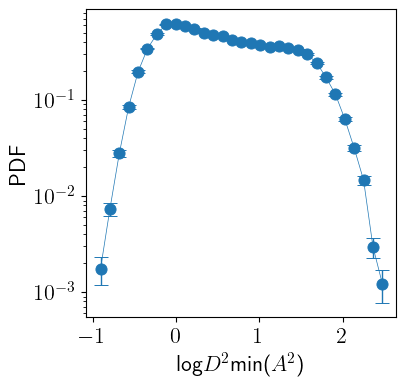

In [409]:
#import utility as utl

if eval(confParser['flags']['DminAnalysis']) and eval(confParser['flags']['Ovitos']):
#    itime = times[-1]
    filtr = np.log10(lmpDmin.coord_atoms_broken[itime]['d2min']) > -5
    d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itime][filtr].to_dict(orient='series') )
    
    #--- filter
#     d2min = lp.Atoms( **FilterDataFrame(pd.DataFrame(d2min.__dict__),
#                     column='d2min',
#                     limits =(1.0e-3,np.max(d2min.d2min))).to_dict(orient='series'))
                   
    utl.PdfD2min( d2min, 
              #times = [0,2000000],
#              times=[itime],#list(lmpDmin.coord_atoms_broken.keys()),     
              Plott = True,
                 yscale='log',
             Limit=(-3,np.max(np.log10(d2min.d2min)))
             )
    
#     thresh, ratio, junk = utl.gaussian_mixture(
#                                      d2min.d2min,
# #                                     times = list(d2min.keys()), 
#                                      PLOT = True,
#                                  )
#     mu_divide = np.log10(thresh)
#     print('mu_divide=',mu_divide)

    #--- save
#     strn = GetStrain(lmpDmin, 
#                      times = [itime], #list(lmpDmin.coord_atoms_broken.keys()), 
#                      time0 = 0 )
#     np.savetxt('varD2minGamma.txt',
#                np.c_[valuesDict(strn,strn.keys()), valuesDict(ratio,ratio.keys())], 
#                header='gamma\tratio')

    ydata=np.log10(d2min.d2min)
    ydata -= np.mean(ydata)
    ydata /= np.std(ydata)

    rho_stz0 = np.sum(ydata > 0)/len(d2min.d2min)
    rho_stz1 = np.sum(ydata > 1)/len(d2min.d2min)
    np.savetxt('D2minAnl/rhoStz.txt',np.c_[rho_stz0,rho_stz1],header='rho_stz_mean rho_stz_1stMoment')


In [410]:
# %psource utl.PdfD2min

In [411]:
if eval(confParser['flags']['DminAnalysis'])\
and not eval(confParser['flags']['RemoteMachine']):

    temps={
        0:298,
        1:423,
        2:523,
        3:623,
        4:723
    }
    keys = list(temps.keys())
    keys.sort()
    for key_temps in keys:
        path='amorphousAlumina'
        sdata = np.loadtxt('%s/temp%s/Run0/D2minAnl/rhoStz.txt'%(path,key_temps))
        temp = temps[key_temps]
        data_concat = np.c_[data_concat,sdata] if key_temps != 0 else sdata
        
#    ax = utl.PltErr(temps.values(),data_concat.T[:,0],Plot=False)
    utl.PltErr(temps.values(),data_concat.T[:,1],
               xstr=r'$T(K)$',
               ystr=r'$\rho_\mathrm{stz}$',
               title='softening.png',
#                   ax=ax,
                   )


### mean & variance 

In [412]:
if eval(confParser['flags']['DminAnalysis'])\
and eval(confParser['flags']['Ovitos']):
    #--- lambda function
    GetMeanD2min = lambda x: lp.Atoms( **lmpDmin.coord_atoms_broken[x].to_dict(orient='series') ).d2min.mean()
    GetStdD2min = lambda x: lp.Atoms( **lmpDmin.coord_atoms_broken[x].to_dict(orient='series') ).d2min.std()
    
    #--- 
    times = list(lmpDmin.coord_atoms_broken.keys())
    times.sort()
    times.pop(0)
    #
    ydata = np.array(list(map(GetMeanD2min,times)))
    zdata = np.array(list(map(GetStdD2min,times)))
    xdata = np.array(list(map(lambda x:utl.GetStrain(lmpData, x, 0 ),times)))
    #--- savetxt
    np.savetxt('D2minAnl/d2min_gamma.txt',np.c_[xdata,ydata,zdata],header='gamma d2min std')


In [413]:
def main():

    if eval(confParser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    #--- temp object
    temp = Temperature(
        [0,1,2,3,4,5,9],[list(range(3))]*10,
#        [9],[list(range(3))]*10,
#         verbose = True,
                     )
    #
    #--- parse data
    temp.Parse( list(map(lambda x:'shear/glassCo5Cr2Fe40Mn27Ni26/age%s/Run%s/D2minAnl/d2min_gamma.txt'%(x[0],x[1]),
                        temp.temps_runs )),
               skip_rows=1,
             )
    
    #--- average
    temp.EnsAverage()
    
    #--- plot
    dump_every=100;nevery=100;dt=1e-3;factor=dump_every*nevery*dt
    #
    symbols=Symbols()
    #
    legend=Legends()
    legend.Set(fontsize=16,
               bbox_to_anchor=(.5,0.1,0.5,0.5),
              )
    ax = utl.PltErr(None,None,Plot=False,attrs={})
    xdata_column=0;ydata_column=1
    for age, indx in zip(temp.temps,range(len(temp.temps))):
        xdata = temp.data_averaged[age][:,xdata_column]
        ydata = temp.data_averaged[age][:,ydata_column]
        yerr  = temp.data_averaged[age][:,2]
        utl.PltErr(xdata,ydata,#yerr=yerr,
                  attrs=symbols.GetAttrs(count=indx%7,nevery=4,label=r'$%d$'%(age*factor),linewidth=1),
                   ax=ax,
                   Plot=False,
                  )

    utl.PltErr(None,None, attrs={},
#                xstr=r'$\gamma_{xy}$',
#                ystr=r'$\sigma_{xy}$(Gpa)',
               ax=ax,
               legend=legend.Get(),
               title = 'png/d2min_strain_age.png',
               Plot=False,
#               ylim=(0.1,1e2),
               yscale='log',
              DrawFrame=DRAW_FRAME,
              )
    
    return temp

temp = main()

#### multiple realizations

In [414]:
if not eval(confParser['flags']['RemoteMachine']):
    PlotPaperVersion(2,2,
#                        xlabel=r'$\gamma$',
#                        ylabel=r'Percentage',
                        title='dmin_gamma.png',
                        ylim=(0,15),
                        xlim=(-0.01,.21),
                        PlotMean = True,
                        legend = True,
#                        yscale='log',
                        borderwidth = 0.01,
                    )

### multiple systems

In [415]:
if not eval(confParser['flags']['RemoteMachine']):
    #
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 1
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
#     ax.set_xlabel(r'$\gamma$',fontsize=20)
#     ax.set_ylabel(r'Norm. Std',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
#                                          'FeNi', #0,1,2
#                                           'CoNiFe', #0,2
                                             'CoNiCrFe/Run2', #0,1,2  ## bad 7
#                                             'CoCrFeMn', #0,1,2
#                                             'CoNiCrFeMn', #1,2 ##
                                            'Co5Cr5Fe40Mn27Ni26/Run0'# 0,1,2 # good 13
                                        ],markers, colors, fillstyles )):

        sarr  = np.loadtxt('d2min%s/D2minGamma.txt'%GlassType)
        #--- fliter
        ydata = sarr[:,1] #--- first 2nd col is stress drop
        xdata = sarr[:,0] #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata,ydata,
                linestyle='-',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                markevery=6*4,
                label = '%s'%GlassType[0:-5])
    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('D2minGamma.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

## cluster analysis

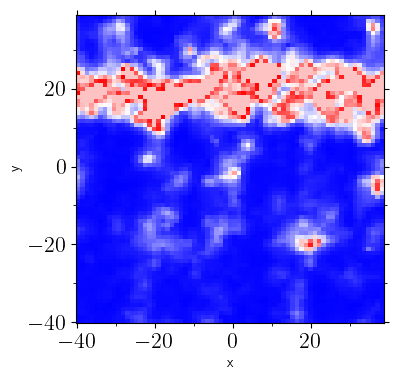

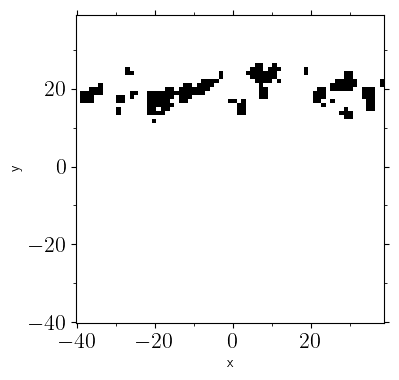

value.shape= (77, 69, 77)
p= 0.045800425811718865


In [416]:
if eval(confParser['flags']['DminAnalysis']):
    itimee0 = eval(confParser['parameters']['itime'])
    box0 = lp.Box(BoxBounds=lmpData.BoxBounds[itimee0])
    atomm = lp.Atoms( **lmpDmin.coord_atoms_broken[itimee0].to_dict(orient='series') )

     #-----------------
     #--- INTERPOLATE
     #-----------------
    (xlin, ylin, zlin), (xv, yv, zv), mu_intrp = utl.Intrp(atomm, box0, 'd2min',
                Plot = True,
               )
    mu = 10**(np.log10(atomm.d2min).mean()) #(atomm.d2min).mean()
    median = (atomm.d2min).median()
    mu_std=(atomm.d2min).std()
    mu_95 = np.percentile(atomm.d2min,95)

    value = utl.PltBinary(
                        xlin,ylin,zlin, mu_intrp.d2min,
                        box0,
                        mu_95, #--- threshold
                        cmap='Greys',
                        title='D2minAnl/negative_mu.%s.png'%itimee0,
                        zscore=False,
#                        colorbar = True,
                        #DrawFrame=(0.21,0.06,0.15,0.06,0.1),
                        xlabel = 'x', ylabel = 'y',
                        labels = True,
                     )
    print('value.shape=',value.shape)
    
    #---------------------
    #--- cluster analysis
    #---------------------
    threshold = mu_95 #eval(confParser['modulus analysis']['threshold'])
#     if eval(confParser['modulus analysis']['threshold_mean']):
#         threshold = mu
    mask = value >  threshold #--- threshold
    print('p=',np.sum(mask)/value.size)
    
#    stats = Stats(mask, xlin, ylin, zlin)
#    stats.GetSize()
#    print(stats.stats)
    
    #--- save
    np.save('D2minAnl/negative_mu',mask)
    np.savetxt('D2minAnl/xlin.txt',np.c_[xlin,],header='xlin')
    np.savetxt('D2minAnl/ylin.txt',np.c_[ylin,],header='ylin')
    np.savetxt('D2minAnl/zlin.txt',np.c_[zlin,],header='zlin')
    
    

    

In [51]:
def Wrapper(pathh, itime):
    #---
    try:
        stats = utl.Stats(mask=np.load('%s/negative_mu.npy'%pathh), 
                         xlin=np.loadtxt('%s/xlin.txt'%pathh), 
                         ylin=np.loadtxt('%s/ylin.txt'%pathh),
                         zlin=np.loadtxt('%s/zlin.txt'%pathh),
                        )
        stats.GetSize()
    #    print(stats.stats)
        stats.GetProbInf()
        stats.GetProb()
        stats.GetSmean()
        stats.GetCrltnLenSq()
        
#         if stats.p > pcut:
#             return
        #--- print pinf on disc
        stats.Print( pathh, #--- path
                    'pinf.txt',
                    np.c_[GammaXY*itime/ndump,stats.p,stats.pinf], #--- vals
                    '\gamma\tp\tpinf', #--- header
                        )
        #--- print <S>
        stats.Print(pathh, #--- path
                    'muClustersize_gamma.txt',
                    np.c_[GammaXY*itime/ndump,stats.p,stats.smean],
                    header='gamma\tp\t<S>')
        #--- print correlation length
        stats.Print(pathh, #--- path
                    'crltnl_gamma.txt',
                    np.c_[GammaXY*itime/ndump,stats.p,stats.si_sq**0.5],
                    header='gamma\tp\tsi')
        #--- size distributions
        hist, edges, error = utl.GetPDF( stats.stats['size'].astype(float),n_per_decade=8)
        #
        np.savetxt('%s/ps.txt'%pathh,
                   np.c_[edges,hist,error],
                   header='s\tp(s)\terror')
        #--- radius of gyration
        filtr = stats.stats['rg_sq'] > 0.0
        x,y=stats.stats['rg_sq'][filtr]**0.5,stats.stats['size'][filtr]    
        stats.Print(pathh, #--- path
                    's_rg.txt',
                    np.c_[x,y],
                    header='rg\ts')
    except:
#        traceback.print_exc()
        pass
    
if eval(confParser['flags']['DminAnalysis']) and not eval(confParser['flags']['RemoteMachine']):
    indxxxx=5
    ndump =100;GammaXY=0.2;dt=1e-3;GammaDot=1.0e-04;
    Nstep=np.floor(GammaXY/dt/GammaDot);Nevery=np.ceil(Nstep/ndump)
    Times = dict(zip(range(ndump+1), np.arange(0,Nstep+Nevery,Nevery,dtype=int)))
    times = np.arange(0,ndump+1,2)
    runs=[[0,1,2], [1,2], [0,1,2], [0,1,2], [1], [0,1,2] ][indxxxx]
    indicess = [ [0,5,10], [0,5], [0,5,10], [0,5,10], [0], [0,5,10] ][indxxxx]
    mg = {0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
          4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26',6:'CuZr3'}[indxxxx]
    #---
#    itime = eval(confParser['parameters']['itime'])
#    Wrapper('./D2minAnl', lmpData, itime)
    x, y = np.meshgrid(runs,times) #--- different realizations and times
    Age ={
            0:0,
             1:1,
#              2:2,
#              3:3,
#              4:4,
#              5:5,
#              6:6,
#              7:7,
#              8:8,
             9:9,
         }
    for key in Age:
        list(map(lambda x: Wrapper( './cxy/glass%s/age%s/itime%s/Run%s/D2minAnl'%(mg,Age[key],x[1],x[0]), x[1]), zip(x.flatten(),y.flatten()) ))

### plot binary

In [44]:
if eval(confParser['flags']['DminAnalysis']) and not eval(confParser['flags']['RemoteMachine']):
    try:
        !rm DminAnalysis/percCluster.xyz DminAnalysis/everyCluster.xyz DminAnalysis/*.png
    except:
        pass
    #---
    Plot = [True,False][0]
    pathh='./shear/glass%s/age9'%{0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                         4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx]
    nave = 1
#    box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ))
#    masks = []
    counterr = 0
    #---
    for irun in [0]:
        for itimee, counter in zip(times,range(len(times))): #--- read 3d matrix
            try:
                mask0 = np.load('%s/itime%s/Run%s/D2minAnl/negative_mu.npy'%(pathh,itimee,irun)) #--- parse
                xlin = np.loadtxt('%s/itime%s/Run%s/D2minAnl/xlin.txt'%(pathh,itimee,irun)) #--- parse
                ylin = np.loadtxt('%s/itime%s/Run%s/D2minAnl/ylin.txt'%(pathh,itimee,irun)) #--- parse
                zlin = np.loadtxt('%s/itime%s/Run%s/D2minAnl/zlin.txt'%(pathh,itimee,irun)) #--- parse
#                box0 = lp.Box( BoxBounds = lmpData.BoxBounds[itimee*10000],AddMissing = np.array([0.0,0.0,0.0] ))
                xv,yv,zv = np.meshgrid(xlin, ylin,zlin)
                #

                #--------------------------
                #--- statistics
                #--------------------------
                stats = utl.Stats(mask=mask0, 
                                 xlin=xlin, 
                                 ylin=ylin,
                                 zlin=zlin,
                                )
                stats.GetSize()
            #    print(stats.stats)
                stats.GetProbInf()
                stats.GetProb()
                stats.GetSmean()
                stats.GetCrltnLenSq()

                #--------------------------
                #--- plot
                #--------------------------
                junk = utl.PltBinary(
                                    xlin,ylin,zlin, (mask0).flatten().astype(int),
                                    box0,
                                    0.5, #--- threshold
                                    cmap='Greys',
                                    title='D2minAnl/negative_mu_%s.png'%itimee,
                                    zscore=False,
                                    DrawFrame=(0.17,0.17,0.15,0.06,0.1),
                                    xlabel = '', ylabel = '',
                                    labels = True,
                                    fontsize=18,
                                 )

                print('itime=%s,p=%s,ksi=%s'
                      %(itimee,stats.p,stats.si_sq**.5))


                counterr += 1

            except:
                traceback.print_exc()
                continue

rm: DminAnalysis/percCluster.xyz: No such file or directory
rm: DminAnalysis/everyCluster.xyz: No such file or directory
rm: DminAnalysis/*.png: No such file or directory


Traceback (most recent call last):
  File "<ipython-input-44-8ca3be7711dd>", line 46, in <module>
    box0,
NameError: name 'box0' is not defined
Traceback (most recent call last):
  File "<ipython-input-44-8ca3be7711dd>", line 18, in <module>
    mask0 = np.load('%s/itime%s/Run%s/D2minAnl/negative_mu.npy'%(pathh,itimee,irun)) #--- parse
  File "/opt/anaconda3/envs/gnnEnv/lib/python3.7/site-packages/numpy/lib/npyio.py", line 428, in load
    fid = open(os_fspath(file), "rb")
FileNotFoundError: [Errno 2] No such file or directory: './shear/glassCo5Cr2Fe40Mn27Ni26/age9/itime2/Run0/D2minAnl/negative_mu.npy'
Traceback (most recent call last):
  File "<ipython-input-44-8ca3be7711dd>", line 46, in <module>
    box0,
NameError: name 'box0' is not defined
Traceback (most recent call last):
  File "<ipython-input-44-8ca3be7711dd>", line 18, in <module>
    mask0 = np.load('%s/itime%s/Run%s/D2minAnl/negative_mu.npy'%(pathh,itimee,irun)) #--- parse
  File "/opt/anaconda3/envs/gnnEnv/lib/python3.7

Traceback (most recent call last):
  File "<ipython-input-44-8ca3be7711dd>", line 46, in <module>
    box0,
NameError: name 'box0' is not defined
Traceback (most recent call last):
  File "<ipython-input-44-8ca3be7711dd>", line 18, in <module>
    mask0 = np.load('%s/itime%s/Run%s/D2minAnl/negative_mu.npy'%(pathh,itimee,irun)) #--- parse
  File "/opt/anaconda3/envs/gnnEnv/lib/python3.7/site-packages/numpy/lib/npyio.py", line 428, in load
    fid = open(os_fspath(file), "rb")
FileNotFoundError: [Errno 2] No such file or directory: './shear/glassCo5Cr2Fe40Mn27Ni26/age9/itime62/Run0/D2minAnl/negative_mu.npy'
Traceback (most recent call last):
  File "<ipython-input-44-8ca3be7711dd>", line 46, in <module>
    box0,
NameError: name 'box0' is not defined
Traceback (most recent call last):
  File "<ipython-input-44-8ca3be7711dd>", line 18, in <module>
    mask0 = np.load('%s/itime%s/Run%s/D2minAnl/negative_mu.npy'%(pathh,itimee,irun)) #--- parse
  File "/opt/anaconda3/envs/gnnEnv/lib/python3.

### correlation length

mkdir: png: File exists
Co5Cr2Fe40Mn27Ni26
Co5Cr2Fe40Mn27Ni26
Co5Cr2Fe40Mn27Ni26
Co5Cr2Fe40Mn27Ni26
Co5Cr2Fe40Mn27Ni26
Co5Cr2Fe40Mn27Ni26


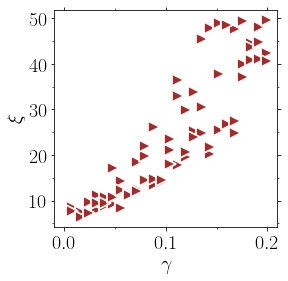

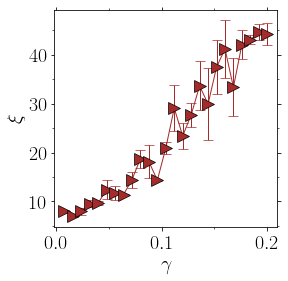

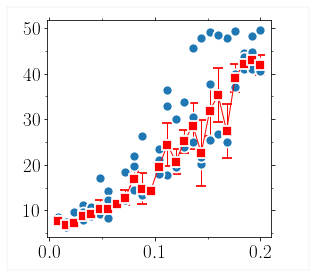

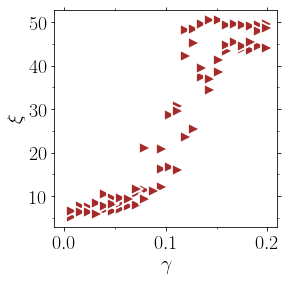

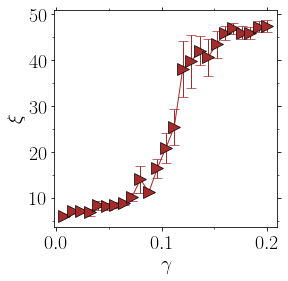

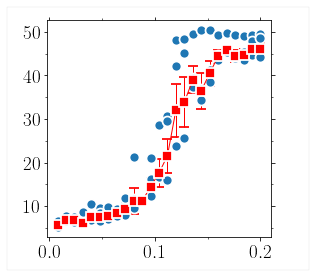

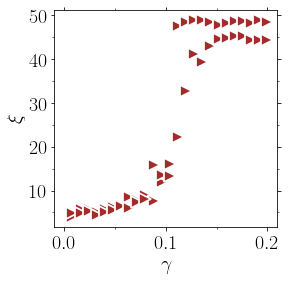

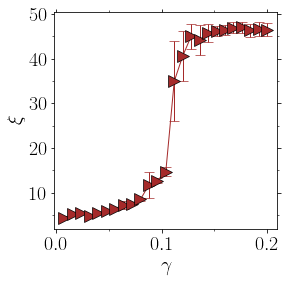

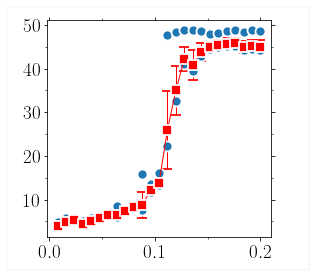

In [58]:
if eval(confParser['flags']['DminAnalysis']) and not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    for key in Age:

        ax_s0=utl.PlotPaperVersion(6,22,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                        xlabel=r'$\gamma$',
                        ylabel=r'$\xi$',
                        PlotEvery = True,
                        timeseries = True,
    #                    title='ModuAnl/pinf.png',
    #                    ylim=(1e-4,1e-2),
                        xlim=(-0.01,.21),
    #                    yscale = 'log',
                        runs=runs,
                        times = times[1:],
                        age = Age[key],
    #                    yscale='log',
    #                    verbose = True,
                    )

        ax_m0 = utl.PlotPaperVersion(6,22,
                        glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                               4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                        xlabel=r'$\gamma$',
                        ylabel=r'$\xi$',
    #                    ylim=(1e-7,1e-3),
                        PlotEvery = False, #--- plot timeseries
                        timeseries = True,
                        PlotMean = True,
                        nbins = 32, #--- nbins
    #                    yscale = 'log',
                        runs=runs,
                        times = times[1:],
                        age = Age[key],
    #                    verbose = True,
                    )

        #--- get y limits
        ydata = np.array(list(map(lambda x:ax_s0.lines[x].get_ydata(),indicess))).flatten()
        ydata = ydata[~np.isnan(ydata)]
        ydata.sort()
    #    print(ydata)
    #    ymin,ymax=ydata[int(0.05*len(ydata))],ydata[int(0.95*len(ydata))]    
        utl.Pltt(ax_s0,ax_m0,
             indices=indicess,
    #          yticks=(['10.0','35.0','60.0'],['10.0','35.0','60.0']),
    #          xticks=(['0.05','0.11','0.17'],['0.05','0.11','0.17']),
             title='png/crltnl_gamma_glass%s.png'%indxxxx,
    #         xlim=ax_m0.axis()[0:2],
    #         ylim=(ymin,ymax),
            fontsize=FontSize,
            DrawFrame=DFset,

            )
        Xm = np.c_[ax_m0.lines[0].get_xdata(),
                         ax_m0.lines[1].get_ydata(),
                         np.array(ax_m0.lines[2].get_ydata())-np.array(ax_m0.lines[0].get_ydata())]
        np.savetxt('png/crltn_length_age%s.txt'%(Age[key]),Xm,header='gamma ksi err')



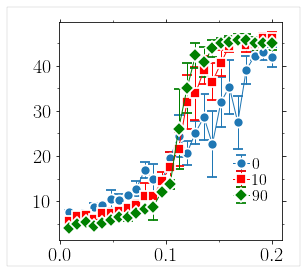

In [59]:
if eval(confParser['flags']['DminAnalysis']) and not eval(confParser['flags']['RemoteMachine']):        
    Age ={
           0:0,
              1:1,
#              2:2,
#              3:3,
#              4:4,
#              5:5,
#              6:6,
#              7:7,
#              8:8,
              9:9,
         }
    #--- plot
    dump_every=100;nevery=100;dt=1e-3;factor=dump_every*nevery*dt
    #
    symbols=Symbols()
    #
    legend=Legends()
#     legend.Set(fontsize=16,
#                bbox_to_anchor=(.7,0.4,0.5,0.5),
#               )
    legend.Set(fontsize=16,labelspacing=0.1,
               bbox_to_anchor=(.5,0.1,0.5,0.5),
              )
    ax = utl.PltErr(None,None,Plot=False,attrs={})
    xdata_column=0;ydata_column=1
    for age, indx in zip(Age.keys(),range(len(Age))):
        data = np.loadtxt('png/crltn_length_age%s.txt'%Age[age])
        xdata = data[:,xdata_column]
        ydata = data[:,ydata_column]
        yerr  = data[:,2]
        utl.PltErr(xdata,ydata,yerr=yerr,
                  attrs=symbols.GetAttrs(count=indx%7,nevery=1,label=r'$%d$'%(age*factor),linewidth=1),
                   ax=ax,
                   Plot=False,
                  )

    utl.PltErr(None,None, attrs={},
#                xstr=r'$\gamma_{xy}$',
#                ystr=r'$\sigma_{xy}$(Gpa)',
               ax=ax,
               legend=legend.Get(),
               title = 'png/crltn_length_age.png',
               Plot=False,
#               ylim=(-0.1,4),
              DrawFrame=DRAW_FRAME,
              )
    


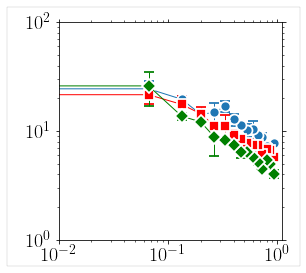

In [73]:
# if eval(confParser['flags']['DminAnalysis']) and not eval(confParser['flags']['RemoteMachine']):        
#     Age ={
#            0:0,
#               1:1,
# #              2:2,
# #              3:3,
# #              4:4,
# #              5:5,
# #              6:6,
# #              7:7,
# #              8:8,
#               9:9,
#          }
#     #--- plot
#     dump_every=100;nevery=100;dt=1e-3;factor=dump_every*nevery*dt
#     #
#     symbols=Symbols()
#     #
#     legend=Legends()
# #     legend.Set(fontsize=16,
# #                bbox_to_anchor=(.7,0.4,0.5,0.5),
# #               )
#     legend.Set(fontsize=16,labelspacing=0.1,
#                bbox_to_anchor=(.5,0.1,0.5,0.5),
#               )
#     ax = utl.PltErr(None,None,Plot=False,attrs={})
#     xdata_column=0;ydata_column=1
#     gammac=0.12
#     for age, indx in zip(Age.keys(),range(len(Age))):
#         data = np.loadtxt('png/crltn_length_age%s.txt'%Age[age])
#         xdata = (gammac - data[:,xdata_column])/gammac
#         ydata = data[:,ydata_column]
#         yerr  = data[:,2]
#         utl.PltErr(xdata,ydata,yerr=yerr,
#                   attrs=symbols.GetAttrs(count=indx%7,nevery=1,label=r'$%d$'%(age*factor),linewidth=1),
#                    ax=ax,
#                    Plot=False,
#                   )

#     utl.PltErr(None,None, attrs={},
# #                xstr=r'$\gamma_{xy}$',
# #                ystr=r'$\sigma_{xy}$(Gpa)',
#                ax=ax,
# #               legend=legend.Get(),
#                title = 'png/crltn_length_age.png',
#                Plot=False,
#                xlim=(0.01,1.1),ylim=(1,1e2),
#                xscale='log',yscale='log',
#               DrawFrame=DRAW_FRAME,
#               )
    


### mean size

Co5Cr2Fe40Mn27Ni26
Co5Cr2Fe40Mn27Ni26
Co5Cr2Fe40Mn27Ni26
Co5Cr2Fe40Mn27Ni26
Co5Cr2Fe40Mn27Ni26
Co5Cr2Fe40Mn27Ni26


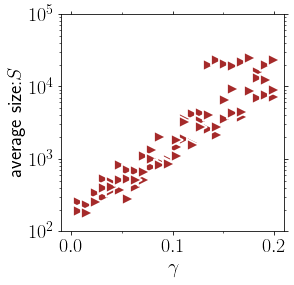

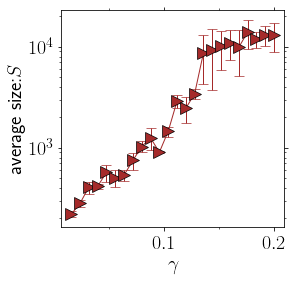

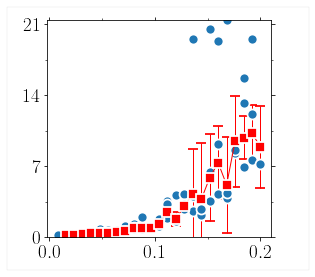

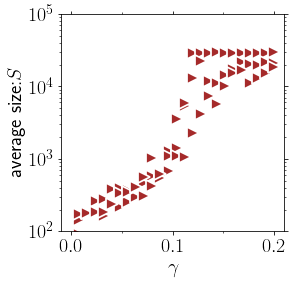

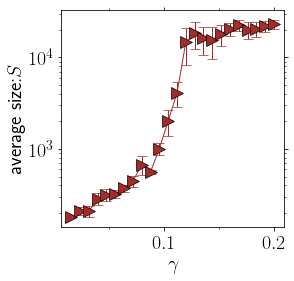

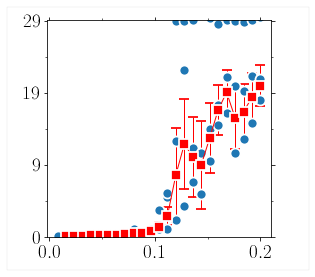

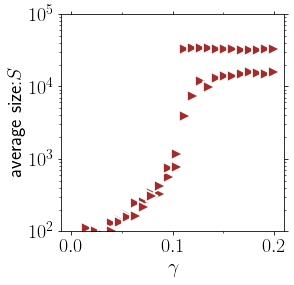

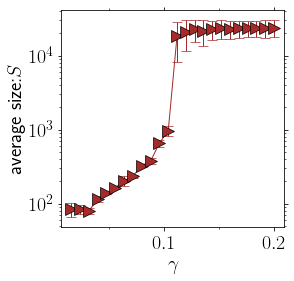

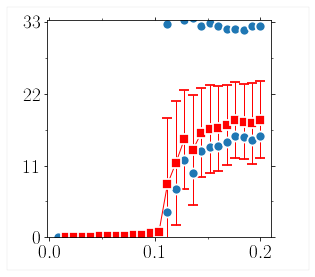

In [62]:
if eval(confParser['flags']['DminAnalysis']) and not eval(confParser['flags']['RemoteMachine']):
    for key in Age:
        #--- fetch data
        ax_s0=utl.PlotPaperVersion(6,14,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                        xlabel=r'$\gamma$',
                        ylabel=r'average size:$S$',
                        PlotEvery = True,
                        timeseries = True,
    #                    title='ModuAnl/mean_size.png',
                        ylim=(1e2,1e5),
                        xlim=(-0.01,.21),
                        runs=runs,
                        times = times[1:],
                        age = Age[key],
                            yscale='log',
                        verbose=False,
                    )    

        #--- get averaged data
        ax_m0 = utl.PlotPaperVersion(6,14,
                        glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                               4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                        xlabel=r'$\gamma$',
                        ylabel=r'average size:$S$',
                        PlotEvery = False, #--- plot timeseries
                        timeseries = True,
                        PlotMean = True,
                        nbins = 1024,#64, #--- nbins
                        runs=runs,
                        times = times[1:],
                        age = Age[key],
                        verbose=False,
                        scale='log',
                        yscale='log',
                    )
        #--- set limits
        ydata = np.array(list(map(lambda x:ax_s0.lines[x].get_ydata(),indicess))).flatten()
        ydata = ydata[~np.isnan(ydata)]
        ydata.sort()
        ymin,ymax=ydata[int(0.05*len(ydata))],ydata[int(0.95*len(ydata))]
        yticks=np.linspace(0,1000*np.floor(ymax/1000.0),4,endpoint=True)

        utl.Pltt(ax_s0,ax_m0, indices=indicess,
             title='png/smean_gamma_glass%s.png'%indxxxx,
    #         xlim=(0.05,0.17),

               yticks=(['%i'%(i/1000.0) for i in yticks],yticks),
    #           xticks=(['0.05','0.11','0.17'],['0.05','0.11','0.17']),
             ylim=(ymin,ymax),
            fontsize=FontSize,
            DrawFrame=DFset,
    #        fill_between = True,
            )    

        Xm = np.c_[ax_m0.lines[0].get_xdata(),
                         ax_m0.lines[1].get_ydata(),
                         np.array(ax_m0.lines[2].get_ydata())-np.array(ax_m0.lines[0].get_ydata())]
        np.savetxt('png/mean_length_age%s.txt'%(Age[key]),Xm,header='gamma S err')

        


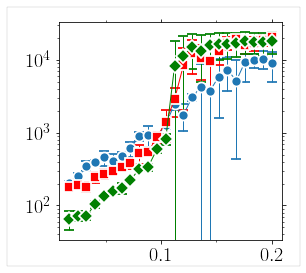

In [64]:


if eval(confParser['flags']['DminAnalysis']) and not eval(confParser['flags']['RemoteMachine']):        
    Age ={
                0:0,
                 1:1,
#                  2:2,
#                  3:3,
#                  4:4,
#                  5:5,
#                  6:6,
#                  7:7,
#                  8:8,
                 9:9,
             }
    #--- plot
    dump_every=100;nevery=100;dt=1e-3;factor=dump_every*nevery*dt
    #
    symbols=Symbols()
    #
    legend=Legends()
#     legend.Set(fontsize=16,
#                bbox_to_anchor=(.7,0.4,0.5,0.5),
#               )
    legend.Set(fontsize=16,labelspacing=0.1,
               bbox_to_anchor=(.5,0.1,0.5,0.5),
              )
    ax = utl.PltErr(None,None,Plot=False,attrs={})
    xdata_column=0;ydata_column=1
    for age, indx in zip(Age.keys(),range(len(Age))):
        data = np.loadtxt('png/mean_length_age%s.txt'%Age[age])
        xdata = data[:,xdata_column]
        ydata = data[:,ydata_column]
        yerr  = data[:,2]
        utl.PltErr(xdata,ydata,yerr=yerr,
                  attrs=symbols.GetAttrs(count=indx%7,nevery=1,label=r'$%d$'%(age*factor),linewidth=1),
                   ax=ax,
                   Plot=False,
                  )

    utl.PltErr(None,None, attrs={},
#                xstr=r'$\gamma_{xy}$',
#                ystr=r'$\sigma_{xy}$(Gpa)',
               ax=ax,
#               legend=legend.Get(),
               title = 'png/mean_size_age.png',
               Plot=False,
               yscale='log',
#               ylim=(-0.1,4),
              DrawFrame=DRAW_FRAME,
              )
    


## Interpolation

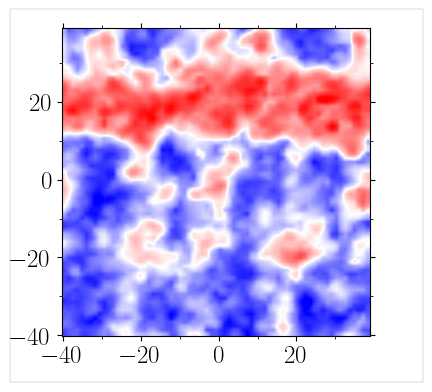

In [423]:
if eval(confParser['flags']['DminAnalysis']):
    box0 = lp.Box( BoxBounds = lmpData.BoxBounds[itime],AddMissing = np.array([0.0,0.0,0.0] ))
    atom = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )
    #---
    PlotAttrs = {
                'zscore' : False,
                'scale' : 'log',
                'xlabel' : '', #r'$x$(\r{A})', 
                'ylabel' : '', #r'$y$(\r{A})',
                'DrawFrame':(0.17,0.17,0.15,0.06,0.1),
#                'colorbar':True,
                'labels' : True,
                 'vmin':-0.5,
                 'vmax':+2.1,
                'fontsize':18,
                'interpolation':'bilinear',
                }
    junk, junk, d2intrp = utl.Intrp(atom, box0,
                    attr = 'd2min',
                    Plot = True,
                    title='D2minAnl/map_d2min_%s.png'%itime,
                    **PlotAttrs
                    )

In [424]:
# atom.tmp = np.log10(atom.d2min) >= 0

# PlotAttrs = {
#             'zscore' : False,
# #            'scale' : 'log',
#             'xlabel' : '', #r'$x$(\r{A})', 
#             'ylabel' : '', #r'$y$(\r{A})',
#             'DrawFrame':(0.17,0.17,0.15,0.06,0.1),
#             'colorbar':True,
#             'labels' : True,
# #             'vmin':-0.5,
# #             'vmax':+2.1,
#             'fontsize':18,
#             }

    
# junk, junk, junk=Intrp(atom, box0,
#                     attr = 'tmp',
#                     Plot = True,
#                     title='DminAnalysis/map_d2min.png',
#                     **PlotAttrs
#                     )

### time evolution

In [425]:
if not eval(confParser['flags']['RemoteMachine']):
    times = list(lmpDmin.coord_atoms_broken.keys())
    times.sort()
    for itimee in np.array([0,100,200])*10000: #times[0::10]:
        if itimee == 0:
            continue
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[itimee],AddMissing = np.array([0.0,0.0,0.0] ))
        print('itime=%s,gamma=%3.2f'%(itimee,GetStrain(lmpData, itimee, 0 )))
        atom = lp.Atoms( **lmpDmin.coord_atoms_broken[itimee].to_dict(orient='series') )
        #---
        junk, junk, d2intrp = Intrp(atom, box0,
                        attr = 'd2min',
                        Plot = True,
                        title='DminAnalysis/map_d2min_%s.png'%itimee,
                        **PlotAttrs                   
                                   )

### Print Ovito output

In [426]:
if not eval(confParser['flags']['RemoteMachine']):
    #--- print 
    file_name = 'd2min.xyz'
    try:
        os.system('rm %s'%file_name)
    except:
        pass



    # PrintOvito( pd.DataFrame(d2intrp.__dict__), 
    #             open(file_name,'a'), 
    #             footer = 'ITIME=%s'%itime,
    # #                attr_list=['id','type','xm','ym','zm','d2min'],
    #             attr_list=['x','y','z','d2min'] 
    #           )
    times = list(lmpDmin.coord_atoms_broken.keys())
    times.sort()

    for itimee in times: #=2000000
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[itimee],AddMissing = np.array([0.0,0.0,0.0] ))
        print('itime=%s,gamma=%2.1e'%(itimee,GetStrain(lmpData, itimee, 0 )))
        d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itimee].to_dict(orient='series') )

                #--- map to square box
        mapp = lp.Map( d2min, box0 ) 
        mapp.ChangeBasis()
        mapp.Set( d2min ) #--- atoms: add mapped xyz

        PrintOvito( pd.DataFrame(d2min.__dict__), 
                    open(file_name,'a'), 
                    footer = 'ITIME=%s'%itimee,
        #                attr_list=['id','type','xm','ym','zm','d2min'],
                    attr_list=['id','type','xm','ym','zm','d2min'] 
                  )

        # #--- current frame
        # d2minList=pd.DataFrame(d2min.__dict__).sort_values(by='id', ascending=True, inplace=False)['d2min']
        # df = pd.DataFrame(atoms.__dict__).sort_values(by='id', ascending=True, inplace=False)
        # #attrs = 
        # d2min2 = lp.Compute( atoms, box )
        # d2min2.Set(np.c_[df,d2minList],attrs=list(df.keys()) + ['d2min'])
        # attrs = ['id','type','x','y','z','d2min']
        # d2min2 = pd.DataFrame(np.c_[list(map(d2min2.__dict__.get,attrs))].T, columns = attrs )
        # PrintOvito( d2min2, 
        #             open(file_name,'a'), 
        #             footer = 'ITIME=%s'%itime,
        #             attr_list=['id','type','x','y','z','d2min'] )

    # if DminAnalysis:# and not Ovitos:
    #     PlotOvito( d2intrp,
    #               itime
    #              )

## Crltn Function (Unstructured points)

In [427]:
if eval(confParser['flags']['DminAnalysis'])\
and eval(confParser['flags']['CrltnFunctionUnstructured'])\
and not eval(confParser['flags']['Ovitos']):
    crltn = lp.ComputeCrltn(  d2min, box, 
                              d2min.d2min, #--- values
                              cutoff = cutoff, #--- cutoff size to include neighbors
                              dx = dlgr0, #--- discretization length: 1st peak in rdf
                              NMAX = NMAX, #--- upper bounds for the number of atoms
                            )
    crltn.Distance()
    crltn.AutoCrltn(RADIAL = None)
    xvv, yvv, zvv, hist, err = crltn.Get()

    #--- save data
    np.save('CrltnFuncUnstructured',np.c_[xvv, yvv, zvv, hist, err])

In [428]:
# n=1000*4
# xyz = np.random.random((n,3)) 
# atom_tmp = lp.Atoms(**pd.DataFrame(np.c_[np.arange(n),np.ones(n),xyz],
#                                    columns=['id','type','x','y','z']).to_dict(orient='list'))
# box_tmp = lp.Box(CellOrigin=np.array([0,0,0]),CellVector=np.array([[1,0,0],[0,1,0],[0,0,1]]))
# #val = np.sin(2*np.pi*xyz[:,0])
# rstar = 0.25
# xyz = xyz - np.array([0.5,0.5,0.5])
# val = np.exp(-0.5*(xyz[:,0]**2+xyz[:,1]**2+xyz[:,2]**2)/rstar/rstar)
# crltn = lp.ComputeCrltn(    atom_tmp, box_tmp,
#                              val,
#                              cutoff=1.0*3**.5, dx=0.05,
#                              NMAX = n
#                      )
# crltn.Distance()
# crltn.AutoCrltn(RADIAL = None)
# xvv, yvv, zvv, hist, err = crltn.Get()

# dlgr0 = 0.05/2

### Plot Crltns

In [429]:
#--- load data
# sdata = np.load('CrltnFuncUnstructured.npy')
# nz = sdata.shape[2]/5
# xv = sdata[:,:,0:nz]
# yv = sdata[:,:,nz:2*nz]
# zv = sdata[:,:,2*nz:3*nz]
# hist = sdata[:,:,3*nz:4*nz]
# err = sdata[:,:,4*nz:5*nz]

In [430]:
if eval(confParser['flags']['DminAnalysis'])\
and eval(confParser['flags']['CrltnFunctionUnstructured'])\
and not eval(confParser['flags']['Ovitos']):
    #--- get 2d slice
    xv2d, yv2d, hist2d, err2d = GetSlice2d( hist, err,
                                           xvv, yvv, zvv,
                                           z=0.0, xtol = dlgr0/2
                                          )
    #--- bitmap
    PltBitmap(hist2d, 
              xlabel = 'x', ylabel = 'y',
              xlim=(xv2d.min(),xv2d.max()),ylim=(yv2d.min(),yv2d.max()),
              zscore = None,
              frac = 1.0, #--- plot a patch
              ) 

    #--- get 1d slice
    xv1d, hist1d, err1d =   GetSlice1d( hist2d, err2d,
                                 xv2d, yv2d,
                                 xtol = dlgr0/2,
                                 y=0.0)   
    #--- plot
    PltCrltnFunc1d( hist1d[xv1d>0.0], err1d[xv1d>0.0],
                     xv1d[xv1d>0.0],
                     fileName = 'cr.%s.png'%itime,
    #                 title = r'$\epsilon=%3.2f$'%(2*ebulk),
                     cTOL = 8.0e-2,
                     dpi = 60,
                    )

## Crltn Function (FFT)

In [431]:
def CrltnFunctionFFT( atom, box, box0, attr, Plot = True):
    
        (xlin,ylin,zlin), (xv, yv, zv), d2intrp = Intrp( atom, box,
                                                         attr, 
                                                         Plot = None 
                                                       )

        (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
        #
        value = np.c_[d2intrp.d2min].reshape((ny,nx,nz))

        #--- shuffle
        #     ( nx, ny, nz ) =  value.shape
        #     slist = value.flatten()
        #     np.random.shuffle(slist)
        #     value=slist.reshape((nx, ny, nz))    
        #
        #--- filter value
        #     value = FilterMatrix( CellVector[0], CellOrigin[0],
        #                   (xlin, ylin, zlin),
        #                   (xv, yv, zv ),
        #                    value )

        crltn = GetAutoCorrelation( value )

#        box = lp.Box( BoxBounds = lmpData.BoxBounds[itime] )
#        box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))

        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
        #    

        #--- xy plane
        val = crltn[:,:,0].copy()
        if Plot:
            PltCrltn( val, 
                      xlabel = 'x', ylabel = 'y',
                      xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
                      frac = 1, #--- plot a patch
                      zscore = False,
                      fileName = 'cxy_d2minBad.png',
                      dpi = 60
                    )

        #--- bulk strain
        dx=box.CellVector[0,1]-box0.CellVector[0,1]
        l1=box.CellVector[1,1]
        ebulk = dx/l1
        #---
        (xc, yc), (xdata0,ydata0), (xdata,ydata) =\
                PltCrltnFunc(   crltn, 
                                 xv,yv,
                                 fileName = 'cr_d2minBad.png',
                                 title = '', #r'$\gamma=%3.2f$'%(ebulk),
                                 cTOL = 1.0e-2,
                                 dpi = 150,
                                 PLOT = Plot,
                                )
        
        #--- save
        return  (ebulk, xc, yc)
    
if eval(confParser['flags']['DminAnalysis'])\
and not eval(confParser['flags']['RemoteMachine']):
    box0  = lp.Box( BoxBounds = lmpData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ))
    box  = lp.Box( BoxBounds = lmpData.BoxBounds[itime],AddMissing = np.array([0.0,0.0,0.0] ))
    atom = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )
    #---
    ebulk, xc, yc = CrltnFunctionFFT(atom, box, box0,'d2min', 
                    Plot = True,
                    )

#    np.savetxt('rc_d2min.txt',np.c_[ebulk, xc, yc],header='gamma\txc\tyc')


### Multiple Frames

In [432]:
if eval(confParser['flags']['DminAnalysis']) and not eval(confParser['flags']['RemoteMachine']):
    times = list(lmpDmin.coord_atoms_broken.keys())
    times.sort()
    box0  = lp.Box( BoxBounds = lmpData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ))
    box  = lambda x:lp.Box( BoxBounds = lmpData.BoxBounds[x],AddMissing = np.array([0.0,0.0,0.0] ))
    atom = lambda x:lp.Atoms( **lmpDmin.coord_atoms_broken[x].to_dict(orient='series') )

    exy=list(map(lambda x:CrltnFunctionFFT(atom(x), box(x), box0,'d2min', Plot=False), times))
    np.savetxt('rc_d2min.txt',np.c_[exy],header='gamma\txc\tyc')


In [433]:
if not eval(confParser['flags']['RemoteMachine']):
    PlotPaperVersion(
                        xlabel=r'$\gamma$',
                        ylabel=r'$r_c$(\r{A})',
                        title='rc_gamma.png',
                        ylim=(0,40),
                        xlim=(0.1,.2),
                        PlotMean = False,
                        legend = True,
#                        yscale='log',
                        borderwidth = 0.01,
                    )

#### Plot

In [434]:
if not eval(confParser['flags']['RemoteMachine']):
    sarr = MultipleFrames('widthFeNi','rc_d2min.txt',irun=0)
#--- plot
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    xstr = r'$\gamma$'
    ystr = r'$r_c(A^\circ)$'
    ax.set_xlabel(xstr,fontsize=16)
    ax.set_ylabel(ystr,fontsize=16)
    ax.tick_params(labelsize=16)
    #
    ax.plot( sarr[:,0], sarr[:,1],'-o', color='C0', label = r'$x_c$')
    ax.plot( sarr[:,0], sarr[:,2],'-s', color='red', label = r'$y_c$')
    ax.legend(frameon=False)
    plt.savefig('rc.png',dpi=75,bbox_inches='tight')
    plt.show()


### Band width vs. mismatch

In [435]:
if not eval(confParser['flags']['RemoteMachine']):
    ax=PlotPaperVersionScatter( 2, #--- path:
                            xindx=6, colx = 0, #--- x: delta (1st column)
                            yindx=3, coly = 1, #--- y: hmin( 2nd column)
#                        xlabel=r'$\delta_a$',
#                        ylabel=r'$w_{sb}$',
                        title='WidthAndDelta2nd.png',
                        xlim=(0.006,0.011),
                        ylim=(9.0,33.0),
#                         legend = True,
                        borderwidth = 0.01,
                        fontsize = 23,
                        markersize = 12,
                    )

# Voronoi Analysis

In [436]:
os.system('mkdir VorAnl')

mkdir: cannot create directory ‘VorAnl’: File exists


256

In [437]:
if eval(confParser['flags']['VorAnl']):
    try:
        !rm VorAnl/Voronoi.xyz
    except:
        pass
    rad1=0.0#AtomicRadius[1]
    rad2=0.0#AtomicRadius[2]
    rad3=0.0#AtomicRadius[3]
    rad4=0.0#AtomicRadius[4]
    rad5=0.0#AtomicRadius[5]
    
    path = confParser['input files']['path']
    indx = int(confParser['input files']['fileIndex'])
    fileName = '%s/%s'%(path,confParser['input files']['filename'].split()[int(indx)])
    nevery = int(confParser['parameters']['nevery'])
    pypath = confParser['python library path']['path']

    #--- dump files
    !ovitos $pypath/OvitosCna.py $fileName VorAnl/Voronoi.xyz $nevery 3 $rad1 $rad2 $rad3 $rad4 $rad5  

InputFile= ../simulations/shear/glassCo5Cr2Fe40Mn27Ni26/age0/Run0/dumpSheared.xyz
OutputFile= VorAnl/Voronoi.xyz
nevery 100
InputFile= ../simulations/shear/glassCo5Cr2Fe40Mn27Ni26/age0/Run0/dumpSheared.xyz
num_frames= 101
frame=0/101
frame=100/101


In [438]:
#--- read from d2min.xyz
if eval(confParser['flags']['VorAnl']) and eval(confParser['flags']['Ovitos']):
    lmpVor = lp.ReadDumpFile( 'VorAnl/Voronoi.xyz' )
    lmpVor.GetCords( ncount = sys.maxsize)

## histogram

In [439]:
# if eval(confParser['flags']['VorAnl']) and eval(confParser['flags']['Ovitos']):
#      utl.GetMotifs( lmpVor, 
#                 times = [itime], #[2000000], #lmpData.coord_atoms_broken.keys(),
#                 Plot = True
#               )

## Timeseries

In [440]:
def GetMotifsTimeseries( lmpData, 
                         Motif = np.array([[0,0,12,0]]),
                       ):
    times = list(lmpData.coord_atoms_broken.keys())
    times.sort()
    Unique_indices, Counts = utl.GetMotifs( lmpData, 
                                         times = times,
                                         Plot = False,
                                       )
    vol = utl.GetVolume(lmpData,0)
    natom = len(lmpData.coord_atoms_broken[0].x)
    #
    strn =  list(map(lambda x:utl.GetStrain(lmpData,x,time0=0), times))

    #
    #
    percent = {}
    for motif,indx in zip(Motif,range(len(Motif))):
        percent[indx] = {}
        for itime in times:
            counts = Counts[itime]
            unique_indices = Unique_indices[itime]
            percent[indx][itime] = counts[np.all(unique_indices== motif,axis=1)] * natom / vol
    #--- plot
#     plt.yscale('log')
#     plt.ylim(.1,100)
#     plt.xlabel('$\gamma$',fontsize=16)
#     plt.ylabel('Percentage',fontsize=16)
#     plt.tick_params(labelsize=16)
#     #
#     for indx in range(len(Motif)):
#         plt.plot(strn,list(map(percent[indx].get,times)),
#                  '-',
#                  label = Motif[indx]
#                 )
#     #
#     plt.legend(frameon=False,fontsize=14)
#     plt.savefig('motifsTimeSeries.png',dpi=75,bbox_inches='tight')
#     plt.show()
    #
    np.savetxt('VorAnl/icoPercentageWithStrain.txt',
               np.c_[strn,list(map(percent[indx].get,times))],
               header='gamma\tpercentage'
              )
    
    

if eval(confParser['flags']['VorAnl']) and eval(confParser['flags']['Ovitos']):
    GetMotifsTimeseries( lmpVor, 
                         Motif = np.array([[0,0,12,0]]), #,[0,1,10,2],[0,2,8,2],[0,3,6,4],[0,2,8,4]]),
                       )

### Multiple Systems

In [441]:
if not eval(confParser['flags']['RemoteMachine']):    

    PlotPaperVersion(2,1,
#                        xlabel=r'$\gamma$',
#                        ylabel=r'Percentage',
                        title='icoPercentage.png',
                        ylim=(0.6,1.01),
                        xlim=(-0.01,.21),
                        PlotMean = True,
#                        legend = True
                    )
    

In [442]:
def main():

    if eval(confParser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    #--- temp object
    temp = Temperature(
        [0,1,2,3,4,5,9],[list(range(3))]*10,
#        [9],[list(range(3))]*10,
#         verbose = True,
                     )
    #
    #--- parse data
    temp.Parse( list(map(lambda x:'shear/glassCo5Cr2Fe40Mn27Ni26/age%s/Run%s/VorAnl/icoPercentageWithStrain.txt'%(x[0],x[1]),
                        temp.temps_runs )),
               skip_rows=1,
             )
    
    #--- average
    temp.EnsAverage()
    
    #--- plot
    dump_every=100;nevery=100;dt=1e-3;factor=dump_every*nevery*dt
    #
    symbols=Symbols()
    #
    legend=Legends()
    legend.Set(fontsize=16,
               bbox_to_anchor=(.5,0.1,0.5,0.5),
              )
    ax = utl.PltErr(None,None,Plot=False,attrs={})
    xdata_column=0;ydata_column=1
    for age, indx in zip(temp.temps,range(len(temp.temps))):
        xdata = temp.data_averaged[age][:,xdata_column]
        ydata = temp.data_averaged[age][:,ydata_column]
        yerr  = temp.data_averaged[age][:,2]
        utl.PltErr(xdata,ydata,yerr=yerr,
                  attrs=symbols.GetAttrs(count=indx%7,nevery=8,label=r'$%d$'%(age*factor),linewidth=1),
                   ax=ax,
                   Plot=False,
                  )

    utl.PltErr(None,None, attrs={},
#                xstr=r'$\gamma_{xy}$',
#                ystr=r'$\sigma_{xy}$(Gpa)',
               ax=ax,
#               legend=legend.Get(),
               title = 'png/rhoIco_strain_age.png',
               Plot=False,
#               ylim=(0.1,1e2),
#               yscale='log',
              DrawFrame=DRAW_FRAME,
              )
    
    return temp

temp = main()

## conditional pdf of d2min

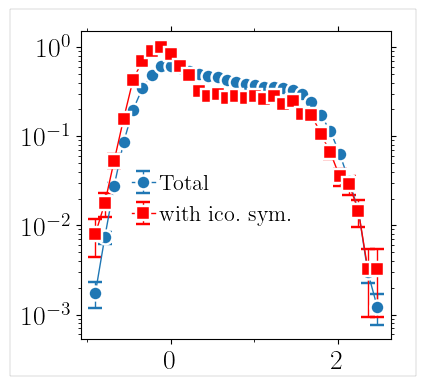

In [456]:
if eval(confParser['flags']['DminAnalysis']) and eval(confParser['flags']['VorAnl']):
    symbols=Symbols()
    legend=Legends()
    legend.Set(fontsize=16,labelspacing=0.5,
               bbox_to_anchor=(.1,0.1,0.5,0.5),
              )
    itime = eval(confParser['parameters']['itime'])
    val = lmpDmin.coord_atoms_broken[itime].d2min
    hist, edges, err = utl.GetPDF(np.log10(val), n_per_decade=32,linscale=True)
#    hist, edges, err = utl.GetPDF(val)
    ax=utl.PltErr(edges,hist,yerr=err,
                  attrs=symbols.GetAttrs(count=0,label=r'$\mathrm{Total}$'),
                  Plot=None,
              )

    filtr=utl.GetFullIcosahedra(lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') ))
    val = lmpDmin.coord_atoms_broken[itime][filtr].d2min
    hist, edges, err = utl.GetPDF(np.log10(val), n_per_decade=32,linscale=True)
#    hist, edges, err = utl.GetPDF(val)
    utl.PltErr(edges,hist,yerr=err,
                  attrs=symbols.GetAttrs(count=1,label=r'$\mathrm{with~ico.~sym.}$'),
                  ax=ax,
                  Plot=None,
              xscale='linear',yscale='log',
#              xscale='log',yscale='log',
               legend=legend.Get(),
               DrawFrame=DRAW_FRAME,
               title='VorAnl/d2minDist_quenched.png'
              )



In [448]:
help(legend.Set)

Help on method Set in module __main__:

Set(fontsize=20, labelspacing=0, **kwargs) method of __main__.Legends instance



### gaussian mixture

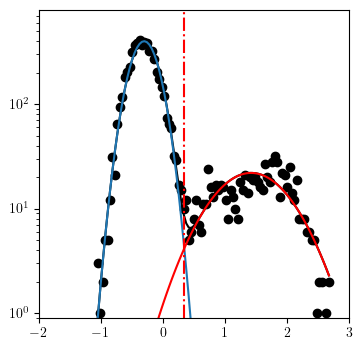

In [246]:
if eval(confParser['flags']['DminAnalysis']) and eval(confParser['flags']['VorAnl']):
    d2minFiltrd, d2minTotal = utl.PdfCondD2min( lmpVor, lmpDmin,
                                           #times = list(lmpData.coord_atoms_broken.keys()), 
                                           times=[itime], #[2000000],
                                           Plot = False,
                 )
    try:
        thresh, ratio, gsfitTotal = utl.gaussian_mixture(
                                          #d2minTotal,
                                          d2minFiltrd[itime],
    #                                     times = list(d2minFiltrd.keys()), 
                                          #times = [2000000],
                                          PLOT = True,
                                         )
        #--- save
    #     nn=len(d2minFiltrd[2000000])
        np.savetxt('d2minFiltrdGood%s.txt'%itime,d2minFiltrd[itime])
        np.savetxt('gsfitTotalGood%s.txt'%itime,gsfitTotal)
    except:
        pass
#     strn = GetStrain(lmpData, 
#                      times = list(lmpData.coord_atoms_broken.keys()), 
#                      time0 = 0 )
#    np.savetxt('varD2minCondGamma.txt',
#               np.c_[valuesDict(strn,strn.keys()), valuesDict(ratio,ratio.keys())], 
#               header='gamma\tratio')


#### evolution with strain

In [247]:
if not eval(confParser['flags']['RemoteMachine']):
    #
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 1
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
#     ax.set_xlabel(r'$\gamma$',fontsize=20)
#     ax.set_ylabel(r'Norm. Std',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
#                                         'FeNi',
#                                         'CoNiFe',
                                        'CoNiCrFe/Run2',
#                                         'CoCrFeMn', 
#                                         'CoNiCrFeMn', 
                                        'Co5Cr2Fe40Mn27Ni26/Run0'
                                        ],markers, colors, fillstyles )):

        sarr  = np.loadtxt('d2minRatio%s/d2minRaioGamma.txt'%GlassType)
        #--- fliter
        ydata = sarr[:,1] #--- first 2nd col is stress drop
        xdata = sarr[:,0] #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata,ydata,
                linestyle='-',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                markevery=int(len(xdata)/20),
                label = '%s'%GlassType[0:-5])
    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('D2minGamma.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

### good, bad, and ugly!

In [248]:
def PdfD2minGoodBad( lmpData, lmpDmin, badfit, goodfit,  times,  
                  Plot = True, title='pdfCondD2min.png',
                 axisLabels = True,
                    **kwargs
                ):
    #--- plot
    if Plot:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        #
        ax.set_xscale('linear' if not 'xscale' in kwargs else kwargs['xscale'])
        ax.set_yscale('linear' if not 'yscale' in kwargs else kwargs['yscale'])
        #
#         ax.set_ylim(1,1e4)
#         ax.set_xlim(-1,3)
#         #
        if axisLabels:
            ax.set_xlabel(r'log$D^2$min($A^2$)',fontsize=16)
            ax.set_ylabel(r'PDF',fontsize=16)
        #
        #ax.set_title(r'itime=%s'%itime)
        #
#        PutMinorTicks( ax, LOGY = True)
        #
        ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)

    valueFiltrd = {}
    valueTot = {}
    for itimee in sorted(times): 



        #--- filtered
        value = lmpDmin
        hist_filtrd, edges_filtrd, error_filtrd = GetPDF( np.log10(value), 
                                                         linscale = True, 
                                                         n_per_decade=32,
                                                         density = True,
                                                        )
        #--- invert
        valinv = lmpData
        hist_inv, edges_inv, error_inv = GetPDF( np.log10(valinv), 
                                                linscale = True, 
                                                n_per_decade=32,
                                                density = True,
                                               )


        if Plot:
            attr = { 'markersize':10,'markeredgewidth':0.7,
                     'linewidth':.5,'barsabove':None,'capsize':5,
                     'capthick':1,'elinewidth':1}
            #
            nmark = 16
            label = kwargs['label1'] if 'label1' in kwargs else ''
            ax.errorbar(edges_filtrd,hist_filtrd,error_filtrd,
                        **attr,
                        fmt='o', color='black', 
                        markerfacecolor='white', markeredgecolor=None,
                        label=label, markevery = int(len(edges_filtrd)/nmark),
                        errorevery = int(len(edges_filtrd)/nmark), zorder=1,
                       )
            #--- plot gs fit
            nn=len(lmpDmin)
            dx=goodfit[:,0][1]-goodfit[:,0][0]
            ax.plot(goodfit[:,0],goodfit[:,1]/nn/dx,'-',color='black',zorder=2)
            
            #
            label = kwargs['label2'] if 'label2' in kwargs else ''
            ax.errorbar(edges_inv,hist_inv,error_inv,
                        **attr,
                        fmt='s', color='red',
                        markerfacecolor='white', markeredgecolor='red',
                        label=label,markevery = int(len(edges_inv)/nmark),
                        errorevery = int(len(edges_inv)/nmark),zorder=1,
                       )
            #--- plot gs fit
            nn=len(lmpData)
            dx=badfit[:,0][1]-badfit[:,0][0]
            ax.plot(badfit[:,0],badfit[:,1]/nn/dx,'-',color='red',zorder=2)
    #
    if Plot:
        #
        if 'xlim' in kwargs:
            ax.axis(kwargs['xlim'])
        #
        LOGY = True if ('yscale' in kwargs and kwargs['yscale'] == 'log') else False
        LOGX = True if ('xscale' in kwargs and kwargs['xscale'] == 'log') else False
        PutMinorTicks(ax,LOGY=LOGY,LOGX=LOGX)
        #
        ax.legend(frameon=False, handletextpad=.01, fontsize=12)
        #
        DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_Y=LOGY,LOG_X=LOGX)
        #
        plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
        plt.show()


# if eval(confParser['flags']['DminAnalysis']) and eval(confParser['flags']['VorAnl']):
#     itime = [700000,1000000,1300000,1600000,2000000][3]
#     badData = np.loadtxt('d2minFiltrdBad%s.txt'%itime)
#     goodData = np.loadtxt('d2minFiltrdGood%s.txt'%itime)
#     goodfit =   np.loadtxt('gsfitTotalGood%s.txt'%itime)
#     badfit =   np.loadtxt('gsfitTotalbad%s.txt'%itime)

#     PdfD2minGoodBad( badData, goodData, badfit, goodfit,
#               times = [itime], #[2000000],#lmpData.coord_atoms_broken.keys(),     
#               Plot = True,
#               title = 'pdfCondD2minGoodBad%s.png'%itime,
#               axisLabels = False,
# #              label1='Co5Cr2Fe40Mn27Ni26', label2='CoNiCrFe',
# #              xlim=(-1,2.0,0,1),
#               xlim=(-1.5,3.0,1e-3,10),
#               yscale='log',
#              )

### scatter plot

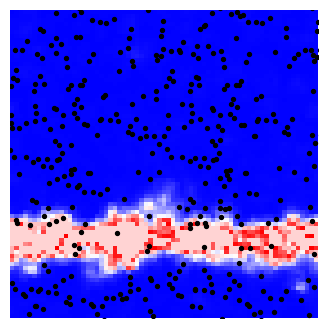

In [249]:
if eval(confParser['flags']['DminAnalysis']) and eval(confParser['flags']['VorAnl']):

#     PlotDminVor( lmpVor, lmpDmin, 
#                  times = [itime], #[2000000],#list(lmpData.coord_atoms_broken.keys()),
#                 title='d2minBad',
#                )
    itime = eval(confParser['parameters']['itime'])
    itime0 = eval(confParser['parameters']['itime0'])

    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))

    #
    (xlin, ylin, zlin), (xv, yv, zv), mu_intrp = utl.IntrpScatter(
                    d2min, box, 'd2min',
                    vor,
                    Plot = True,
                    title='VorAnl/d2min_ico_annealed.png',
                    ticklabels = False,
                    colorbar = False,
                    zscore = True,
                    color='black',
                    s=8,
                   )
    

## SRO density

InputFile= junk.xyz
OutputFile= VoronoiFiltrd.xyz
nevery 1
InputFile= junk.xyz
num_frames= 1
frame=0/1
cxy= -0.3109165771937807


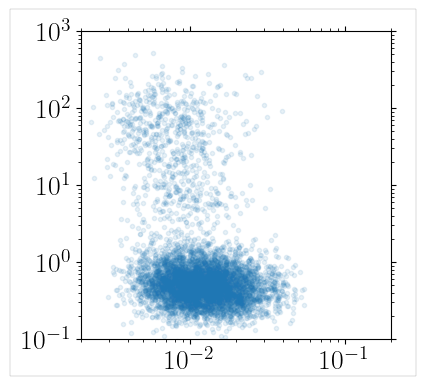

In [250]:
if eval(confParser['flags']['DminAnalysis']) and eval(confParser['flags']['VorAnl']):
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    #
    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    #
    d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )
    #
    types = list(map(int,confParser['props']['types'].split()))
    radii = list(map(float,confParser['props']['AtomicRadius'].split()))
    AtomicRadius = dict(list(zip(types,radii)))

    rho = utl.sroDensityDiscrete( vor, box,
                              AtomicRadius,
                                pypath=pypath,
                                )
    #              
    filtr = rho > 0
    vor.tmp = rho[filtr]
    d2min.tmp = d2min.d2min[filtr]
    #

#    x, y = utl.Zscore(np.log10(vor.tmp)), utl.Zscore(np.log10(d2min.tmp))
    x, y = vor.tmp, d2min.tmp
#    xb, yb, err_x, err_y = utl.GetBinnedAverage( x, y, nbins = 16 )

    symbols=Symbols()
    ax = utl.PltErr(x,y,
               attrs={'fmt':'.','alpha':.1,'zorder':1},
                    Plot=False,
              )

    utl.PltErr(None,None,#xb,yb,yerr=err_y,
               attrs=symbols.GetAttrs(count=1,zorder=10),
               ax=ax,
               ylim=(1e-1,1e3),xlim=(2e-3,2e-1),
                    Plot=False,
                  title='VorAnl/scatter_D2min_Rho_Annealed.png',
              DrawFrame=DRAW_FRAME,
              xscale='log',yscale='log',
              )

    x, y = utl.Zscore(np.log10(vor.tmp)), utl.Zscore(np.log10(d2min.tmp))
    crs = utl.CrssCrltn( x,y ) #utl.ScatterXY(  vor, d2min,
#                 Plot = True, 
#                 PLOT_AVERAGE = False,
# #                xscale='log',yscale='log',
# #                axisLabels = True,
# #                xlim=(1e-3,1e-1,1e-1,1e3),
#                 zscore = True,
#                 title = 'scatterD2minRhoBad2nd.png', 
#                 )                      
    print('cxy=',crs)    
    #--- save
    strn = utl.GetStrain(lmpData, 
                     times = itime, #list(lmpData.coord_atoms_broken.keys()), 
                     time0 = 0 )
    np.savetxt('VorAnl/crsD2minRhoSro.txt',
               np.c_[strn,crs], 
               header='gamma\tCrltnCoeff')


### cxy evolution

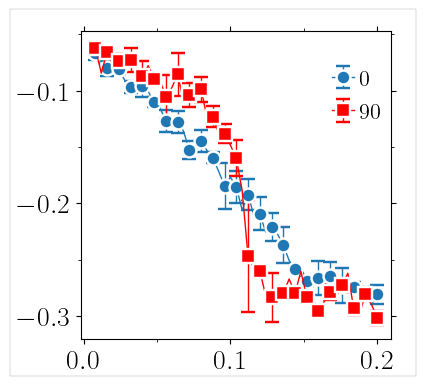

In [255]:
if eval(confParser['flags']['DminAnalysis']) and not eval(confParser['flags']['RemoteMachine']):
    Age ={
           0:0,
             1:1,
             2:2,
             3:3,
             4:4,
             5:5,
             6:6,
             7:7,
             8:8,
              9:9,
         }
    
    
    ndump =100;GammaXY=0.2;dt=1e-3;GammaDot=1.0e-04;
    Nstep=np.floor(GammaXY/dt/GammaDot);Nevery=np.ceil(Nstep/ndump)
    Times = dict(zip(range(ndump+1), np.arange(0,Nstep+Nevery,Nevery,dtype=int)))
    !rm VorAnl/crsD2minRhoSro_age*.txt
    for key_age in Age:
#          for key_d in DF:
         for key_t in Times:
             if key_t % 2 == 0:
            #---	
            #---	densities
                for irun in [0,1,2]:
                    try:
                        data = np.loadtxt('cxy/glassCo5Cr2Fe40Mn27Ni26/age%s/itime%s/Run%s/VorAnl/crsD2minRhoSro.txt'%(key_age,key_t,irun)) #--- change job
                        with open('VorAnl/crsD2minRhoSro_age%s_irun%s.txt'%(key_age,irun),'a') as fp:
                            np.savetxt(fp,np.c_[data].T)
                    except:
                        continue

                        
    temp = Temperature(
        [0,9],[list(range(3))]*10,
#        [5],[[0]]*10,
#         verbose = True,
                     )
    #
    #--- parse data
    temp.Parse( list(map(lambda x:'VorAnl/crsD2minRhoSro_age%s_irun%s.txt'%(x[0],x[1]),
                        temp.temps_runs )),
               skip_rows=1,
             )
    
    temp.EnsAverage()

    #
    #--- plot
    dump_every=100;nevery=100;dt=1e-3;factor=dump_every*nevery*dt
    #
    symbols=Symbols()
    #
    legend=Legends()
    legend.Set(fontsize=16,labelspacing=0.6,
               bbox_to_anchor=(.53,0.44,0.5,0.5),
              )
    ax = utl.PltErr(None,None,Plot=False,attrs={})
    xdata_column=0;ydata_column=1
    for age, indx in zip(temp.temps,range(len(temp.temps))):
        xdata = temp.data_averaged[age][1:,xdata_column]
        ydata = temp.data_averaged[age][1:,ydata_column]
        yerr  = temp.data_averaged[age][1:,2]
        utl.PltErr(xdata,ydata, yerr = yerr,
                  attrs=symbols.GetAttrs(count=indx%7,nevery=2,label=r'$%d$'%(age*factor),linewidth=1),
                   ax=ax,
                   Plot=False,
                  )

    utl.PltErr(None,None, attrs={},
#                xstr=r'$\gamma_{xy}$',
#                ystr=r'$\sigma_{xy}$(Gpa)',
               ax=ax,
               legend=legend.Get(),
               title = 'png/cxy_strain_age.png',
               Plot=False,
#               ylim=(-0.1,4),
              DrawFrame=DRAW_FRAME,
              )

### kde

In [84]:

    
# if eval(confParser['flags']['DminAnalysis']) and eval(confParser['flags']['VorAnl']):
#     #--- cross crltn.
#     x = xyzv[:,0]#np.array(vor.tmp)
#     y = xyzv[:,1]#np.array(d2min.tmp)
#     #---

# #    y=y[x>0]
# #    x=x[x>0]

#     attrs={
#           'xlabel' : r'$x$(\r{A})', 'ylabel' : r'$y$(\r{A})',
# #          xlim=np.array([xv.min(),xv.max()]),ylim=np.array([yv.min(),yv.max()]),
#           'zscore' : True,
#           'frac' : 1.0, #--- plot a patch
#           'title' : 'kdeRhoBad.png',
# #          'colorbar':True,
#           'labels' : True,
#           'color':'black',
# #                     DrawFrame=[0.2,0.09,0.15,0.06,0.04],
#     }
# #    utl.DensityMap2d(np.log10(x), np.log10(y),**attrs)
#     utl.DensityMap2d(x, y,**attrs)


### multiple frames

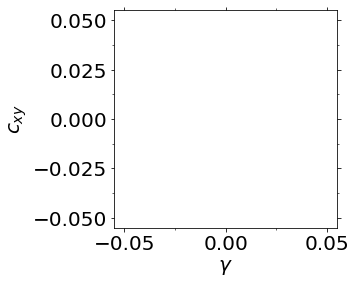

In [85]:
def vor(x):
    box = lp.Box( BoxBounds = lmpData.BoxBounds[x], AddMissing = np.array([0.0,0.0,0.0] ))
    tmp = lp.Atoms( **lmpVor.coord_atoms_broken[x].to_dict(orient='series') )
    rho = sroDensityDiscrete( tmp, box,
                              AtomicRadius )
    tmp.tmp = rho
    return tmp
#
def d2min(x):
    tmp = lp.Atoms( **lmpDmin.coord_atoms_broken[x].to_dict(orient='series') ) 
    tmp.tmp = tmp.d2min
    return tmp

if eval(confParser['flags']['DminAnalysis']) and eval(confParser['flags']['VorAnl']):
    #
    times = list(lmpDmin.coord_atoms_broken.keys())
    times.sort()
    times.pop(0)

    crs = map(lambda x:ScatterXY(  vor(x), d2min(x),
                Plot = False, 
                PLOT_AVERAGE = False,
                ),times)                     
    
    #--- save
    ydata = np.array(list(crs))
    xdata = np.array(list(map(lambda x:GetStrain(lmpData, x, 0 ),times)))
    np.savetxt('crsD2minRhoSro.txt',
               np.c_[xdata,ydata], 
               header='gamma\tCrltnCoeff')
    

    #--- plot
    utl.PltErr(xdata,
           ydata,
           yerr=None,
#      ylim=[0,5],
       ystr='$c_{xy}$',
       xstr='$\gamma$',
#       yscale='log',
#       xscale='log',
#       title='dmin_gamma.png'
      )

### multiple systems

In [86]:
if not eval(confParser['flags']['RemoteMachine']):
    PlotPaperVersion(
                        pathh_indx = 2,
                        file0_indx = 4,
                        #
                        title='cxyGamma2nd.png',
#                        xlabel=r'$\gamma$',
#                        ylabel=r'cxy',
                        ylim=(-0.4,0),
                        xlim=(0.0,.21),
                        legend = True,
#                        yscale='log',
                        borderwidth = 0.001,
                        PlotMean = True,
                      )

### hmin and cxy

In [87]:
if not eval(confParser['flags']['RemoteMachine']):
    
    PlotPaperVersionScatter( 2, #--- path:
                            xindx=4, colx = 1, #--- x: cxy (2nd column)
                            yindx=5, coly = 1, #--- y: hmin( 2nd column)
#                        xlabel=r'$c_{xy}$',
#                        ylabel=r'$h_{min}$',
                        title='hCxy2nd.png',
                         xlim=(-0.4,-0.2),
                        ylim=(-40.0,-10.0),
#                        legend = True,
#                        yscale='log',
                        borderwidth = 0.001,
                        fontsize = 20,
                            
                           )


# Local Moduli
+ analysis of local modulus fluctuations
+ output files in "ModuAnl" directory

In [88]:
LAOS = eval(confParser['modulus analysis']['LAOS'])
Down = eval(confParser['modulus analysis']['Down'])
Up   = eval(confParser['modulus analysis']['Up'])
os.system('mkdir ModuAnl')

0

## parse data

In [89]:
if eval(confParser['flags']['ModuAnl']) and Down and not Up:
    path = confParser['input files']['path']
    t0=time.time()    
    #--- read initial atomic positions/stresses
    atomi, boxi = utl.GetAtoms( '%s/dump_init.xyz'%path, nevery = 1 ) #--- change it to 1
    atoms0 = utl.GetTimeAverageAtom( atomi ) #--- argument: dic with key: time and val: atom object
    #
    itimee0 = list(atomi.keys())[0]
    box0=boxi[itimee0]
    #
    atomd = {}
    boxd = {}
    ebulk = {}
    #--- read data for deformed configurations
    #for dirr, mode in zip(range(1,7),['xx','yy','zz','yz','xz','xy']):
    for dirr, mode in zip([6],['xy']):
        atomt, boxt = utl.GetAtoms( '%s/dumpDown_%s.xyz'%(path,dirr), nevery=1 )
        atomt.pop(0) #--- time 0 is not equilibrated!
        atomd[mode] = utl.GetTimeAverageAtom( atomt )
        #
        itimee0 = list(atomt.keys())[0]
        boxd[mode] = boxt[itimee0]
        #
        #--- evaluate strain
        if dirr == 1 or dirr == 2 or dirr == 3:
            indxi = dirr - 1
            indxj = dirr - 1
        elif dirr == 6: #--- xy
            indxi = 0
            indxj = 1
        dx=boxd[mode].CellVector[indxi,indxj]-box0.CellVector[indxi,indxj]
        l0=box0.CellVector[indxj,indxj]        
        ebulk[mode] = dx/l0    
    ebulk['yz']=ebulk['xz']=ebulk['xy']
    print('ebulk=',ebulk)
    #
    print('duration=%s s'%(time.time()-t0))

In [90]:
if eval(confParser['flags']['ModuAnl']) and Up and Down:
    path = confParser['input files']['path']
    t0 = time.time()
    modDataInit = lp.ReadDumpFile( '%s/dump_init.xyz'%path )
    modDataUp   = lp.ReadDumpFile( '%s/dumpUp_6.xyz'%path )
    modDataDown = lp.ReadDumpFile( '%s/dumpDown_6.xyz'%path )
    modDataInit.GetCords( ncount = sys.maxsize, 
                     columns = {'c_peratom[4]':'sxy'},
                    )
    modDataUp.GetCords( ncount = sys.maxsize, 
                     columns = {'c_peratom[4]':'sxy'},
                    )
    modDataDown.GetCords( ncount = sys.maxsize, 
                     columns = {'c_peratom[4]':'sxy'},
                    )
    print('duration=%s s'%(time.time()-t0))
    print('timesteps=',modDataInit.coord_atoms_broken.keys())

In [91]:
if eval(confParser['flags']['ModuAnl']) and LAOS:
    t0 = time.time()
    path = confParser['input files']['path']
    modData = lp.ReadDumpFile( '%s/shearOscillation.xyz'%path )
    modData.GetCords( ncount = sys.maxsize, 
    #                 columns = {'c_mystress[4]':'sxy'},
    #                 columns = {'c_mystress1':'sxx','c_mystress2':'syy','c_mystress3':'szz','c_mystress4':'sxy'},
                     columns = {'c_1[4]':'sxy'},
                    )
    print('duration=%s s'%(time.time()-t0))
    modData.coord_atoms_broken.keys()

In [92]:
def AddVolumes(inputt,neveryy = 100):
    os.system('ovitos OvitosCna.py %s %s %s %s %s %s %s'\
              %(inputt,'ModuAnl/Voronoi.xyz',neveryy,3,0.0,0.0,0.0))  
    ovtData = lp.ReadDumpFile( 'ModuAnl/Voronoi.xyz' )
    ovtData.GetCords( ncount = sys.maxsize)
    #--- insert column
    return ovtData.coord_atoms_broken[0]['AtomicVolume'].to_list()

def AddColumnn(modDataInit,col, val):
    times = modDataInit.coord_atoms_broken.keys()
    loc=len(modDataInit.coord_atoms_broken[0].keys())
    #modData.coord_atoms_broken[0].drop(['AtomicVolume'], axis=1,inplace=True)
    list(map(lambda x:modDataInit.coord_atoms_broken[x].insert(loc, col, val),times))
    
if eval(confParser['flags']['ModuAnl']):
    path = confParser['input files']['path']
    if Up and Down:
        val = AddVolumes('%s/dump_init.xyz'%path)
        AddColumnn(modDataInit,'AtomicVolume', val)
        AddColumnn(modDataUp,'AtomicVolume', val)
        AddColumnn(modDataDown,'AtomicVolume', val)    
        print(modDataInit.coord_atoms_broken[0].head())
    if LAOS:
        val = AddVolumes('%s/shearOscillation.xyz'%path)
        AddColumnn(modData,'AtomicVolume', val)
        print(modData.coord_atoms_broken[0].head())
    

### Plot

In [93]:
latexx = eval(confParser['flags']['RemoteMachine']) == False
if eval(confParser['flags']['ModuAnl']) and LAOS:
    times = modData.coord_atoms_broken.keys()

    func_sxy = lambda x: np.sum(lp.Atoms( **modData.coord_atoms_broken[x].to_dict(orient='series') ).sxy)/\
                         utl.GetVolume(modData,x)
    Virial = np.array(list(map(func_sxy,times)))*1.0e-04
    strainDump = np.array(list(map(lambda x: utl.GetStrain(modData,x,0),times)))
    #
    PltErr(strainDump,Virial,
           yerr=None,
    #      ylim=[0,5],
           xstr=r'$\gamma$',
           ystr=r'$\sigma$(Gpa)',
          )


    xarray=np.loadtxt('loadCurve.txt')
    ax=PltErr(xarray[:,0],xarray[:,1],Plot=False)
    eps = GetStrain(lmpData,itime,0)
    #eps=0.9*0.2 #--- itime=90
    ax=utl.PltErr(strainDump[0]+eps, Virial[0],
           Plot=False,
           attrs={'fmt':'-.o','color':'black'},
           ax=ax,
          )
    PltErr(strainDump+eps, Virial,
           Plot=True,
           ax=ax,
           xlim=(eps-strainDump.max(),eps+strainDump.max()),
           ylim=(Virial.min()-Virial.std(),Virial.max()+Virial.std()),
           attrs={'fmt':'-.r'},
          xstr=r'$\gamma$' if latexx else '',
           ystr=r'$\sigma$(Gpa)' if latexx else '',
          )
    print('mu=%s Gpa'%(np.polyfit(strainDump, Virial, 1)[0]))

In [94]:
def Wrapper(modData):
    times = modData.coord_atoms_broken.keys()

    func_sxy = lambda x: np.sum(lp.Atoms( **modData.coord_atoms_broken[x].to_dict(orient='series') ).sxy)/\
                         utl.GetVolume(modData,x)
    Virial = np.array(list(map(func_sxy,times)))*1.0e-04
    strainDump = np.array(list(map(lambda x: utl.GetStrain(modData,x,0),times)))
    return strainDump, Virial

# def GetStrainn(box): #0,box ):
#     ebulk = {}
#     #--- bulk strain
#     dx=box.CellVector[0,1]#-box0.CellVector[0,1]
#     l1=box.CellVector[1,1]
#     ebulk = dx/l1
#     return ebulk

def func(x,a,b):
    return a*x+b

if eval(confParser['flags']['ModuAnl']) and Up and Down:
    latexx = eval(confParser['flags']['RemoteMachine']) == False

    #--- average mu (system-wise)
    
    strainDump, VirialInit = Wrapper(modDataInit)
    strainUp, VirialUp = Wrapper(modDataUp)
    strainDown, VirialDown = Wrapper(modDataDown)
    
    dgammaUp = GetStrainn( lp.Box( BoxBounds = modDataInit.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ) ),
                   lp.Box( BoxBounds = modDataUp.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ) ))
    dgammaDown = GetStrainn( lp.Box( BoxBounds = modDataInit.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ) ),
                   lp.Box( BoxBounds = modDataDown.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ) ))

    #
    strainDump = np.concatenate([strainDump,dgammaUp*np.ones(len(strainDump)),dgammaDown*np.ones(len(strainDump))])
    Virial = np.concatenate([VirialInit, VirialUp, VirialDown] )
    ax=utl.PltErr(strainDump, Virial,
           yerr=None,
    #      ylim=[0,5],
           xstr=r'$\gamma$',
           ystr=r'$\sigma$(Gpa)',
           attrs={'fmt':'.'},
            Plot=False,
          )
    print('mu=%s Gpa'%(np.polyfit(strainDump, Virial, 1)[0]))
    utl.PltErr(strainDump, func(strainDump,*np.polyfit(strainDump, Virial, 1)),
       yerr=None,
#      ylim=[0,5],
       xstr=r'$\gamma$' if latexx else '',
       ystr=r'$\sigma$(Gpa)' if latexx else '',
       attrs={'fmt':'-.r'},
       ax=ax,
       title='perturbFit.png'
      )

    #---
#     xarray=np.loadtxt('%s/loadCurve.txt')
#     ax=utl.PltErr(xarray[:,0],xarray[:,1],Plot=False)
#     eps = GetStrain(lmpData,itime,0)
#     #eps=0.9*0.2 #--- itime=90
#     ax=utl.PltErr(strainDump[0]+eps, Virial[0],
#            Plot=False,
#            attrs={'fmt':'-.o','color':'black'},
#            ax=ax,
#            title='perturbYield.png'
#           )
#     utl.PltErr(strainDump+eps, Virial,
#            Plot=True,
#            ax=ax,
#            xlim=(eps-8*strainDump.max(),eps+8*strainDump.max()),
#            ylim=(Virial.min()-Virial.std(),Virial.max()+Virial.std()),
#            attrs={'fmt':'or'},
#           xstr=r'$\gamma$',
#            ystr=r'$\sigma$(Gpa)',
#            title='perturb.png'
#           )


In [95]:
# #--- x,y bounds
# xlo=0;xhi=1e-5
# filtr=np.all([sarray[:,0]>=xlo,sarray[:,0]<xhi],axis=0)
# ylo=sarray[:,1][filtr].min()
# yhi=ylo=sarray[:,1][filtr].max()

# PltErr(sarray[:,0],sarray[:,1],
#       xlim=(xlo,xhi),
#        ylim=(ylo,yhi)
#       )

# ax=PltErr(sarray[:,0],sarray[:,1],Plot=False)
# eps = GetStrain(lmpData,itime,0)
# #eps=0.9*0.2 #--- itime=90
# ax=PltErr(strainDump[0]+eps, Virial[0],
#        Plot=False,
#        attrs={'fmt':'-.o','color':'black'},
#        ax=ax,
#       )
# PltErr(strainDump+eps, Virial,
#        Plot=True,
#        ax=ax,
#        xlim=(eps-0.002,eps+0.002),
#        ylim=(Virial.min()-Virial.std(),1.5*Virial.max()+Virial.std()),
#        attrs={'fmt':'-.r'},
#       xstr=r'$\gamma$',
#        ystr=r'$\sigma$(Gpa)',
#       )

In [96]:
# def GetStrainn(box0,box ):
#     ebulk = {}
# #    box0 = lp.Box( BoxBounds = lmpData.BoxBounds[time0], AddMissing = np.array([0.0,0.0,0.0] ))
#     if 1:
# #    for itime in times:
# #        itime = times
# #        box = lp.Box( BoxBounds = lmpData.BoxBounds[itime],AddMissing = np.array([0.0,0.0,0.0] ))
#         #
#         #--- bulk strain
#         dx=box.CellVector[0,1]-box0.CellVector[0,1]
#         l1=box.CellVector[1,1]
#         ebulk = dx/l1
#     return ebulk

# #--- debuging: stress perturbation
# pathhh=path #'/Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/testRuns/Preparation'
# atomi, boxi = GetAtoms( '%s/dump_init.xyz'%pathhh, nevery = 1 ) #--- change it to 1
# atomf, boxf = GetAtoms( '%s/dump_def6.xyz'%pathhh, nevery = 1 ) #--- change it to 1

# #--- volumes
# CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( boxi[0].CellVector )
# voli= np.linalg.det( CellVectorOrtho )
# CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( boxf[0].CellVector )
# volf= np.linalg.det( CellVectorOrtho )

# #--- initial and final stress
# s0=list(map(lambda x:pd.DataFrame(atomi[x].__dict__).sxy.sum()*1e-4, atomi.keys()))/voli
# s1=list(map(lambda x:pd.DataFrame(atomf[x].__dict__).sxy.sum()*1.0e-4, atomf.keys()))/volf
# ax=PltErr(atomi.keys(),s0,Plot=False)
# PltErr(atomf.keys(),s1,ax=ax,attrs={'fmt':'.-r'})

# #--- strain step
# dgamma=GetStrainn(boxi[0],boxf[0] )
# eps = GetStrain(lmpData,itime,0)

# xarray=np.loadtxt('loadCurve.txt')
# ax=PltErr(xarray[:,0],xarray[:,1],Plot=False)
# #eps=0.9*0.2 #--- itime=90
# PltErr(np.ones(len(s0))*eps,s0,Plot=False,ax=ax)
# PltErr(np.ones(len(s0))*(eps+dgamma),s1,Plot=False,ax=ax,xlim=(0.96*eps,1.04*eps)) #,ylim=(0.5,1))



## elastic constants

In [97]:
if eval(confParser['flags']['ModuAnl']) and Down and not Up:
    cfac = 1.0e-4 #--- bar to gpa
    dxx={}
    dyy={}
    dzz={}
    dyz={}
    dxz={}
    dxy={}
    for mode in ['xy']: #['xx','yy','zz','yz','xz','xy']:
        dxx[mode]=(atomd[mode].sxx/atomd[mode].AtomicVolume-atoms0.sxx/atoms0.AtomicVolume)/ebulk[mode]*cfac
        dyy[mode]=(atomd[mode].syy/atomd[mode].AtomicVolume-atoms0.syy/atoms0.AtomicVolume)/ebulk[mode]*cfac
        dzz[mode]=(atomd[mode].szz/atomd[mode].AtomicVolume-atoms0.szz/atoms0.AtomicVolume)/ebulk[mode]*cfac
        dyz[mode]=(atomd[mode].syz/atomd[mode].AtomicVolume-atoms0.syz/atoms0.AtomicVolume)/ebulk[mode]*cfac
        dxz[mode]=(atomd[mode].sxz/atomd[mode].AtomicVolume-atoms0.sxz/atoms0.AtomicVolume)/ebulk[mode]*cfac
        dxy[mode]=(atomd[mode].sxy/atomd[mode].AtomicVolume-atoms0.sxy/atoms0.AtomicVolume)/ebulk[mode]*cfac

In [98]:
def func(x,a,b):
    return a*x+b

def GetModulus(atomid,modData, Plot=False):
    times = modData.coord_atoms_broken.keys()

    func_sxy = lambda x: modData.coord_atoms_broken[x].iloc[atomid].sxy/\
                         modData.coord_atoms_broken[x].iloc[atomid].AtomicVolume
    
    Virial = np.array(list(map(func_sxy,times)))*1.0e-04
    strainDump = np.array(list(map(lambda x: utl.GetStrain(modData,x,0),times)))
    #--- fit
    z = np.polyfit(strainDump, Virial, 1)
    
    
    if Plot:
        ax=PltErr(strainDump,Virial,
                  Plot=False,
              )
        PltErr(strainDump,func(strainDump,*z),
               ax=ax,
               yerr=None,
        #      ylim=[0,5],
               xstr=r'$\gamma$',
               ystr=r'$\sigma$(Gpa)',
               attrs={'fmt':'-r'}
              )
        
    return z[0]

if eval(confParser['flags']['ModuAnl']) and LAOS:
    #--- fit
    junk = GetModulus(0,modData, Plot=True)
    
    times = modData.coord_atoms_broken.keys()
    
    virials = np.c_[list(map(lambda x: 1.0e-04*modData.coord_atoms_broken[x].sxy/\
                          modData.coord_atoms_broken[x].AtomicVolume,times))]
    strainDump = np.array(list(map(lambda x: utl.GetStrain(modData,x,0),times)))
    gmodu = list(map(lambda x:np.polyfit(strainDump, x, 1)[0],virials.T))
    
    #--- add columns
    loc=len(modData.coord_atoms_broken[0].keys())
    val = gmodu
    #modData.coord_atoms_broken[0].drop(['AtomicVolume'], axis=1,inplace=True)
    modData.coord_atoms_broken[0].insert(loc, 'C66', val)
    print(modData.coord_atoms_broken[0].head())
    #--- atom object
    atomm = lp.Atoms(**modData.coord_atoms_broken[0])
    print('mu=%s Gpa'%(atomm.C66.mean()))

In [99]:
def func(x,a,b):
    return a*x+b

def Wrapper(atomid,modData):
    times = modData.coord_atoms_broken.keys()
    func_sxy = lambda x: modData.coord_atoms_broken[x].iloc[atomid].sxy/\
                         modData.coord_atoms_broken[x].iloc[atomid].AtomicVolume
    
    Virial = np.array(list(map(func_sxy,times)))*1.0e-04
    strainDump = np.array(list(map(lambda x: utl.GetStrain(modData,x,0),times)))
    return strainDump, Virial
    
def GetModulus(atomid,modDataInit,modDataUp,modDataDown, Plot=False):

    strainDump, VirialInit = Wrapper(atomid,modDataInit)
    strainUp, VirialUp = Wrapper(atomid,modDataUp)
    strainDown, VirialDown = Wrapper(atomid,modDataDown)
    
    dgammaUp = GetStrainn( lp.Box( BoxBounds = modDataInit.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ) ) ,
                   lp.Box( BoxBounds = modDataUp.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ) ))
    dgammaDown = GetStrainn( lp.Box( BoxBounds = modDataInit.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ) ),
                   lp.Box( BoxBounds = modDataDown.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ) ))

    #
    strainDump = np.concatenate([strainDump,dgammaUp*np.ones(len(strainDump)),dgammaDown*np.ones(len(strainDump))])
    Virial = np.concatenate([VirialInit, VirialUp, VirialDown] )

    
    #--- fit
    z = np.polyfit(strainDump, Virial, 1)
    
    
    if Plot:
        ax=utl.PltErr(strainDump,Virial,
                  Plot=False,
              )
        utl.PltErr(strainDump,func(strainDump,*z),
               ax=ax,
               yerr=None,
        #      ylim=[0,5],
               xstr=r'$\gamma$' if latexx else '',
               ystr=r'$\sigma$(Gpa)' if latexx else '',
               attrs={'fmt':'-r'}
              )
        
    return z[0]

if eval(confParser['flags']['ModuAnl']) and Up and Down:
    latexx = eval(confParser['flags']['RemoteMachine']) == False
    
    #--- atom-wise modulus
    #--- fit: atom id = 0
    junk = GetModulus(0,modDataInit,modDataUp,modDataDown, Plot=True)
    

    times = modDataInit.coord_atoms_broken.keys()
    #--- atom-wise virials
    virialsInit = np.c_[list(map(lambda x: 1.0e-04*modDataInit.coord_atoms_broken[x].sxy/\
                      modDataInit.coord_atoms_broken[x].AtomicVolume,times))]
    print('virialsInit.shape=',virialsInit.shape)
    virialsUp = np.c_[list(map(lambda x: 1.0e-04*modDataUp.coord_atoms_broken[x].sxy/\
                      modDataUp.coord_atoms_broken[x].AtomicVolume,times))]
    virialsDown = np.c_[list(map(lambda x: 1.0e-04*modDataDown.coord_atoms_broken[x].sxy/\
                      modDataDown.coord_atoms_broken[x].AtomicVolume,times))]

    virials = np.concatenate([virialsInit,virialsUp,virialsDown],axis=0)
    print('virials.shape=',virials.shape)
    
    boxInit = lp.Box( BoxBounds = modDataInit.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ))
    boxUp = lp.Box( BoxBounds = modDataUp.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ) )
    boxDown = lp.Box( BoxBounds = modDataDown.BoxBounds[0],\
                        AddMissing = np.array([0.0,0.0,0.0] ) )
                     
    dgammaUp = GetStrainn(boxInit , boxUp)
    dgammaDown = GetStrainn( boxInit , boxDown)
    #
    strainDump = np.concatenate([np.zeros(len(times)),dgammaUp*np.ones(len(times)),dgammaDown*np.ones(len(times))])
    print('strainDump.shape=',strainDump.shape)

    
    gmodu = list(map(lambda x:np.polyfit(strainDump, x, 1)[0],virials.T))
    
#     #--- add columns
    modData = modDataInit
    loc=len(modData.coord_atoms_broken[0].keys())
    val = gmodu
#     if 'C66' in modData.coord_atoms_broken[0].keys():
#         modData.coord_atoms_broken[0].drop(['C66'], axis=1,inplace=True)
    modData.coord_atoms_broken[0].insert(loc, 'C66', val)
    print(modData.coord_atoms_broken[0].head())
    #--- atom object
    atomm = lp.Atoms(**modData.coord_atoms_broken[0])
    print('mu=%s Gpa'%(atomm.C66.mean()))

### output dump

In [100]:
if eval(confParser['flags']['ModuAnl']) and Down and not Up:
    df=pd.DataFrame(atoms0.__dict__)
    cols = list(df.keys())+['C66'] # + ['C55'] + ['C44']#--- C66 is cxyxy
    df = pd.DataFrame(np.c_[df,dxy['xy'],
    #                        dxz['xz'],
    #                        dyz['yz']
                           ],
                      columns=cols)
    atomm = lp.Atoms(**df)
    wd = lp.WriteDumpFile(atomm, box0)
    wd.Write('ModuAnl/dump.xyz',
             attrs=['id', 'type','x', 'y', 'z', 'sxx', 'syy', 'szz', 'sxy', 'sxz', 'syz',
                   'AtomicVolume', 'C66'],
             fmt='%i %i %15.14e %15.14e %15.14e %4.3e %4.3e %4.3e %4.3e %4.3e %4.3e %4.3e %4.3e')
#    os.system('tar czf dump.gz dump.xyz')

#### append

In [101]:
# if not eval(confParser['flags']['RemoteMachine']):
#     try:
#         os.system('rm Modu.xyz')
#     except:
#         pass
#     for i in range(200):
#         os.system('tar xzf FeNiT300Elasticity%s/Run1/dump.gz'%(i))
#         os.system('cat dump.xyz >> Modu.xyz')
# #        os.system('cat FeNiT300Elasticity%s/Run1/dump.xyz >> Modu.xyz'%(i))

### map

In [102]:
# itime = times[strainDump>=ey][0]
# print('itime(peak)=%s'%itime)    
# itime = times[strainDump>=em][0]
# print('itime(max. drop)=%s'%itime)
# itime = times[strainDump>=ef][0]
# print('itime(flow)=%s'%itime)
#itime=0

In [103]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):

    itime = eval(confParser['parameters']['itime0'])
    box0 = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ) ) #--- reference state

    (xlin, ylin, zlin), (xv, yv, zv), d2intrp = utl.Intrp(atomm, box0, 'C66',
                    Plot = True,
                    title='ModuAnl/mapCxyxy.%s.png'%itime,
#                    cmap='Greys',
#                    colorbar=True,
                    zscore=True,
                    DrawFrame=(0.21,0.06,0.15,0.06,0.1),
                    xlabel = '', ylabel = '',
#                    vmin=,vmax=,
                   )

## crltn with D2min 

In [104]:
# if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']) :
#     #--- d2min associated with the perturbed states
#     refs='%s/dump_init.xyz'%path
#     curr='%s/dump_def%s.xyz'%(path,6)
#     !rm 'd2min.xyz'
#     !ovitos OvitosCna.py $curr 'd2min.xyz' 1 2 $refs
#     #--- read from d2min.xyz
#     lmpDmin = lp.ReadDumpFile( 'd2min.xyz' )
#     lmpDmin.GetCords( ncount = sys.maxsize, columns = {'NonaffineSquaredDisplacement':'d2min'} )

In [105]:
class ModuD2minCrltn:
    
    def __init__(self,verbose=False):
        self.verbose=verbose
        #
    def OpenFile(self):
        !mkdir ModuAnl
        self.sfile = open('ModuAnl/junk.xyz','w')
        self.sfile.close()
        #
    def Parse(self,fileName):
        if self.verbose:
            print('parsing %s'%fileName)
        lmpData_ref = lp.ReadDumpFile(fileName)
        lmpData_ref.GetCords( ncount = sys.maxsize
                        )
        return lmpData_ref
    
    def Combine(self,lmpData_ref,key,kount):
        if self.verbose:
            print('appending ... ')
        #--- make atom object

        atoms_ref = lp.Atoms(**lmpData_ref.coord_atoms_broken[key].to_dict(orient='series'))
        box_ref=lp.Box(BoxBounds=lmpData_ref.BoxBounds[key])


        self.sfile = open('ModuAnl/junk.xyz','a')
        wdf = lp.WriteDumpFile(atoms_ref, box_ref)
        wdf.Write(self.sfile, itime=kount)
        self.sfile.close()
        #
    def D2min(self,lmpData_new,
              reference_frames,
              current_frames,
             dim):
        if self.verbose:
            print('current_frames=',current_frames)
            print('reference_frames=',reference_frames)
        #--- call function
        try:
            os.system('rm D2minAnl/d2min.xyz')
        except:
            pass
        utl.WrapperD2min(lmpData_new,
                         reference_frames,
                         current_frames,
                         dim=dim)
        #--- parse
        lmpDmin = lp.ReadDumpFile( 'D2minAnl/d2min.xyz' )
        lmpDmin.GetCords( ncount = sys.maxsize, columns = {'NonaffineSquaredDisplacement':'d2min'} )
        return lmpDmin
        
    def Plot(self,lmpData_ref,key0,lmpDmin,key):
        box0 = lp.Box( BoxBounds = lmpData_ref.BoxBounds[key0],AddMissing = np.array([0.0,0.0,0.0] ))
        atom = lp.Atoms( **lmpDmin.coord_atoms_broken[key].to_dict(orient='series') )
        #---
        PlotAttrs = {
    #                'zscore' : False,
    #                'scale' : 'log',
                    'xlabel' : '', #r'$x$(\r{A})', 
                    'ylabel' : '', #r'$y$(\r{A})',
    #                'DrawFrame':(0.17,0.17,0.15,0.06,0.1),
                    'colorbar':True,
                    'labels' : True,
    #                'vmin':-0.5,
    #                'vmax':+2.1,
                    'fontsize':18,
                    'interpolation':'bilinear',
                    }
        junk, junk, d2intrp = utl.Intrp(atom, box0,
                        attr = 'd2min',
                        Plot = True,
                        title='D2minAnl/map_d2min.png',
                        **PlotAttrs
                        )
    def PDF(self,lmpDmin,key):
        d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[key].to_dict(orient='series') )
        hist, edges2, error = utl.GetPDF(np.log10(d2min.d2min),linscale=True, n_per_decade=32)
        utl.PltErr(edges2,hist,yerr=error,
                  yscale='log',

                  ) 

    def Scatter(self,lmpDmin,key,atomm,**kwargs):
#        key = 1
        d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[key].to_dict(orient='series') )
        d2min.tmp = d2min.d2min

        atomm.tmp = atomm.C66
#        print(atomm.tmp.min())
        #
        utl.ScatterXY(  atomm,d2min,
                      **kwargs
        #            xerr = None
                    )                
    
    def Average(self,lmpDmins):
        atoms = {}
        for key in lmpDmins.keys():
            lmpDmin = lmpDmins[key]
            atoms[key] = lp.Atoms( **lmpDmin.coord_atoms_broken[1].to_dict(orient='series') )
#        slist += [atoms[key]['d2min'].iloc[0]]
#plt.hist(slist,bins=32)
#plt.show()
        return utl.GetTimeAverageAtom( atoms )


In [106]:
if eval(confParser['modulus analysis']['d2minCrltn']):
    #--- instantiate object
    mod2min = ModuD2minCrltn(verbose=True)
    #--- parse ref and current
    lmpData_ref = mod2min.Parse('%s/dump_init.xyz'%confParser['input files']['path'])
    lmpData_curr = mod2min.Parse('%s/dumpUp_6.xyz'%confParser['input files']['path'])
    #--- append in a file
    lmpDmins = {}
    for itimee in lmpData_ref.coord_atoms_broken.keys():
        mod2min.OpenFile()
        mod2min.Combine(lmpData_ref,itimee,0)
        #--- add another snapshot
        mod2min.Combine(lmpData_curr,itimee,1)
        #--- parse new file
        lmpData_new = mod2min.Parse('ModuAnl/junk.xyz')
        #--- d2min
        lmpDmins[itimee] = mod2min.D2min(lmpData_new,
                      [0],[1],
                        eval(confParser['parameters']['dimension'])
                               )
    #--- average 
    d2min_average = mod2min.Average(lmpDmins)
    lmpDmin = lmpDmins[0] #--- insert mean as a column
    lmpDmin.coord_atoms_broken[1].d2min=np.array(d2min_average.d2min)
    #--- plot d2min
    keys=list(lmpData_ref.coord_atoms_broken.keys())
    keys.sort()
    mod2min.Plot(lmpData_ref,keys[-1],lmpDmin,1)

    #--- distributions
    mod2min.PDF(lmpDmin,1)

    #--- plot mu
    # junk, (xv, yv, zv), mu_intrp = utl.Intrp(atomm, 
    #                                      lp.Box( BoxBounds = lmpData_ref.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ))
    #                                      , 'C66',
    #                 Plot = True,
    # #                title='mapCxyxy.png'
    #                )
    mod2min.Scatter(lmpDmin,1,atomm,
                        Plot = True, 
                        PLOT_AVERAGE = True,
                        nbins_per_decade = 12,
                        xscale = 'linear',
                        yscale = 'log',
                        zscore = True,
                        xlim=np.array([-1,1,-1,1])*5,
            #            title = 'scatterModuRho.png',
    #                    axisLabels=(r'$\mu$',r'$D^2_{min}$'),
                   )


In [107]:
# mod2min = ModuD2minCrltn(verbose=True)
# mod2min.Scatter(lmpDmin,1600000,atomm,
#                         Plot = True, 
#                         PLOT_AVERAGE = True,
#                         nbins_per_decade = 12,
#                         xscale = 'linear',
#                         yscale = 'log',
#                         zscore = True,
#                         xlim=np.array([-1,1,-1,1])*5,
#             #            title = 'scatterModuRho.png',
#     #                    axisLabels=(r'$\mu$',r'$D^2_{min}$'),
#                    )

In [108]:
# hist, edges2, error = utl.GetPDF( atomm.C66, linscale=True, n_per_decade=32) #[atomm.C66>0.0], #(atomm.C66+atomm.C55+atomm.C44)/3.0, #-np.mean(value))/var[key], 
# utl.PltErr(edges2,hist,yerr=error,
#           yscale='log',
          
#           ) 

In [109]:
# d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[2000000].to_dict(orient='series') )
# plt.scatter(atomm.C66,np.log10(d2min.d2min),alpha=1)

In [110]:
#     x = np.array(atomm.C66)
#     y = np.array(d2min.d2min)
#     #---

# #    y=y[x>0]
# #    x=x[x>0]

#     attrs={
#           'xlabel' : r'$x$(\r{A})', 'ylabel' : r'$y$(\r{A})',
#           'xlim':[-2,2],'ylim':[-2,2],
#           'zscore' : None,
#           'frac' : 1.0, #--- plot a patch
#           'title' : 'kdeRhoBad.png',
# #          'colorbar':True,
#           'labels' : False,
#           'color':'black',
# #                     DrawFrame=[0.2,0.09,0.15,0.06,0.04],
#     }
#     y=np.log10(y)
#     x=np.random.rand(y.shape[0])
#     utl.DensityMap2d(utl.Zscore(x), utl.Zscore(y),**attrs)

In [111]:
# filtr = np.log10(lmpDmin.coord_atoms_broken[itime]['d2min']) > -5
# d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itime][filtr].to_dict(orient='series') )
# hist,bins,err=utl.GetPDF(np.log10(d2min.d2min),linscale=True,n_per_decade=64)
# utl.PltErr(bins,hist)#,yscale='log')

In [112]:
# y=d2min.d2min #np.log10(d2min.d2min)
# x=np.random.random(y.shape[0])
# plt.scatter(x,y,alpha=0.1)
# plt.yscale('log')

### average 

In [113]:
# if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
#     #slist=[]
#     atoms={}
#     for key in lmpDmin.coord_atoms_broken.keys():
#         if key ==0:
#             continue
#         atoms[key] = lp.Atoms( **lmpDmin.coord_atoms_broken[key].to_dict(orient='series') )
# #        slist += [atoms[key]['d2min'].iloc[0]]
#     #plt.hist(slist,bins=32)
#     #plt.show()
#     d2min = GetTimeAverageAtom( atoms )

### Spatial map 

In [114]:
# #---
# if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
# #    itime=2000000
# #    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
#     #
# #     (xlin, ylin, zlin), (xv, yv, zv), d2min_intrp = IntrpScatter(
# #                     d2min, box0, 'd2min',
# #                     vor,
# #                     Plot = True,
# #                     title='scatterD2minRhoGood.png'
# #                    )
# #     (xlin, ylin, zlin), (xv, yv, zv), d2min_intrp = Intrp(
# #                     d2min, box0, 'd2min',
# #                     Plot = True,
# #                     title='D2minPerturbIntrp.%s.png'%itime
# #                    )

#     junk, (xv, yv, zv), mu_intrp = Intrp(atomm, box0, 'C66',
#                     Plot = True,
#                     title='mapCxyxy.png'
#                    )

# #     mu=(atomm.C66).mean() #((atomm.C44+atomm.C55+atomm.C66)/3).mean()
# #     mu_std=(atomm.C66).std() #((atomm.C44+atomm.C55+atomm.C66)/3).std()

# #     junk = PltBinary(
# #                         xlin,ylin,zlin, mu_intrp.C66,
# #                         box0,
# #                         mu,
# #                         cmap='Greys',
# # #                        title='negative_mu.%s.png'%itime,
# #                         #                    cmap='Greys',
# #                         zscore=False,
# #                         #                DrawFrame=(0.21,0.06,0.15,0.06,0.1),
# #                         xlabel = 'x', ylabel = 'y',
# #                         labels = True,
# #                      )

In [115]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    thresh, ratio, junk = gaussian_mixture(
                                     dict(zip([itime],[d2min.d2min])),
                                     times = [itime], 
                                     PLOT = True,
                                 )
    mu_divide = np.log10(thresh[itime])
    print('thresh=',mu_divide)

In [116]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    atomm.tmp = atomm.C66
    d2min.tmp = d2min.d2min
    #
    ScatterXY(  atomm,d2min,
                Plot = True, 
                PLOT_AVERAGE = True,
                nbins_per_decade = 12,
                xscale = 'linear',
                yscale = 'log',
                zscore = True,
                xlim=np.array([-1,1,-1,1])*5,
    #            title = 'scatterModuRho.png',
                axisLabels=(r'$\mu$',r'$D^2_{min}$'),
    #            xerr = None
                )            

## mu auto correlation

In [117]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
    #
    value = np.c_[mu_intrp.C66].reshape((ny,nx,nz))
    Crltn = GetAutoCorrelation( value )
    #
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector ) #--- box length
    #--- xy plane
    val = Crltn[:,:,0].copy()
    PltCrltn( val, 
              xlabel = '', ylabel = '',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              frac = 0.5, #--- plot a patch
              zscore = False,
              fileName = 'cxy_mu.png',
              dpi = 60
            )
    #---
    (xc, yc), (xdata0,ydata0), (xdata,ydata)=\
    PltCrltnFunc( Crltn, 
                 xv,yv,
                 fileName = 'cr_mu.png',
                 title = '',
                 cTOL = 8.0e-2,
                 dpi = 60,
                )
    #--- bulk strain
    dx=box0.CellVector[0,1]
    l1=box0.CellVector[1,1]
    ebulk = dx/l1
    #--- save
    np.savetxt('mu_length.txt',np.c_[ebulk,xc,yc],header='strain\txc\tyc')
    xc,yc

### discrete version

In [118]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    #--- neighbor list
    neigh = lmpNeigh.coord_atoms_broken[itime]
    
    #--- ij pairs
    atomiIds = np.array(neigh.id)
    atomjIds = np.array(neigh.J,dtype=int)

    #--- product of rho and mu
    df_mod = pd.DataFrame(atomm.__dict__)

    #--- zscore
    df_modi = FilterDataFrame(df_mod,key='id',val=atomiIds)
    df_modj = FilterDataFrame(df_mod,key='id',val=atomjIds)
    x = df_modi['C66']
    y = df_modj['C66']
    #---
    crltn = lp.ComputeCrltn(  atomm, box0, 
                              atomm.C66, #--- values
                              dx = 0.13)
    crltn.AutoCrltn2nd(RADIAL = True, 
                    rlist = neigh.DIST,
                    rvect = np.c_[neigh[['DX','DY','DZ']]],
                    xlist = x,
                    ylist = y
                   )
    rv, hist, err = crltn.Get()
    #--- plot
    PltErr(rv,hist,err,      
           ylim=[-0.1,0.2],#[-.1,.3],
           title='crMuMu.png',
           xstr=r'$r$(\r{A})',
          )
    #--- save
    np.savetxt('crMuMu.%s.txt'%itime,np.c_[rv, hist, err],header='r\tc(r)\terr')
    

In [119]:
# n=3*10000
# x=np.random.random(size=n)-0.5
# x=x.reshape((int(n/3),3))
# r=(x[:,0]**2+x[:,1]**2+x[:,2]**2)**.5
# v=np.random.random(size=int(n/3))
# vs = v.copy()
# np.random.shuffle(v)
# if 1:
#     crltn = lp.ComputeCrltn(  atoms, box, 
#                               atomm.C66, #--- values
#                               dx = 0.02)
#     crltn.AutoCrltn2nd(RADIAL = True, 
#                     rlist = r,
#                     rvect = x,
#                     xlist = v,
#                     ylist = vs #np.random.shuffle(v)
#                    )
#     rv, hist, err = crltn.Get()
#     #--- plot
#     PltErr(rv,hist,err,      
#            ylim=[-0.5,0.5],#[-.1,.3],
#            title='crMuMu.png',
#            xstr=r'$r$(\r{A})',
#           )
# # #plt.hist(x)
# # #plt.show()

### multiple files

In [120]:
if not eval(confParser['flags']['RemoteMachine']):
    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_ylabel(r'$\xi$',fontsize=16)
    ax.set_xlabel(r'$\gamma$',fontsize=16)
    ax.tick_params(labelsize=16)
    #
    for mg in [
                'FeNi',
                'CoNiFe',
                'CoNiCrFe',
                'CoCrFeMn',
                'CoNiCrFeMn',
                'Co5Cr2Fe40Mn27Ni26'
                ]:
    
        try:
            os.system('rm mu_size.txt')
        except:
            pass
        for i in range(0,200,10):
            os.system('cat %sT300Elasticity%s/Run1/mu_length.txt >> mu_size.txt'%(mg,i))

        sarr = np.loadtxt('mu_size.txt')
        ax.plot(sarr[:,0],0.5*(sarr[:,2]+sarr[:,1]),'-o',label=mg)
    #
    fig.legend()
    plt.savefig('crltnMuLength.png',dpi=75,bbox_inches='tight')
    #
    plt.show()


### length and hmin

In [121]:
if not eval(confParser['flags']['RemoteMachine']):
    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_xlabel(r'$\xi$',fontsize=16)
    ax.set_ylabel(r'hmin',fontsize=16)
    ax.tick_params(labelsize=16)
    #
    for mg in [
                'FeNi',
                'CoNiFe',
                'CoNiCrFe',
                'CoCrFeMn',
                'CoNiCrFeMn',
                'Co5Cr2Fe40Mn27Ni26'
                ]:
    
        try:
            os.system('rm mu_size.txt')
        except:
            pass
        try:
            os.system('rm hmin.txt')
        except:
            pass
        #
        for i in range(0,200,10):
            os.system('cat %sT300Elasticity%s/Run1/NegativeModulus.txt >> hmin.txt'%(mg,i))
            os.system('cat %sT300Elasticity%s/Run1/mu_length.txt >> mu_size.txt'%(mg,i))
        sarr = np.loadtxt('mu_size.txt')
        hmin = np.loadtxt('hmin.txt')
        #
        ax.scatter(0.5*(sarr[:,2]+sarr[:,1]),-hmin[:,1],marker='o',label=mg)
    #
#    fig.legend()
    plt.savefig('crltnMu.png',dpi=75,bbox_inches='tight')
    #
    plt.show()


In [122]:
if not eval(confParser['flags']['RemoteMachine']):
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']

    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
#    ax.set_xlabel(r'std($\mu$)/$\langle\mu\rangle$',fontsize=16)
    ax.set_xlabel(r'std($\mu$)',fontsize=16)
    ax.set_ylabel(r'hmin',fontsize=16)
    ax.tick_params(labelsize=16)
    #
    for mg, marker, color, fillstyle in list(zip( [ 
                                         'FeNi',
                                          'CoNiFe',
                                           'CoNiCrFe',
                                            'CoCrFeMn',
                                            'CoNiCrFeMn',
                                            'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):    
        try:
            os.system('rm mu_size.txt')
        except:
            pass
        try:
            os.system('rm hmin.txt')
        except:
            pass
        #
        for itimee in range(0,1,1):
            for irun in range(3):
                pathh = '%s/ElasticityT300/%s/itime%s/Run%s'%(os.getcwd(),mg,itimee,irun)
                file0 = '%s/NegativeModulus.txt'%pathh
                file1 = '%s/mu_mean_std.txt'%pathh
#                pdb.set_trace()
                if os.path.isfile( file0 ) and os.path.isfile( file1 ):
                    os.system('cat %s >> hmin.txt' %file0 )
                    os.system('cat %s >> mu_size.txt'%file1)
                
        sarr = np.loadtxt('mu_size.txt')
        hmin = np.loadtxt('hmin.txt')
        #
        if len(sarr.shape) == 2:
            slope = -hmin[:,1]
            std_mu = sarr[:,2]
            mean_mu = sarr[:,1]
        elif len(sarr.shape) == 1:
            slope = -hmin[1]
            std_mu = sarr[2]
            mean_mu = sarr[1]

        #
        ax.plot(std_mu,slope,'.',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                label = '%s'%mg)
        # 
#    fig.legend(bbox_to_anchor=(1.4,.8))
    plt.savefig('MuHmin.png',dpi=75,bbox_inches='tight')
#     #
    plt.show()


## Crltns with SRO
### scatter map 

In [123]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    #--- voronoi data
#    !ovitos OvitosCna.py 'dump.xyz' 'Voronoi.xyz' 1 3 $rad1 $rad2 $rad3 $rad4 $rad5  
#    lmpVor = lp.ReadDumpFile( 'Voronoi.xyz' )
#    lmpVor.GetCords( ncount = sys.maxsize)
#    vor = lp.Atoms( **lmpVor.coord_atoms_broken[0].to_dict(orient='series') )
    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    #
    (xlin, ylin, zlin), (xv, yv, zv), mu_intrp = IntrpScatter(
                    atomm, box0, 'C66',
                    vor,
                    Plot = True,
                    title='mapCxyxySro.png'
                   )

### scatter mu and sro

In [124]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):

    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    #
    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    #--- density of SROs: see PRB draft
    rho = sroDensityDiscrete( vor, box,
                              AtomicRadius )
    #              
    vor.tmp = rho
    atomm.tmp = atomm.C66
    #
    ScatterXY(  vor, atomm,
                Plot = True, 
                PLOT_AVERAGE = None,
                xlim=np.array([1e-3,1e-1,1e-1,1e3]),
                title = 'scatterModuRho.png',
                axisLabels=(r'$\rho_{sro}$',r'$\mu$'),
                )            


#### gr

In [125]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):

    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
    neigh = lmpNeigh.coord_atoms_broken[itime]


    rdf = lp.ComputeRdf(  atoms, box )
    rdf.PairCrltn( nbins = 100, 
                  bins=np.linspace(2.0,cutoff,100), 
                  rlist=neigh.DIST )
    bin_edges, hist, err = rdf.Get()

    #--- plot
    #plt.errorbar(bin_edges,hist,yerr=err,fmt='-o')

    PltErr(bin_edges,hist,err,
          ylim=[0,5],
           ystr='g(r)',
           title='gr.png'
          )

#### mean mu.rho

In [126]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):

    #--- compute the product using the neighbor list

    icoFiltr = vor.id[ vor.tmp > 0.0 ] #--- atom id with ico. symmetry
    neigh_filtrd = FilterDataFrame(neigh,key='id',val=icoFiltr) #--- filter neighbor list

    #--- ij pairs
    atomiIds = np.array(neigh_filtrd.id)
    atomjIds = np.array(neigh_filtrd.J,dtype=int)

    # #--- product of rho and mu
    df_vor=pd.DataFrame(vor.__dict__)
    df_mod = pd.DataFrame(atomm.__dict__)

    #--- zscore
    df_vor_filtrd = FilterDataFrame(df_vor,key='id',val=atomiIds)
    df_mod_filtrd = FilterDataFrame(df_mod,key='id',val=atomjIds)

    x = np.array(df_vor_filtrd['tmp'])
    y = np.array(df_mod_filtrd['C66'])

#    prod = Zscore(x) * Zscore(y)
#    y=(y-y.mean())/y.mean()
#    prod = x * y

#### mean vs r.

In [127]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    crltn = lp.ComputeCrltn(  atoms, box, 
                              atomm.C66, #--- values
                              dx = 0.13)
    crltn.AutoCrltn2nd(RADIAL = True, 
                    rlist = neigh_filtrd.DIST,
                    rvect = np.c_[neigh_filtrd[['DX','DY','DZ']]],
                    xlist = x,
                    ylist = y
                   )
    rv, hist, err = crltn.Get()
    #--- plot
    PltErr(rv,hist,err,      
#           ylim=[-0.001,0.004],#[-.1,.3],
           title='crMuRho.png',
           xstr=r'$r$(\r{A})',
          )
    #--- save
    np.savetxt('crMuRho.txt',np.c_[rv, hist, err],header='r\tc(r)\terr')
    

##### multiple systems

In [128]:
if not eval(confParser['flags']['RemoteMachine']):
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']

    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
#    ax.set_xlabel(r'std($\mu$)/$\langle\mu\rangle$',fontsize=16)
#    ax.set_xlabel(r'$r$(\r{A})',fontsize=16)
#    ax.set_ylabel(r'$c(r)$',fontsize=16)
    ax.set_ylabel(r'$h_{min}$(Gpa)',fontsize=16)
    ax.set_xlabel(r'$c_0$',fontsize=16)
    ax.tick_params(labelsize=16)
    #
    for mg, marker, color, fillstyle in list(zip( [ 
                                        'FeNi',
                                          'CoNiFe',
                                           'CoNiCrFe',
                                            'CoCrFeMn',
                                            'CoNiCrFeMn',
                                             'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):    
#         try:
#             os.system('rm crMuRho_concat.txt')
#         except:
#             pass
#         try:
#             os.system('rm hmin.txt')
#         except:
#             pass
        #
        for itimee in [200]: #range(0,1,1):
            for irun in range(3):
                pathh = '%s/ElasticityT300/%s/itime%s/Run%s'%(os.getcwd(),mg,itimee,irun)
                file0 = '%s/crMuRho.txt'%pathh
                file1 = '%s/NegativeModulus.txt'%pathh
#                pdb.set_trace()
                if os.path.isfile( file0 ) and os.path.isfile( file1 ):
#                    os.system('cat %s >> crMuRho_concat.txt' %file0 )
#                    os.system('cat %s >> mu_size.txt'%file1)
                
                    sarr = np.loadtxt(file0)
                    sarr2nd = np.loadtxt(file1)
                    #
                    xdata = sarr[:,0] #--- r
                    ydata = sarr[:,1] #--- c(r)
                    yerr = sarr[:,2]
                    #--- find min/max
                    slist = list(zip((ydata),range(len(ydata))))
                    slist.sort(reverse=True)
                    (junk,indx0)=slist[0]
                    indx0 = 0
                    ydata0 = ydata[indx0]
                    yerr0 = yerr[indx0]
                    #
                    slope = -sarr2nd[1]
                    #
                    attrs={ 'color':color,
                            'markersize':10,
                            'marker':marker,
                            'markerfacecolor':fillstyle,
                            'markeredgecolor':'black' if not fillstyle else None,
                            'label':'%s/irun%s'%(mg,irun),
                          }
                        
                    PltErr(ydata0,slope, err=None,      
#                           xlim=[-.1,.3],
                           title='crMuRho.png',
                           ax = ax,
                           attrs = attrs,
                           xerr=yerr0,
                          )
    fig.legend(bbox_to_anchor=(1.4,.8))
    plt.savefig('MuHmin.png',dpi=75,bbox_inches='tight')
    plt.show()


### kde

In [129]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    #
    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    #
    mapp = lp.Map( vor, box ) 
    mapp.ChangeBasis()
    mapp.Set( vor ) #--- atoms: add mapped xyz
    #--- filter icosahedral atoms
    icoFiltr = GetFullIcosahedra( vor )
    #--- kde density
    rho = DensityMap(vor, icoFiltr, xlin, ylin, zlin )
    print('rho.shape=',rho.shape)

#### cross crltn

In [130]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):

    mu_reshaped = np.array(mu_intrp.C66).reshape(xv.shape)
    print('mu.shape=',mu_reshaped.shape)

    (nx,ny,nz)=list(map(len,[xlin, ylin, zlin]))

    rhoq = np.fft.fftn( Zscore( rho ) )
    muq = np.fft.fftn( Zscore( mu_reshaped ) ) #mu_reshaped ) )

    crq=rhoq.conjugate() * muq
    cr = np.fft.ifftn(crq) / (nx*ny*nz)

    assert np.abs(cr.imag).max() < 1.0e-10, 'inverse is not real!'


#### Plot

In [131]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):

    cr_shift = np.fft.fftshift(cr)

    val = cr_shift[:,:,int(nz/2)]
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector )

    PltBitmap(val, 
                  xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
                  xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
                  zscore = None,
                  frac = 1.0, #--- plot a patch
                  title = 'crMapModu.png',
                  colorbar=True,
                )
    
    PltCrltnFunc(   cr, 
                     xv,yv,
                     fileName = 'crxyModu.png',
                     title = '', #r'$\gamma=%3.2f$'%(ebulk),
                     cTOL = 1.0e-2,
                     dpi = 150,
                     symmetry = False,
                    )

In [132]:
# def GetSroDensity(vor,box):
#         indices = GetFullIcosahedra( vor )

        
#         #--- output dump file (apply filtering), run ovitos
#         atomFiltrd = lp.Atoms(**pd.DataFrame(vor.__dict__)[indices].to_dict(orient='series')) #--- filter atoms
#         #
#         wdf = lp.WriteDumpFile(atomFiltrd,box) #--- need high-precision data
#         wdf.Write('junk.xyz')
#         #--- load to ovitos
#         rad1=0.0#AtomicRadius[1]
#         rad2=0.0#AtomicRadius[2]
#         rad3=0.0#AtomicRadius[3]
#         rad4=0.0#AtomicRadius[4]
#         rad5=0.0#AtomicRadius[5]
#         !ovitos OvitosCna.py 'junk.xyz' 'VoronoiFiltrd.xyz' 1 3 $rad1 $rad2 $rad3 $rad4 $rad5 
    
#         #--- read from ovito output
#         lmpDataFiltrd = lp.ReadDumpFile( 'VoronoiFiltrd.xyz' )
#         lmpDataFiltrd.GetCords( ncount = sys.maxsize )
#         #
#         vorFiltrd = lp.Atoms( **lmpDataFiltrd.coord_atoms_broken[0].to_dict(orient='series') )
#         x = 1.0/np.array(vorFiltrd.AtomicVolume)
        
#         return indices, x
    
# def sroDensityField( d2min, box, attr, vor,
#                     AtomicRadius,     
#                   Plot = True, PLOT_AVERAGE = True, title='scatterD2minRho.png',
#                  axisLabels = True,
#                  **kwargs,
               
#                 ):
        
#         icoFiltr, icoRho = GetSroDensity(vor,box) #--- icoFiltr: true if atom has icosahedral symmetry
        
#         #--- filter d2min        
#         y = lp.Atoms(**pd.DataFrame(d2min.__dict__)[icoFiltr].to_dict(orient='series'))
#         y = np.array(y[attr])

#         #--- filter atoms
#         assert icoRho.shape == y.shape
        
#         icoRho = icoRho[y>0.0]
#         y = y[y>0.0]
        
#         #--- cross crltn.
#         x = icoRho
#         if 'zscore' in kwargs and kwargs['zscore']:
#             x = Zscore(x)
#             y = Zscore(y)
        
#         crs[itimee] = CrssCrltn( np.log10(x.copy()), np.log10(y.copy()) )
        
#         if Plot:
#             fig = plt.figure(figsize=(4,4))
#             ax = fig.add_subplot(111)
#             #
#             ax.scatter(x,y,marker='x',alpha=0.08)
#             if PLOT_AVERAGE:
#                 xb, yb, err_x, err_y = GetBinnedAverage( x, y, nbins_per_decade = 8 )
#                 nevery = int(np.ceil(len(xb)/10.0))
#                 ax.errorbar(x=xb,y=yb,yerr=err_y,xerr=err_x,
#                     fmt='-o', markersize=8,color='red',markerfacecolor='white',markeredgewidth=0.7,
#                             markeredgecolor='red', markevery=nevery, errorevery=nevery,
#                     linewidth=.5, barsabove=None,capsize=5,capthick=1,elinewidth=1)

#             if 'xlim' in kwargs:
#                 ax.axis(kwargs['xlim'])
#     #        makeTickLabels(ax, x, y)
#             #
#             ax.set_yscale('log')
#             ax.set_xscale('log')
#             #
#             if axisLabels:
#                 ax.set_ylabel(r'$\mu$',fontsize=16)
#                 ax.set_xlabel(r'$\rho_{sro}$',fontsize=16)
#                 #
# #                ax.set_title(r'cxy=%3.2e'%crs[itimee],fontsize=16)
#                 #
#     #        ax.legend(frameon=False, fontsize=12)
#             #
#             ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
#             DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_X=True,LOG_Y=True) 
#             #
#             plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
#             plt.show()
        
#         return icoFiltr



# if DminAnalysis and VorAnl:    
    
#     #--- sro density based on voronoi volumes
#     icoFiltr = sroDensityField( 
#                         atomm, box0, 'C66',
#                         vor,
#                        AtomicRadius=AtomicRadius,
#                        Plot = True, 
#                        PLOT_AVERAGE = None,
#                        axisLabels = True,
#                        title = 'scatterMuSro.png', 
#                         zscore = None,
#                            )


## Distributions

In [133]:
def Pdf( value,  label='',n_per_decade=32, Error = True, density=True, linscale=True,
             ):
    #--- size distribution
#    while True:
    hist, edges2, error = utl.GetPDF( value, linscale = linscale, n_per_decade=n_per_decade,density=density)
    return hist, edges2, error 
    
    
if eval(confParser['flags']['ModuAnl']): # and not eval(confParser['flags']['RemoteMachine']):
    itime=eval(confParser['parameters']['itime'])
    #
    hist, edges2, error =\
    Pdf( atomm.C66,#[atomm.C66>0.0], #(atomm.C66+atomm.C55+atomm.C44)/3.0, #-np.mean(value))/var[key], 
         label = 'Total',
        density=True,
        linscale=True,
        n_per_decade=128,
        )
#
    utl.PltErr(edges2,hist, 
       yerr=error, 
#       attrs = attrs,
       Plot = True,
#       xstr=r'$\mu$(Gpa)',
#       ystr=r'Histogram',
        yscale='log',
#        ylim = (1e-6,1e-1),
#        xlim = (-500,500),
        DrawFrame=(0.21,0.09,0.15,0.06,0.1),
        title='pdfMu%s.png'%itime,

      )

    mu=(atomm.C66).mean() #((atomm.C44+atomm.C55+atomm.C66)/3).mean()
    mu_std=(atomm.C66).std() #((atomm.C44+atomm.C55+atomm.C66)/3).std()
#    ax.set_title('mean=%2.1e, std=%2.1e'%(mu,mu_std), fontsize=16)
    #--- fit        
#    x=np.linspace(-4,4,1000)
#    y=np.exp(-0.5*x**2)/(2*np.pi)**.5
    #plt.plot(x,y,'.-',color='black',zorder=2)
    #
    #--- bulk strain
    ebulk = utl.GetStrain(lmpData,itime,0)
    #
    np.savetxt('ModuAnl/mu_mean_std.txt',np.c_[ebulk,mu,mu_std],header='strain\tmu\tmu_std')
    #
    np.savetxt('ModuAnl/pdfMu.txt',np.c_[edges2,hist,error],header='mu\tp(mu)\terr')
    #


### Plot multiple frames

In [134]:
if not eval(confParser['flags']['RemoteMachine']):
    legend=Legends()
    legend.Set()
    utl.PlotPaperVersion(3,9,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[5],
#                         xlabel=r'$\mu$(Gpa)',
#                         ylabel=r'Histogram',
                        title='pdfMu.png',
                        yscale='log',
                        ylim = (1e-13,1e-2),
                        xlim = (-2000,2000),
                        PlotMean = False,
                        times=[50,100,130,160], #np.arange(0,200+1,8),
                        scaley=[1.0,100.0,10000.0,1e6],
                        timeseries=None,
                        runs=[0],
#                        legend = legend.Get(),#True,
                        DrawFrame=(0.21,0.21,0.15,0.06,0.001),
                     dpi=300,
#                     verbose=True,
                        PlotEvery=True,
                    )


### variance: multiple frames

In [135]:
if not eval(confParser['flags']['RemoteMachine']):
    ax=utl.PlotPaperVersion(3,10,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26',6:'CuZr3'}[5],
                        xlabel=r'$\gamma$',
                        ylabel=r'average',
#                        title='varMu.png',
#                        ylim=(35,70),
                        xlim=(-0.01,.21),
                        PlotMean = False,
                        timeseries=True,
                        times=np.arange(0,200+1,2),
#                        legend = True,
#                        yscale='log',
#                        borderwidth = 0.001,
#                        verbose=True,
                        runs=[0],
                        PlotEvery=True,
                    )

    ax2=utl.PlotPaperVersion(3,11,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26',6:'CuZr3'}[5],
                        xlabel=r'$\gamma$',
                        ylabel=r'variance',
#                        title='varMu.png',
#                        ylim=(35,70),
                        xlim=(-0.01,.21),
                        PlotMean = False,
                        timeseries=True,
                        times=np.arange(0,200+1,2),
#                        legend = True,
#                        yscale='log',
#                        borderwidth = 0.001,
#                        verbose=True,
                        runs=[0],
                        PlotEvery=True,
                     )

#     #--- fetch data
    ydata = ax.lines[0].get_ydata() #list(map(lambda x:ax.lines[x].get_ydata()[0],range(len(ax.lines))))
    ydata2 = ax2.lines[0].get_ydata() #list(map(lambda x:ax2.lines[x].get_ydata()[0],range(len(ax2.lines))))
    xdata = ax.lines[0].get_xdata() #list(map(lambda x:ax.lines[x].get_xdata()[0],range(len(ax.lines))))

#    print(ydata)
    attrs={ 
    #        'alpha':0.5,
            'fmt':'-o',
             'markersize':10,
             'color':'C0',
              'markerfacecolor':'white',
              'markeredgecolor':'C0',
              'markevery':int(len(xdata)/10.0),
    #          'linewidth':3,

           }
    #--- 1st plot 
    ax=None
    ax=utl.PltErr(xdata,ydata, 
           yerr=None, 
           attrs = attrs,
           Plot = False,
           xstr='',#r'$\gamma$',
           ystr='',#r'$\sigma$(Gpa)',
          )
    #

    #--- 2nd plot
    attrs={ 
    #        'alpha':0.5,
            'fmt':'-s',
             'markersize':10,
             'color':'red',
              'markerfacecolor':'white',
              'markeredgecolor':'red',
              'markevery':int(len(xdata)/10.0),
    #          'linewidth':3,

          }
    kwargs = {
            'DrawFrame':(0.21,0.21,0.15,0.06,0.001),
           'xlim':(-0.01,0.21),
    #       'ylim':(-0.5,2.5),
            'title':'varMu.png',
            'dpi':300,
             }

    utl.PltErr(xdata,ydata2,
           yerr=None, 
           attrs = attrs,
           Plot = True,
           ax = ax,
           twinx = True,
           **kwargs
          )    

In [136]:
# if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
#     xarray=np.loadtxt('./loadCurve.txt')
#     #ax=PltErr(xarray[:,0],xarray[:,1],Plot=False)
#     ax=utl.PltErr(xarray[:,0],np.gradient(xarray[:,1],xarray[:,0]),Plot=False)
#     utl.PltErr(xdata,ydata,
#     #       ylim=[0,30],
#            ax=ax,
#            Plot=False)


In [137]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    utl.PltErr(xdata,ydata,
    #       ylim=[0,30],
           Plot=False,attrs={'fmt':'-'},
          ystr=r'$\mu$(GPA)',
          xstr=r'$\gamma$',
           title='mu.png'
          )
                        

### scale dependence
#### partition

In [138]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    #--- length scales
    nn=[list(set(np.logspace(5,1,16,base=2,dtype=int))),
        list(set(np.logspace(6,1,32,base=2,dtype=int)))
       ][0]
    nn.sort()
    nn=nn[:-1][:-1]

    #clist, plist = GetPressComp( atoms,box, 20.0 )
    #--- partition
    rsub = [
            [10.0,15.0],
            list(map(lambda x: box0.CellVector[0,0]/x,nn))
           ][0]
    print('rsub=',rsub)
    rsub = rsub
    # #--- composition and pressure fluctuations
    # cplist = list(map(lambda x: GetPressComp( atoms,box, x ), rsub))



In [139]:
def plott(sarr,nx,ny,nz,box,zlin, title):
    value = np.c_[sarr].reshape(((ny,nx,nz)))
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
    #--- xy plane
    zz=0.5*(zlin[-1]+zlin[0])
    dz = zlin[-1]-zlin[-2]
    lz = zlin[-1]-zlin[0]
    nzz=int(nz*(zz-zlin[0])/lz)
    val = value[:,:,nzz].copy()
    #        pdb.set_trace()
    PltBitmap(val, 
              xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              zscore = True,
              frac = 1.0, #--- plot a patch
              title = title,
              colorbar=True,
            )
    
    
def GetComp( atoms, atomf ):
    #--- different types
    types = set(atomf.type)
    c={}
    n = len(atoms.x)
    for typei in types:
        c[typei] = 1.0*np.sum(atoms.type == typei)/n

    return c


def GetPressComp( atoms,box, dmean, **kwargs ):
#    pdb.set_trace()
    #--- grid: tiling mapped box with original size
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box.CellOrigin, 
                                                     box.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean, odd = False )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))
    dvol = (xlin[1]-xlin[0])*(ylin[1]-ylin[0])*(zlin[1]-zlin[0])
    (ny,nx,nz) = xv.shape
    nx -= 1
    ny -= 1
    nz -= 1
    assert nx*ny*nz >= 8, 'decrease division length!'
    print(dmean,nx*ny*nz)
    #--- indices
    (xvi, yvi, zvi) = np.meshgrid(np.arange(0,nx),np.arange(0,ny),np.arange(0,nz))
    indices = np.array(list(zip(xvi.flatten(), yvi.flatten(), zvi.flatten()))) #--- shape:(ncel,3)
    indices = list(map(lambda x: tuple(x),indices))

    #--- partition box & assign index to each atom
    wrap = lp.Wrap(atoms,box)
    wrap.WrapCoord() #--- wrap inside
    wrap.Set(atoms)
    assert np.sum(wrap.isInside()) == len(atoms.x)
    wrap.GetDimensionlessCords()
    AtomCellId = (wrap.beta * np.array([nx,ny,nz])).astype(int)
    #--- store in a df
    df = pd.DataFrame(np.c_[pd.DataFrame(atoms.__dict__),AtomCellId],
                         columns=list(pd.DataFrame(atoms.__dict__).keys())+['ix','iy','iz'])
    df['ix']=df['ix'].astype(int)
    df['iy']=df['iy'].astype(int)
    df['iz']=df['iz'].astype(int)
#    print(df.head())

    #--- group & compute p and c
    d = df.groupby(by=['ix','iy','iz']).groups
#     print(len(d))
    if 'MODU' in kwargs and kwargs['MODU']:
        assert len(d) == nx*ny*nz, 'empty boxes!'
    #--- lambda function: compute p 
    f = lambda x: np.sum(np.sum(np.array(x.C66)*np.array(x.AtomicVolume)))*(1/dvol)
    vol=np.linalg.det(box.CellVector)
    #
    
    keys = indices if 'MODU' in kwargs and kwargs['MODU'] else d.keys()
    plist = list(map(lambda x:f(df.iloc[d[x]]),keys)) #--- len(plist) = ncell
    clist = list(map(lambda x:GetComp(df.iloc[d[x]],atoms),keys)) #--- clist[icell]={1:c1,2:c2, ...}
    
    #---
    if 'PLOT' in kwargs and kwargs['PLOT']:
        plott(plist,nx,ny,nz,box,zlin, 'pCG.png')
    
    
    #--- read file: elastic constants
    if 'MODU' in kwargs and kwargs['MODU']:
        fileName = kwargs['PATH']
        modu = pd.read_csv(fileName, sep=' ',header=0)
#        print(modu.head())
        if 'PLOT' in kwargs and kwargs['PLOT']:
            plott(modu['C66'],nx,ny,nz,box,zlin, 'muCG.png')

    #--- plot
    #--- reshape value


        
#        print(modu.head())
    if 'MODU' in kwargs and kwargs['MODU']:
        mlist = modu['C66'].to_list()
        return clist, plist, mlist
    else:
        return clist, plist

if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    cplist=list(map(lambda x: GetPressComp(atomm,box0,x), rsub))

    cplist = dict(zip(rsub,cplist)) #--- dict: key=length val=cp list


##### Plot

In [140]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.set_ylim(1e-4,1)
    # ax.set_xlim(1e-2,1e4)
    #ax.set_xlabel(r'$(p-\bar{p})\times w^{3/2}$',fontsize=16)
    ax.set_xlabel([r'$(\mu-\bar{\mu})/\sigma_\mu$',r'$\mu$(Gpa)'][0],fontsize=16)
    ax.set_ylabel(r'PDF',fontsize=16)
    ax.tick_params(labelsize=16)
    #--- fit        
    x=np.linspace(-4,4,1000)
    y=np.exp(-0.5*x**2)/(2*np.pi)**.5
    #
    var={}
    mean={}
    kurt = {}
    for key in list(cplist.keys())[3:]:
        slist = cplist[key][1]
        #
        var[key]=np.std(slist)
        mean[key]=np.mean(slist)
        var[key]/=mean[key]
        kurt[key] = kurtosis(slist)
        #--- rescale
        slist -= np.mean(slist)
        slist /= np.std(slist)
        #
        Pdf( slist, 
         ax,
         label = '%3.1f'%key,
         Error = True,
       )

#    ax.set_title('mean=%2.1e, std=%2.1e'%(mu,mu_std), fontsize=16)
    plt.plot(x,y,'-.',color='black',zorder=2)
    ax.legend(frameon=False, fontsize=12,bbox_to_anchor=(1,1))
    plt.savefig('pdfMuRescaled.png',dpi=75,bbox_inches='tight')
    plt.show()
    #
    

#### variance

In [141]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(r'$r$(\r{A})',fontsize=16)
    ax.set_ylabel(r'Std./Mean',fontsize=16)
    ax.tick_params(labelsize=16)
    ax.axis([1e0,1e2,1e-2,1e0])
    #ax.axis([1e0,1e3,1e-3,1e0])
    PutMinorTicks(ax, LOGY=True,LOGX=True)
    #
    ax.plot(list(var.keys()),list(map(var.get,var.keys())),'-o')
    #
    xx=np.array(list(var.keys()))
    xx.sort()
    ax.plot(xx,10/xx**1.5,'-.r',label=r'$1/r^{3/2}$')
    #
    ax.legend(frameon=False,fontsize=18)
    #
    plt.savefig('var.png',dpi=75,bbox_inches='tight')
    plt.show()

In [142]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(r'$r$(\r{A})',fontsize=16)
    ax.set_ylabel(r'kurtosis',fontsize=16)
    ax.tick_params(labelsize=16)
    ax.axis([1e0,1e2,-2,3])
    #PutMinorTicks(ax, LOGY=True,LOGX=True)
    #
    ax.plot(list(kurt.keys()),list(map(kurt.get,kurt.keys())),'-o')
    #
    # xx=np.array(list(var.keys()))
    # xx.sort()
    # ax.plot(xx,10/xx**1.5,'-.r',label=r'$1/r^{3/2}$')
    #
    #ax.legend(frameon=False,fontsize=18)
    #
    plt.savefig('kurt.png',dpi=75,bbox_inches='tight')
    plt.show()

## cluster analysis

In [143]:
if eval(confParser['flags']['ModuAnl']):
    itimee0 = list(modDataInit.BoxBounds.keys())[0]
    box0 = lp.Box(BoxBounds=modDataInit.BoxBounds[itimee0])
     #-----------------
     #--- INTERPOLATE
     #-----------------
    (xlin, ylin, zlin), (xv, yv, zv), mu_intrp = utl.Intrp(atomm, box0, 'C66',
                Plot = None,
               )
    mu=(atomm.C66).mean() 
    mu_std=(atomm.C66).std()

    value = utl.PltBinary(
                        xlin,ylin,zlin, mu_intrp.C66,
                        box0,
                        0.0, #--- threshold
                        cmap='Greys',
                        title='ModuAnl/negative_mu.%s.png'%itime,
                        zscore=False,
                        #DrawFrame=(0.21,0.06,0.15,0.06,0.1),
                        xlabel = 'x', ylabel = 'y',
                        labels = True,
                     )
    print('value.shape=',value.shape)
    
    #---------------------
    #--- cluster analysis
    #---------------------
    threshold = eval(confParser['modulus analysis']['threshold'])
#     if eval(confParser['modulus analysis']['threshold_mean']):
#         threshold = mu
    mask = value <  threshold #--- threshold
    print('p=',np.sum(mask)/value.size)
    
#    stats = Stats(mask, xlin, ylin, zlin)
#    stats.GetSize()
#    print(stats.stats)
    
    #--- save
    np.save('ModuAnl/negative_mu',mask)
    np.savetxt('ModuAnl/xlin.txt',np.c_[xlin,],header='xlin')
    np.savetxt('ModuAnl/ylin.txt',np.c_[ylin,],header='ylin')
    np.savetxt('ModuAnl/zlin.txt',np.c_[zlin,],header='zlin')
    
    

    

In [144]:
# val = mask0 #[:,:,0]
# label_im, nb_labels = ndimage.label(val)
# sliced=ndimage.find_objects(label_im)#,max_label=0)

# for xlabel in [9,20]: #np.arange(1, nb_labels+1):
# #    print('label=',xlabel)
#     assert xlabel > 0
#     sliceX = sliced[xlabel-1][1]
#     sliceY = sliced[xlabel-1][0]
#     slicez = sliced[xlabel-1][2]
#     (yc,xc,zc) = ndimage.measurements.center_of_mass(val, label_im,[xlabel])[0]
#     #sliceZ = sliced[0][2]
#     print(xc,yc,zc)

#     (ny,nx,nz) = val.shape
#     xv,yv,zv=np.meshgrid(range(nx),range(ny),range(nz))
#     print('xc=',ndimage.mean(xv, label_im, [xlabel])[0])
#     print('yc=',ndimage.mean(yv, label_im, [xlabel])[0])
#     print('zc=',ndimage.mean(zv, label_im, [xlabel])[0])
#     print('varx=',ndimage.variance(xv, label_im, [xlabel])[0])
#     print('vary=',ndimage.variance(yv, label_im, [xlabel])[0])
#     print('varz=',ndimage.variance(zv, label_im, [xlabel])[0])

#     ones = np.ones(nx*ny*nz).reshape(ny,nx,nz)
#     print('label=',xlabel,'size=',ndimage.sum(ones, label_im, [xlabel])[0])


#     im3=plt.imshow(val,cmap='Greys',origin='lower')

#     #--- rectangle
#     plotxlim=im3.axes.get_xlim()
#     plotylim=im3.axes.get_ylim()
#     plt.plot([sliceX.start, sliceX.start, sliceX.stop, sliceX.stop, sliceX.start],
#                      [sliceY.start, sliceY.stop, sliceY.stop, sliceY.start, sliceY.start],
#                      color="red")
#     plt.xlim(plotxlim)
#     plt.ylim(plotylim)
#     plt.plot(xc,yc,'s')
#     plt.show()


### parse bitmaps: multiple strains

In [145]:
def FilterSmallCls(stats,label_im,q):
    #--- set cutoff
    filtr=stats.stats['rg_sq']>0
    slist=list(stats.stats['size'][filtr])
    slist.sort()
    cutoff=slist[:int(q*len(slist))][-1]

    #--- filter
    filtr=stats.stats['size']<cutoff
    small_cls_ids=list(stats.stats['cls_id'][filtr])

    #--- set id to zero
    for small_cls_id in small_cls_ids:
        label_im[label_im==small_cls_id]=0
        
    #--- relabel
#    pdb.set_trace()
    ids =  list(set(label_im.flatten()))
    np.random.shuffle(ids)
    ids.remove(0)
    #--- perc. cluster
    perc_id = stats.stats[stats.stats['percTrue']]['cls_id'].iloc[0]
    label_im[label_im==perc_id]=-1
    ids.remove(perc_id)
    #--- other clusters
    counter=-2
    for idd in ids:
        label_im[label_im==idd]=counter
        counter -= 1
    return label_im

In [146]:
def PrintvarTemporal(xpath,filee,x, header):
        os.system('mkdir -p %s'%xpath)
        np.savetxt('%s/%s'%(xpath,filee),x,header=header)

        
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    try:
        !rm ModuAnl/percCluster.xyz ModuAnl/everyCluster.xyz ModuAnl/*.png
    except:
        pass
    #---
    indxxxx = 5
    Plot = [True,False][0]
    pathh='./ElasticityT300/%s/eps2'%{0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                         4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx]
    times = np.arange(0,201,2)#[98] #
    runs=[0]#[[0,1,2], [1,2], [0,1,2], [0,1,2], [1], [0,1,2] ][indxxxx]
    nave = 3
    box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ))
#    masks = []
    counterr = 0
    #---
    for irun in runs:
        for itimee, counter in zip(times,range(len(times))): #--- read 3d matrix
            try:
                mask0 = np.load('%s/itime%s/Run%s/ModuAnl/negative_mu.npy'%(pathh,itimee,irun)) #--- parse
                xlin = np.loadtxt('%s/itime%s/Run%s/ModuAnl/xlin.txt'%(pathh,itimee,irun)) #--- parse
                ylin = np.loadtxt('%s/itime%s/Run%s/ModuAnl/ylin.txt'%(pathh,itimee,irun)) #--- parse
                zlin = np.loadtxt('%s/itime%s/Run%s/ModuAnl/zlin.txt'%(pathh,itimee,irun)) #--- parse
#                box0 = lp.Box( BoxBounds = lmpData.BoxBounds[itimee*10000],AddMissing = np.array([0.0,0.0,0.0] ))
                xv,yv,zv = np.meshgrid(xlin, ylin,zlin)
                #
                if counterr % nave == 0: #--- for printing only: average every nave
                    if counterr != 0:
                        assert len(masks) == nave
                        mask_acc=np.any(masks,axis=0)

                    masks = [] #--- reset 
                #---
                masks += [mask0] #--- concat
                

                #--------------------------
                #--- statistics
                #--------------------------
                stats = utl.Stats(mask=mask0, 
                                 xlin=xlin, 
                                 ylin=ylin,
                                 zlin=zlin,
                                )
                stats.GetSize()
            #    print(stats.stats)
                stats.GetProbInf()
                stats.GetProb()
                stats.GetSmean()
                stats.GetCrltnLenSq()

                #--------------------------
                #--- plot
                #--------------------------
                conds = counterr % nave == 0 #and np.any(stats.stats['percTrue']) #np.abs(p-0.134)/p <= 1.0e-2 # percCount > 0:# and itimee == 60 or itimee == 0
                if conds: #--- plot in ovito
#                    label_im = FilterSmallCls(stats,stats.label_im,0.95)
#                     #--- all clusters
#                     PrintOvito( pd.DataFrame( np.c_[xv.flatten(),yv.flatten(),zv.flatten(),label_im.flatten()],
#                                              columns=['x','y','z','mass'] ), 
#                                     open( 'ModuAnl/everyCluster.xyz','a'), 
#                                     footer = 'ITIME=%3.2e'%(0.2*itimee*10000/2000000.0), #stats.p, #(GetStrain(lmpData,itimee*10000,0)),
#                                     attr_list=['x','y','z','mass'] )

#                     #--- percolating cluster
#                     if np.any(stats.stats['percTrue']):
#                         label_im, nb_labels = ndimage.label(mask0)
#                         df_cls = stats.stats
#                         label = df_cls[df_cls['percTrue']==True]['cls_id'].iloc[0]
#                         filtr = label_im == label
#                         tmp = np.zeros(mask0.shape)
#                         tmp[filtr] = 1.0
#                         PrintOvito( pd.DataFrame( np.c_[xv.flatten(),yv.flatten(),zv.flatten(),tmp.flatten()],columns=['x','y','z','mass'] ), 
#                                         open( 'ModuAnl/percCluster.xyz','a'), 
#                                         footer = 'ITIME=%s'%itimee,
#                                         attr_list=['x','y','z','mass'] )

                    junk = utl.PltBinary(
                                        xlin,ylin,zlin, (~mask_acc).flatten().astype(int),
                                        box0,
                                        0.5, #--- threshold
                                        cmap='Greys',
                                        title='ModuAnl/negative_mu_%s.png'%itimee,
                                        zscore=False,
                                        DrawFrame=(0.17,0.17,0.15,0.06,0.1),
                                        xlabel = '', ylabel = '',
                                        labels = True,
                                        fontsize=18,
                                     )

                    print('itime=%s,gamma=%s,p=%s'
                          %(itimee,utl.GetStrain(lmpData,itimee*10000,0),stats.p))


                counterr += 1

            except:
                traceback.print_exc()
                continue

### stats

In [147]:
def Wrapper(pathh, lmpData, itime, pcut):
    #---
    try:
        stats = utl.Stats(mask=np.load('%s/negative_mu.npy'%pathh), 
                         xlin=np.loadtxt('%s/xlin.txt'%pathh), 
                         ylin=np.loadtxt('%s/ylin.txt'%pathh),
                         zlin=np.loadtxt('%s/zlin.txt'%pathh),
                        )
        stats.GetSize()
    #    print(stats.stats)
        stats.GetProbInf()
        stats.GetProb()
        stats.GetSmean()
        stats.GetCrltnLenSq()
        
        if stats.p > pcut:
            return
        #--- print pinf on disc
        stats.Print( pathh, #--- path
                    'pinf.txt',
                    np.c_[utl.GetStrain(lmpData,itime*10000,0),stats.p,stats.pinf], #--- vals
                    '\gamma\tp\tpinf', #--- header
                        )
        #--- print <S>
        stats.Print(pathh, #--- path
                    'muClustersize_gamma.txt',
                    np.c_[utl.GetStrain(lmpData,itime*10000,0),stats.p,stats.smean],
                    header='gamma\tp\t<S>')
        #--- print correlation length
        stats.Print(pathh, #--- path
                    'crltnl_gamma.txt',
                    np.c_[utl.GetStrain(lmpData,itime*10000,0),stats.p,stats.si_sq**0.5],
                    header='gamma\tp\tsi')
        #--- size distributions
        hist, edges, error = utl.GetPDF( stats.stats['size'].astype(float),n_per_decade=8)
        #
        np.savetxt('%s/ps.txt'%pathh,
                   np.c_[edges,hist,error],
                   header='s\tp(s)\terror')
        #--- radius of gyration
        filtr = stats.stats['rg_sq'] > 0.0
        x,y=stats.stats['rg_sq'][filtr]**0.5,stats.stats['size'][filtr]    
        stats.Print(pathh, #--- path
                    's_rg.txt',
                    np.c_[x,y],
                    header='rg\ts')
    except:
        traceback.print_exc()
        pass
    
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    thresh=3
    indxxxx=5
    times = np.arange(0,201,2)
    runs=[[0,1,2], [1,2], [0,1,2], [0,1,2], [1], [0,1,2] ][indxxxx]
    indicess = [ [0,5,10], [0,5], [0,5,10], [0,5,10], [0], [0,5,10] ][indxxxx]
    pcut = 0.3 #--- p < pcut


In [148]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    #---
    mg = {0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
          4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26',6:'CuZr3'}[indxxxx]
    #---
    x, y = np.meshgrid(runs,times) #--- different realizations and times
    list(map(lambda x: Wrapper( './ElasticityT300thresh-3/%s/eps2/itime%s/Run%s/ModuAnl'%(mg,x[1],x[0]), lmpData, x[1], pcut ), zip(x.flatten(),y.flatten()) ))

In [149]:
# def Wrapper(pathh):
#     stats = Stats(mask=np.load('%s/negative_mu.npy'%pathh), 
#                      xlin=np.loadtxt('%s/xlin.txt'%pathh), 
#                      ylin=np.loadtxt('%s/ylin.txt'%pathh),
#                      zlin=np.loadtxt('%s/zlin.txt'%pathh),
#                     )
#     stats.GetSize()
#     #print(stats.stats)
#     filtr = stats.stats['rg_sq'] > 0.0
# #     plt.scatter(stats.stats['rg_sq'][filtr]**0.5,stats.stats['size'][filtr])
# #     plt.xscale('log')
# #     plt.yscale('log')
# #     plt.show()

#     x,y=stats.stats['rg_sq'][filtr]**0.5,stats.stats['size'][filtr]
#     df=np.polyfit(np.log10(x.tolist()),np.log10(y.tolist()),deg=1)[0]
#     return df

# if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):

#     mg = {0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
#           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[4]

#     df=list(map(lambda x: Wrapper( './ElasticityT300/%s/itime%s/Run%s/ModuAnl'%(mg,x,1)),np.arange(0,202,2)))

In [150]:
#plt.plot(np.arange(0,202,2),df,'-o')
#plt.show()

### timescale

In [151]:
def TwoPointCrltn( pathi, pathf, plot = False, verbose=False ):
    if verbose: 
        print(pathi, pathf)
    maski = np.load('%s/negative_mu.npy'%pathi)
    maskf = np.load('%s/negative_mu.npy'%pathf)
    
    #--- zscore
    maski = Zscore(maski.astype(float))
    maskf = Zscore(maskf.astype(float))
    #--- fft
    maskiq = np.fft.fftn(maski)
    maskfq = np.fft.fftn(maskf)
    #--- crltn
    cr = np.fft.ifftn(maskiq.conjugate()*maskfq).real/maski.size
    #--- shift
    cr_shift = np.fft.fftshift(cr)
    #--- plot
    if plot:
        ny,nx, nz = maski.shape
        val = cr_shift[:,:,int(nz/2)]

        ax=plt.imshow(val)
        plt.colorbar(ax)
        plt.show()
    #---
    return cr_shift

def GetPairs(Ti,Tf,ishift):

    t=np.arange(Ti, Tf+2,2) #--- time sequence
#    print(t)
    n=len(t)
    return n-1, list(zip(t[:n-ishift],t[ishift:n]))


def Wrapper(Ti,Tf,ishift,verbose=False):
    maxshift, dt = GetPairs(Ti,Tf,ishift) #--- pairs
    if verbose:
        print('pairs=',dt)
    crs=list(map(lambda x:TwoPointCrltn(
                './ElasticityT300/%s/itime%s/Run%s/ModuAnl'%(mg,x[0],0),
                './ElasticityT300/%s/itime%s/Run%s/ModuAnl'%(mg,x[1],0), verbose=verbose,
                ),dt))
    crs_sq = list(map(lambda x:x*x,crs))
#    crs = [np.array([0,1,2]),np.array([3,4,5])]
    #--- average
    npair = len(crs)
    xmean = reduce(lambda x,y:x+y,crs)/npair
    x2 = reduce(lambda x,y:x+y,crs_sq)/npair
#    pdb.set_trace()
    x2 = x2-(xmean * xmean)
    assert not np.any(np.isnan(x2)), 'isnan=True!'
    assert np.all(x2>=0.0), '<x2> is negative!'
    xstd = x2**0.5
    if verbose:
        print('pairs=',dt)
        print('n=',npair)
    return ishift, [xmean, 1.0*xstd/npair**0.5]

def Binning(pathi,val,bins):
    xlin=np.loadtxt('%s/xlin.txt'%pathi)
    ylin=np.loadtxt('%s/ylin.txt'%pathi)
    zlin=np.loadtxt('%s/zlin.txt'%pathi)
    #---
    xv,yv,zv=np.meshgrid(xlin,ylin,zlin)
    (ny,nx,nz)=xv.shape
    assert val.shape==(ny,nx,nz)
    #--- center
    xv -= xv[int(ny/2),int(nx/2),int(nz/2)]
    yv -= yv[int(ny/2),int(nx/2),int(nz/2)]
    zv -= zv[int(ny/2),int(nx/2),int(nz/2)]
    rsq = xv*xv+yv*yv+zv*zv
    #--- binning
    r = (rsq**0.5).flatten()
    value = val.flatten()
    #
    count, bin_edges = np.histogram(r,bins=bins)
    rsum, bin_edges = np.histogram(r,bins=bins,weights=r)
    vsum, bin_edges = np.histogram(r,bins=bins,weights=value)
    v2sum, bin_edges = np.histogram(r,bins=bins,weights=value*value)

    #
    vsum /= count
    v2sum /= count
    rsum /= count
    #--- error
    v2sum -= vsum * vsum
    return rsum, vsum, (v2sum/count)**0.5

if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):

    # # #--- 75%
    mg = {0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
          4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[5]
    # ti = 10
    # tf = 10
    # cr = TwoPointCrltn(
    #             './ElasticityT300/%s/itime%s/Run%s/ModuAnl'%(mg,ti,0),
    #             './ElasticityT300/%s/itime%s/Run%s/ModuAnl'%(mg,tf,0)
    #             )


    (Ti, Tf)=(100-60, 100+60) #--- temporal window
    maxshift, dt = GetPairs(Ti,Tf,0)

    #----------------------------
    #--- c = mu(r,t).mu(r',t')
    #----------------------------
    cr_dict = dict(list(map(lambda x:Wrapper(Ti,Tf,x,verbose=False),range(1,maxshift+1)))) #--- key: t-t', val = mu(r,t).mu(r',t')

    #--- plot
    # key = 0
    # cr_shift = cr_dict[key][0]
    # ny,nx, nz = cr_shift.shape
    # val = cr_shift[:,:,int(nz/2)]
    # #
    # PltBitmap( val,
    #               xlabel = 'x', ylabel = 'y',
    # #                  xlim = (-0.5,0.5), ylim = (-0.5,0.5),
    #               frac = 0.4, #--- plot a patch
    #               zscore = False,
    #               title = 'cxy.png',
    #               colorbar=True,
    #               vmin = -0.01,
    #               vmax=0.3,
    #              )

    #--- c(tau) @ r=0
    # xdata = list(map(lambda x:x,cr_dict.keys()))
    # ydata = list(map(lambda x:cr_dict[x][0][int(ny/2),int(nx/2),int(nz/2)],cr_dict.keys()))
    # yerr = list(map(lambda x:cr_dict[x][1][int(ny/2),int(nx/2),int(nz/2)],cr_dict.keys()))

    # PltErr(xdata,ydata,
    #        yerr=yerr,
    #       xstr='$t$',
    #       ystr='$c(t,r=0)$'
    #       )

    #----------------------------
    #--- isotropic part: c(r,t)
    #----------------------------
    pathi = './ElasticityT300/%s/itime%s/Run%s/ModuAnl'%(mg,0,0) #--- initial grid only!
    data = list(map(lambda x: Binning(pathi,cr_dict[x][0],128),cr_dict.keys()))
    # plot
    fig=plt.figure(figsize=(4,4))
    ax=fig.add_subplot(111)
    list(map(lambda x:PltErr(x[0],x[1],
           yerr=2*x[2],
          xstr='$r$',
          ystr=r'$c(r)$',
            Plot=False,
           ax=ax,
           xlim=(0,50),
           yscale='log',
          ),data))



    #----------------------------
    #--- int c(r,t) dr
    #----------------------------
    c=list(map(lambda x:(np.sum(x[1])*(x[0][1]-x[0][0])),data)) #--- x[1]: c(r) x[0]:r
    t=list(map(lambda x:x,cr_dict.keys()))
    #--- plot
    ax=PltErr(t,c,
    #           yerr=2*yerr,
              xstr='$t$',
              ystr=r'$r(t)$',
                Plot=False,
        #       ax=ax,
    #           xlim=(0,10),
    #           yscale='log',
    #            ax=ax,
              )
    PltErr([np.min(t),np.max(t)],[0,0],
    #           yerr=2*yerr,
              xstr='$t$',
              ystr=r'$c(t)$',
                Plot=False,
               ax=ax,
              attrs={'fmt':'-.r'},
    #           xlim=(0,10),
    #           yscale='log',
    #            ax=ax,
              )

### other statistics


#### fraction p

In [152]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    ax_s = utl.PlotPaperVersion(6,13,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26',6:'Co5Cr2Fe40Mn27Ni262nd'}[indxxxx],
                        xlabel=r'$\gamma$',
                        ylabel=r'fraction:$p$',
                        PlotEvery = True,
                        timeseries = True,
#                        title='fraction.png',
#                        ylim=(35,70),
#                        xlim=(-0.01,.21),
#                        PlotMean = True,
#                        legend = True,
#                        yscale='log',
                        runs=runs,
                        times = times,
                        fmt='-',
#                        verbose=True,
                    )
    
#     #--- get scatter data
    ax_m = utl.PlotPaperVersion(6,13,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26',6:'CuZr3'}[indxxxx],
                        xlabel=r'$\gamma$',
                        ylabel=r'fraction:$p$',
#                    ylim=(1e-7,1e-3),
                    PlotEvery = False, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True,
                    nbins = 12, #--- nbins
#                    yscale = 'log',
                        runs=runs,
                        times = times,
#                    verbose=True,
          title='ModuAnl/p_gamma_mean%s.png'%indxxxx,
               )
    
    ydata = np.array(list(map(lambda x:ax_s.lines[x].get_ydata(),indicess))).flatten()
    ydata = ydata[~np.isnan(ydata)]
    ydata.sort()
    ymin,ymax=ydata[int(0.05*len(ydata))],ydata[int(0.95*len(ydata))]
    utl.Pltt(ax_s,ax_m,
         indices=indicess,
#          yticks=(['10.0','35.0','60.0'],['10.0','35.0','60.0']),
#          xticks=(['0.05','0.11','0.17'],['0.05','0.11','0.17']),
         title='ModuAnl/p_gamma_glass%s.png'%indxxxx,
         ylim=(ymin,ymax),
        fontsize=FontSize,
        DrawFrame=DFset,
#          xstr=r'$\gamma$',
#          ystr=r'$p$'

        )

In [153]:
#np.savetxt('p_gamma_A_2.txt',np.c_[ax_s.lines[0].get_xdata(),ax_s.lines[0].get_ydata()])

In [154]:
# for i,indd in zip([2,3],range(10)):
#     sarray = np.loadtxt('p_gamma_A_%s.txt'%i)
#     if indd == 0: 
#         kwargs={}
#     else:
#         kwargs={'ax':ax}
#     ax=PltErr(sarray[:,0],sarray[:,1],**kwargs,Plot=False,ylim=(0,0.2))

In [155]:
# for i in [1,2,4,8,16,32,64]:
#     sarray = np.loadtxt('p_gamma_T_%s.txt'%i)
#     if i == 1: 
#         kwargs={}
#     else:
#         kwargs={'ax':ax}
#     ax=PltErr(sarray[:,0],sarray[:,1],**kwargs,Plot=False)

#### crltn length

In [156]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    ax_s0=utl.PlotPaperVersion(6,22,
                  glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                         4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                    xlabel=r'$\gamma$',
                    ylabel=r'$\xi$',
                    PlotEvery = True,
                    timeseries = True,
#                    title='ModuAnl/pinf.png',
#                    ylim=(1e-4,1e-2),
                    xlim=(-0.01,.21),
#                    yscale = 'log',
                    runs=runs,
                    times = times,
#                    yscale='log',
#                    verbose = False,
                )
    
    ax_m0 = utl.PlotPaperVersion(6,22,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                    xlabel=r'$\gamma$',
                    ylabel=r'$\xi$',
#                    ylim=(1e-7,1e-3),
                    PlotEvery = False, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True,
                    nbins = 12, #--- nbins
#                    yscale = 'log',
                    runs=runs,
                    times = times,
#                    verbose = False,
                )
    
    #--- get y limits
    ydata = np.array(list(map(lambda x:ax_s0.lines[x].get_ydata(),indicess))).flatten()
    ydata = ydata[~np.isnan(ydata)]
    ydata.sort()
    ymin,ymax=ydata[int(0.05*len(ydata))],ydata[int(0.95*len(ydata))]    
    utl.Pltt(ax_s0,ax_m0,
         indices=indicess,
#          yticks=(['10.0','35.0','60.0'],['10.0','35.0','60.0']),
#          xticks=(['0.05','0.11','0.17'],['0.05','0.11','0.17']),
         title='ModuAnl/crltnl_gamma_glass%s.png'%indxxxx,
#         xlim=ax_m0.axis()[0:2],
         ylim=(ymin,ymax),
        fontsize=FontSize,
        DrawFrame=DFset,

        )
    
#--- get scatter data
    ax_s=utl.PlotPaperVersion(6,23,
              glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                     4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                xlabel=r'$p$',
                ylabel=r'$\xi$',
                PlotEvery = True,
                timeseries = True,
                PlotMean = True, #--- plot average
                nbins = 16, #--- nbins
#                title='ModuAnl/pinf.png',
#                yscale = 'log',
                    runs=runs,
                    times = times,
#                    verbose = True,
         ylim=(ymin,ymax),
            )
    
#     #--- get scatter data
    ax_m = utl.PlotPaperVersion(6,23,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                    xlabel=r'$p$',
                    ylabel=r'$\xi$',
#                    ylim=(1e-7,1e-3),
                    PlotEvery = False, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True,
                    nbins = 12, #--- nbins
#                    yscale = 'log',
                    runs=runs,
                    times = times,
#                    verbose = True,
         ylim=(ymin,ymax),
                )
    
    utl.Pltt(ax_s,ax_m,
         indices=indicess,
#         yticks=(['10.0','35.0','60.0'],['10.0','35.0','60.0']),
#         xticks=(['0.02','0.08','0.12'],['0.02','0.08','0.12']),
         title='ModuAnl/crltnl_p%s.png'%indxxxx,
#         xlim=(0.05,0.17),
        fontsize=FontSize,
        DrawFrame=DFset,
         ylim=(ymin,ymax),

        )

In [157]:
def func(x,A,alpha,pc):
    return A/(-x+pc)**alpha


def fit(xdata,y,filtr,
       bounds=((0.0,0.0,0), (np.infty,np.infty,.13)),
       ):
    #if indxxxx == 3:
    kwargs={'p0':(1.0,1.0,1.001*xdata[filtr].max()),
    #            'sigma':yerr[filtr],
            'bounds':bounds,   
            'method':'dogbox',
            'maxfev':10000,
           }
    #elif indxxxx == 0:
    #    kwargs={'p0':(1.0,2.0,0.17),
    #        'sigma':yerr[filtr],
    #        'bounds':((0.0,0.0,0.16), (np.infty,np.infty,0.17)),    
    #       }

    popt,pcov=scipy.optimize.curve_fit(func, xdata[filtr], y[filtr], **kwargs)
    return popt
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):

    #--- scatter data
    xdata = np.array(list(map(lambda x:ax_s.lines[x].get_xdata(),indicess))).flatten() #ax_m.lines[0].get_xdata()
    y = np.array(list(map(lambda x:ax_s.lines[x].get_ydata(),indicess))).flatten() #ax_m.lines[0].get_ydata()
    sdata=list(zip(xdata,y))
    sdata.sort()
    xdata=np.array(sdata)[:,0]
    y=np.array(sdata)[:,1]
    filtr = ~np.isnan(xdata) # xdata<10.0

    #yerr = y-ax_m.lines[1].get_ydata()
    #ax=PltErr(xdata[filtr],y[filtr],Plot=False)

    pc={0:0.14,1:0.14,2:0.2,3:.18,4:0.17,5:0.14}[indxxxx]
    pref={0:1.4,1:2.2,2:1,3:1,4:1.5,5:1}[indxxxx]

    #--- fit
    popt = fit(xdata,y,filtr,bounds=((0.0,0.0,0), (np.infty,np.infty,pc)))

    alpha_max = alpha_mean = alpha_min = pref*popt[1]
    pc=popt[2]
    print('alpha=',alpha_mean)
    print('pc=',pc,'pmax=',xdata[filtr].max())
    #--- plot
    ax=utl.PltErr(xdata[filtr],y[filtr],Plot=False,attrs={'fmt':'.'})
    xx=np.linspace(xdata[filtr].min(),xdata[filtr].max(),32)
    utl.PltErr(xx,func(xx,*popt),attrs={'fmt':'-.r'},ax=ax, Plot=False,
    #         ylim=(ymin,ymax),

          )

    utl.PltErr([pc,pc],ax.axis()[2:],attrs={'fmt':'-.r'},ax=ax,
          )


In [158]:
# #--- mean data
# xdata = ax_m.lines[0].get_xdata()
# y = ax_m.lines[0].get_ydata()
# yerr = y-ax_m.lines[1].get_ydata()
# filtr = xdata > 0.0
# #--- fit
# popt = fit(xdata,y,filtr)
# #alpha_min = popt[1]
# #pc=popt[2]
# print('alpha=',popt[1])
# print('pc=',pc,'pmax=',xdata[filtr].max())

# #--- plot
# ax=PltErr(xdata[filtr],y[filtr],Plot=False)
# xx=np.linspace(xdata[filtr].min(),xdata[filtr].max(),32)
# PltErr(xx,f(xx,*popt),attrs={'fmt':'-.r'},ax=ax,
# #         ylim=(ymin,ymax),

#       )

##### rescaled

In [159]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    #--- 1st
    ax_rs = utl.PlotPaperVersion(6,24,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                   xlabel=r'probability:$1-p/p_c$',
                   ylabel=r'$\xi$',
#                   title='ModuAnl/mean_sizeVsProb.%s.png'%indxxxx,
#                     ylim=(1e-4,1e-2),
#                      xlim=(1e-1,1e0),
                    PlotEvery = True, #--- plot timeseries
                    timeseries = True,
#                    legend = False,
                    yscale='log',
                    xscale='log',
                    runs=runs,
                    times = times,
#                     verbose = True,
                    pmax=pc,
                )
    #--- 2nd
    ax_rm = utl.PlotPaperVersion(6,24,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                   xlabel=r'probability:$1-p/p_c$',
                   ylabel=r'$\xi$',
#                   title='ModuAnl/mean_sizeVsProb.%s.png'%indxxxx,
#                     ylim=(1e-4,1e-2),
#                      xlim=(1e-1,1e0),
                    xlim=ax_rs.axis()[:2],
                    ylim=ax_rs.axis()[2:],
                    PlotEvery = False, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True, #--- plot average
                    nbins = 64, #--- nbins
                    scale='log',
                    legend = False,
                    yscale='log',
                    xscale='log',
                    runs=runs,
                    times = times,
#                    verbose = True,
                    pmax=pc
                )
    #--- fit
    xx=np.logspace(-2,0,4)
    for alpha in [alpha_min,alpha_mean,alpha_max]:
        yy=1.3e1/xx**alpha
        utl.PltErr(xx,yy,yerr=None,
               Plot=False,
               attrs={'fmt':'-.','color':'red'},
               fontsize=FontSize,
                title='ModuAnl/crltnl_p_rescaled.png',
                yscale='log',
                xscale='log',
                    xlim=ax_rs.axis()[:2],
                    ylim=ax_rs.axis()[2:],
                DrawFrame=DFset,
                 ax=ax_rm)    
    #--- 3rd
    ax3=utl.Pltt(ax_rs,ax_rm,
             indices=indicess,
     xscale='log',
     yscale='log',
#     title='ModuAnl/pinf_p_rescaled.png',
     fontsize=FontSize,
#    DrawFrame=DFset,
    )
    
    #--- fit
    yy=1.5e1/xx**(alpha_mean)
    utl.PltErr(xx,yy,yerr=None,
           Plot=False,
           attrs={'fmt':'-.','color':'darkred','lw':'1'},
           fontsize=FontSize,
            title='ModuAnl/crltnl_p_rescaled%s_thresh%s.png'%(indxxxx,thresh),
            yscale='log',
            xscale='log',
            DrawFrame=DFset,
     xlim=(1e-1,1e0),
                    ylim=(7,1e2),
             ax=ax3)
    
    np.savetxt('ModuAnl/nu%s.txt'%thresh,np.c_[alpha_mean])

##### exponents

In [160]:
def func0(x,a, alpha,rc):
    return a/(1.0+(x/rc)**alpha)
 
def func1(x, a,b):
    return b*x**a

def Wrapper(ax_h,item, Plot = True, **kwargs):
    legend = Legends()
    legend.Set()

    #--- fetch data
    xdata, ydata, yerr = utl.FetchData(ax_h, item )
    
    #--- Plot
    if Plot:
        ax = utl.PltErr( xdata,ydata,
                     yerr=yerr,
                     Plot = False,
                     attrs={'fmt':'.', 'markersize':'12'},
                     xscale = 'log',
                    yscale='log',
              )
        
    #--- filter
    filtr0 = utl.Filtr(xdata,0.0,np.inf)    
    filtr1 = utl.Filtr(ydata,0.0,np.inf)    
    filtr2 = utl.Filtr(yerr,1.0e-5,np.inf)
    filtr = {0:np.ones(len(xdata),dtype=bool)*True,
             1:np.all([filtr0,filtr1,filtr2],axis=0),
             2:filtr2}[1]
#    assert np.all(ydata[filtr]>0.0),'y<=0.0!'
#    assert np.all(yerr[filtr]>0.0),'yerr<=0.0, increase bin size!'
    
    
    if not 'rc' in kwargs:
        #--- make a fit: compute rc
        popt, pcov = curve_fit(func0, xdata[filtr], ydata[filtr], 
                           p0=(50.0,2.0,0.1), #(a,alpha,rc),
                           bounds=((0.0,0.0,0.0), (np.infty,np.infty,np.infty)),    
                           sigma=yerr[filtr]
                              )
        rc = 0.6*popt[2]
    
        #--- plot fit
        if Plot:
            ax = utl.PltErr(xdata,func0(xdata,*popt), 
                        Plot = False,
                        attrs={'fmt':'-.',
                        'color':'red',
                        'label':r'$x^{-%3.2f},r_c=%2.1e$'%(popt[1],popt[2]),
                        },
                        ax=ax,
                        legend=legend.Get(),
                         xscale = 'log',
                        yscale='log',
                      )        

        #--- plot rc
        if Plot:
            ax=utl.PltErr([rc,rc],ax.axis()[2:], #[ax.axis()[2],funcc2(rc,*popt2)], 
                        Plot = False,
                        attrs={'fmt':'-.',
                        'color':'red',

                        },
                        ax=ax,
                         xscale = 'log',
                        yscale='log',
                        )
        
    else:
        rc = kwargs['rc']
        
    #--- filter: x>rc
    filtr = np.all([filtr,utl.Filtr(xdata,rc,np.inf)],axis=0)
    #--- fit
#     popt, pcov = np.polyfit(np.log10(xdata[filtr]),np.log10(ydata[filtr]),deg=1, w=1.0/yerr[filtr],cov=True)
#     alpha = popt[0]
#     a = 10**popt[1]
#     popt=[alpha,a]
    try:
        popt, pcov = curve_fit( func1, xdata[filtr], ydata[filtr], 
                                p0=(-1.0,0.1), #(a,b),
                                bounds=((-np.infty,0.0), (0.0,np.infty)),    
                                sigma=yerr[filtr]
                                  )
    except:
        return np.nan, np.nan, np.nan
    
    return rc, popt[0], pcov[0,0]**0.5


if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    rc, alpha, err_alpha = Wrapper(ax_rm,0)
    print('exponent=',alpha)

In [161]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    #--- vary cutoff 
    rcc=np.logspace(np.log10(0.001),np.log10(1.0),32)
    X = list(map(lambda x:Wrapper(ax_rm,0,Plot=False,rc=x), rcc))

In [162]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    #--- plot
    r=np.c_[X][:,0]
    nu=-np.c_[X][:,1]
    yerr=np.c_[X][:,2]
    ax = utl.PltErr(r,nu, yerr=yerr,
          xstr=r'$r_c$',
          ystr=r'$\nu$',
          Plot=False,
          xscale='log',
          )

    #--- bound
    #--- bound
    r0, r1 ={
                0:(0.16,0.4),
                1:(0.36,0.5),#(0.1,0.26),
                2:(0.16,0.3),
                3:(0.05,0.3),#(0.1,0.32),
                4:(0.1,0.32),#(0.03,0.12),
                5:(0.15,0.44),#(0.09,0.23),
            }[indxxxx]


    #--- plot
    for rr in [r0,r1]:
        ax = utl.PltErr([rr,rr],ax.axis()[2:],
              Plot=False,
             ax=ax,
              xstr=r'$r_c$',
          ystr=r'$\nu$',
             attrs={'fmt':'-.r'},
             xscale='log',
             ylim=(0,1.5)
              )

    #--- filter
    filtr = utl.Filtr(r,r0,r1)
    alpha_min = -alpha#(nu[filtr]-yerr[filtr]).min()
    alpha_max =- alpha#(nu[filtr]+yerr[filtr]).max()
    alpha_mean = -alpha#nu[filtr].mean()
    print('exponent:',alpha_min,'-',alpha_max)
    alpha=alpha_mean

##### print

In [163]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    #--- fetch hmin
    ax = PlotPaperVersion(3,5,
                  glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                         4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                    xlabel=r'strain',
                    ylabel=r'hmin',
                    PlotEvery = True,
                    timeseries = False,
                    runs=runs,
                    times = [0],
                     verbose=True,
                )
    #--- print
    #indices = [0,5,10] #--- set verbose=True and assign
    hmin = np.array(list(map(lambda x:ax.lines[x].get_ydata(),indicess))).flatten()
    hmin = hmin[~np.isnan(hmin)]
    glass = {0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                         4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx]
    pathh='Exponents/%s'%(glass)
    os.system('mkdir -p %s'%(pathh))
    filee = '%s/hmin_nu_exp.txt'%pathh
    np.savetxt(filee,np.c_[hmin.mean(),0.5*(alpha_max+alpha_min),hmin.std(),0.5*(alpha_max-alpha_min)],
               header='hmin\tnu\terr_hmin\terr_nu'
              )

##### scatter plot

In [164]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    ax=PlotPaperVersion(5,26,
    #                xlabel=r'$\nu$',
    #                ylabel=r'hmin',
                    PlotEvery = True,
                    timeseries = True,
                    title='ModuAnl/hmin_nu_exp.png',
                    xlim=(0.4,1.5),
                    ylim=(-40.0,-10.0),
                    runs=[0],
                    times = [0],
                    #                 legend=True,
                    #                        yscale='log',
                    verbose=True,
                    fontsize=FontSize,
                    DrawFrame=DFset,          
                    )

#### pinf

In [165]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
#     indxxxx = 5
#    runs = [0,1,2]
#     times=np.arange(0,201,1)
#    indicess=[0,5,10]
    #--- 1st
    ax_s0=PlotPaperVersion(4,19,
                  glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                         4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                    xlabel=r'$\gamma$',
                    ylabel=r'$p_\infty$',
                    PlotEvery = True,
                    timeseries = True,
                    title='ModuAnl/pinf.png',
#                    ylim=(1e-4,1e-2),
                    xlim=(-0.01,.21),
#                    yscale = 'log',
                    runs=runs,
                    times = times,
#                    yscale='log',
#                    verbose = True,
                )

    ax_m0 = PlotPaperVersion(4,19,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                    xlabel=r'$\gamma$',
                    ylabel=r'$p_\infty$',
#                    ylim=(1e-7,1e-3),
                    PlotEvery = False, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True,
                    nbins = 12, #--- nbins
#                    yscale = 'log',
                    runs=runs,
                    times = times,
#                    verbose = True,
                )
    Pltt(ax_s0,
         ax_m0,
         indices = indicess, #--- curve index in ax_s: set verbose = True
#         yticks=(['0','0.5','1.0','1.5'],['0','0.0005','0.001','0.0015']),
#         xticks=(['0.05','0.11','0.17'],['0.05','0.11','0.17']),
         title='ModuAnl/pinf_gamma_glass%s.png'%indxxxx,
#         xlim=(0.05,0.17),
        fontsize=FontSize,
        DrawFrame=DFset,
#                    xstr=r'$\gamma$',
#                    ystr=r'$p_\infty$',

        )
    
#     #--- 2nd
#     #--- get scatter data
    ax_s=PlotPaperVersion(4,20,
              glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                     4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                xlabel=r'$p$',
                ylabel=r'$p_\infty$',
                PlotEvery = True,
                timeseries = True,
                PlotMean = True, #--- plot average
                nbins = 16, #--- nbins
                title='ModuAnl/pinf.png',
#                yscale = 'log',
                    runs=runs,
                    times = times,
#                verbose = True,
            )
    #--- 3rd
    #--- get scatter data
    ax_m = PlotPaperVersion(4,20,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                    xlabel=r'$p$',
                    ylabel=r'$p_\infty$',
#                    ylim=(1e-7,1e-3),
                    PlotEvery = False, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True,
                    nbins = 12, #--- nbins
#                    yscale = 'log',
                    runs=runs,
                    times = times,
                    verbose = False,
                     title='ModuAnl/pinf_p_mean%s.png'%indxxxx,
                )
    #--- 4th
    Pltt(ax_s,
         ax_m,
         indices = indicess, #--- curve index in ax_s: set verbose = True
#         yticks=(['0','0.5','1.0','1.5'],['0','0.0005','0.001','0.0015']),
#         xticks=(['0.05','0.11','0.17'],['0.05','0.11','0.17']),
         title='ModuAnl/pinf_p.png',
         xlim=(0.05,0.17),
        fontsize=FontSize,
        DrawFrame=DFset,

        )

In [166]:
#np.savetxt('pinf_gamma_A_2.txt',np.c_[ax_s.lines[0].get_xdata(),ax_s.lines[0].get_ydata()])

In [167]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    for i,indd in zip([2,3],range(10)):
        sarray = np.loadtxt('pinf_gamma_A_%s.txt'%i)
        if indd == 0: 
            kwargs={}
        else:
            kwargs={'ax':ax}
        ax=PltErr(sarray[:,0],sarray[:,1],**kwargs,
                  Plot=False,xlim=(0,0.2),
                  attrs={'fmt':'.','markersize':10},
                  xstr=r'$p$',
                  ystr=r'$p_\infty$',
                  title='pinf.png',

                 )

In [168]:
# ind = np.arange(len(ax_m.lines[0].get_ydata()))[ax_m.lines[0].get_ydata()>0][0]
# pc = ax_m.lines[0].get_xdata()[ind-1]
# print(pc)

##### rescaled

In [169]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    #--- 1st
    ax_rs = PlotPaperVersion(4,21,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                   xlabel=r'probability:$p/p_c-1$',
                   ylabel=r'$p_\infty$',
#                   title='ModuAnl/mean_sizeVsProb.%s.png'%indxxxx,
                     ylim=(1e-2,1e0),
                     xlim=(1e-2,1e0),
                    PlotEvery = True, #--- plot timeseries
                    timeseries = True,
                    legend = False,
                    yscale='log',
                    xscale='log',
                    runs=runs,
                    times = np.arange(0,202,2),
#                    verbose = True,
#                    pc = pc,
                )
    #--- 2nd
    ax_rm = PlotPaperVersion(4,21,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                   xlabel=r'probability:$p/p_c-1$',
                   ylabel=r'$p_\infty$',
#                   title='ModuAnl/mean_sizeVsProb.%s.png'%indxxxx,
                     ylim=(1e-2,1e0),
                     xlim=(1e-2,1e0),
                    PlotEvery = False, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True, #--- plot average
                    nbins = 32,#22, #--- nbins
                    scale='log',
                    legend = False,
                    yscale='log',
                    xscale='log',
                    runs=runs,
                    times = np.arange(0,202,2),
#                    verbose = False,
#                    pc = pc,
                )
    #--- 3rd
    ax3=Pltt(ax_rs,ax_rm,
     indices = [0,5,10],
     xscale='log',
     yscale='log',
     ylim=(1e-2,1e0),
     xlim=(1e-2,1e0),
     fontsize=FontSize,
    )
    #--- fit
    xx=np.logspace(-2,0,4)
    yy=.4/xx**(-alpha)
    PltErr(xx,yy,yerr=None,
           Plot=False,
           attrs={'fmt':'-.','color':'darkred'},
           fontsize=FontSize,
            title='ModuAnl/pinf_p_rescaled.png',
            yscale='log',
            xscale='log',
            DrawFrame=DFset,
             ax=ax3)

##### fit powerlaw

In [170]:
def func0(x, a,b):
    return b*x**a

def Wrapper(ax_h,item, rc, Plot = True, **kwargs):
    
    #--- fetch data
    xdata, ydata, yerr = FetchData(ax_h, item )
    
    #--- filter
    filtr0 = Filtr(xdata,rc,np.inf)    
    filtr1 = Filtr(ydata,0.0,np.inf)    
    filtr2 = Filtr(yerr,1.0e-5,np.inf)
    filtr = {0:np.ones(len(xdata),dtype=bool)*True,
             1:np.all([filtr0,filtr1,filtr2],axis=0),
             2:filtr2}[2]
#    assert np.all(ydata[filtr]>0.0),'y<=0.0!'
#    assert np.all(yerr[filtr]>0.0),'yerr<=0.0, increase bin size!'
    #--- Plot
    if Plot:
        ax = PltErr( xdata[filtr],ydata[filtr],
                     yerr=yerr[filtr],
                     Plot = False,
                     attrs={'fmt':'.', 'markersize':'12'},
                     xscale = 'log',
                     yscale='log',
              )
        
    
     #--- fit
#     popt, pcov = np.polyfit(np.log10(xdata[filtr]),np.log10(ydata[filtr]),deg=1, w=1.0/yerr[filtr],cov=True)
#     alpha = popt[0]
#     a = 10**popt[1]
#     popt=[alpha,a]

    #--- make a fit
    popt, pcov = curve_fit(func0, xdata[filtr], ydata[filtr], 
                            p0=(1.0,1.0), #(a,b),
                            bounds=((0.0,0.0), (np.infty,np.infty)),    
                            sigma=yerr[filtr]
                              )
        
    #--- plot fit
    if Plot:
        ax = PltErr(xdata[filtr],func0(xdata[filtr],*popt), 
                    Plot = False,
                    attrs={'fmt':'-.',
                    'color':'red',
                    'label':r'$x^{%3.2f},r_c=%2.1e$'%(popt[0],rc),
                    },
                    ax=ax,
                    legend=True,
                     xscale = 'log',
                    yscale='log',
                  )        

    #--- plot rc
    if Plot:
        ax=PltErr([rc,rc],ax.axis()[2:],
                    Plot = False,
                    attrs={'fmt':'-.',
                    'color':'red',

                    },
                    ax=ax,
                     xscale = 'log',
                    yscale='log',
                    xlim=(1e-2,1)
                    )    
    
    return rc, popt[0], pcov[0,0]**0.5


if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    rc, alpha, err_alpha = Wrapper(ax_rm,0,1.0e-2)
    print('exponent=',alpha-err_alpha,'-',alpha+err_alpha)
    print('err=',err_alpha)

In [171]:
# rcc=np.linspace(1.0e-2,0.1,16)
# X = list(map(lambda x:Wrapper(ax_rm,0,x,Plot=False) , rcc))
# PltErr(np.c_[X][:,0],np.c_[X][:,1], yerr=np.c_[X][:,2],
#       xstr=r'$r_c$',
#       ystr=r'$\beta$'
#       )

##### print

In [172]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    #--- fetch hmin
    ax = PlotPaperVersion(2,5,
                  glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                         4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                    xlabel=r'strain',
                    ylabel=r'hmin',
                    PlotEvery = True,
                    timeseries = False,
                    runs=[0,1,2],
                    times = [0],
                     verbose=True,
                )
    #--- print
    indices = [0,5,10] #--- set verbose=True and assign
    hmin = np.array(list(map(lambda x:ax.lines[x].get_ydata(),indices))).flatten()
    hmin = hmin[~np.isnan(hmin)]
    glass = {0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                         4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx]
    pathh='Exponents/%s'%(glass)
    os.system('mkdir -p %s'%(pathh))
    filee = '%s/hmin_beta_exp.txt'%pathh
    np.savetxt(filee,np.c_[hmin.mean(),alpha,hmin.std(),err_alpha],
               header='hmin\tbeta\terr_hmin\terr_beta'
              )

##### scatter plot

In [173]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    utl.PlotPaperVersion(5,27,
    #                xlabel=r'$\beta$',
    #                ylabel=r'hmin',
                    PlotEvery = True,
                    timeseries = True,
                    title='ModuAnl/hmin_beta_exp.png',
                    xlim=(0.3,3.0),
                    ylim=(-40.0,-10.0),
                    runs=[0],
                    times = [0],
                    #                 legend=True,
                    #                        yscale='log',
    #                verbose=True,
                    fontsize=FontSize,
                    DrawFrame=DFset,          
                    )

#### mean size


In [174]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
#     indxxxx = 5
#     runs = [0,1,2]
#     times = np.arange(0,202,2)
    #--- fetch data
    ax_s0=utl.PlotPaperVersion(6,14,
                  glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                         4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                    xlabel=r'$\gamma$',
                    ylabel=r'average size:$S$',
                    PlotEvery = True,
                    timeseries = True,
#                    title='ModuAnl/mean_size.png',
                    ylim=(1e2,1e5),
                    xlim=(-0.01,.21),
                    runs=runs,
                    times = times,
                        yscale='log',
                )    

    #--- get averaged data
    ax_m0 = utl.PlotPaperVersion(6,14,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                    xlabel=r'$\gamma$',

                             
                             
                             ylabel=r'average size:$S$',
                    PlotEvery = False, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True,
                    nbins = 12, #--- nbins
                    runs=runs,
                    times = times,
                )
    #--- set limits
    ydata = np.array(list(map(lambda x:ax_s0.lines[x].get_ydata(),indicess))).flatten()
    ydata = ydata[~np.isnan(ydata)]
    ydata.sort()
    ymin,ymax=ydata[int(0.05*len(ydata))],ydata[int(0.95*len(ydata))]
    yticks=np.linspace(0,1000*np.floor(ymax/1000.0),4,endpoint=True)
    
    utl.Pltt(ax_s0,ax_m0, indices=indicess,
         title='ModuAnl/smean_gamma_glass%s.png'%indxxxx,
#         xlim=(0.05,0.17),
         
           yticks=(['%i'%(i/1000.0) for i in yticks],yticks),
#           xticks=(['0.05','0.11','0.17'],['0.05','0.11','0.17']),
         ylim=(ymin,ymax),
        fontsize=FontSize,
        DrawFrame=DFset,
#        fill_between = True,
        )    

    utl.PlotPaperVersion(6,17,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                   xlabel=r'probability:$p$',
                   ylabel=r'average size:$S$',
#                   title='ModuAnl/mean_sizeVsProb.%s.png'%indxxxx,
                    PlotEvery = True, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True, #--- plot average
                    nbins = 16, #--- nbins
#                     legend = False,
                    yscale='linear',
                    xscale='linear',
                    runs=runs,
                    times = times,
                    verbose = False,
         ylim=(ymin,ymax),
                )
    
    #--- get scatter data
    ax_s = utl.PlotPaperVersion(6,17,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                   xlabel=r'probability:$p$',
                   ylabel=r'average size:$S$',
                    PlotEvery = True, #--- plot timeseries
                    timeseries = True,
                    PlotMean = False,
                    runs=runs,
                    times = times,
         ylim=(ymin,ymax),
#                    verbose=True
                ) 
    
    #--- get averaged data
    ax_m = utl.PlotPaperVersion(6,17,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                   xlabel=r'probability:$p$',
                   ylabel=r'average size:$S$',
                    PlotEvery = False, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True,
                    nbins = 12, #--- nbins
                    runs=runs,
                    times = times,
         ylim=(ymin,ymax),
                )
    #--- set y-range
#    yy=np.ceil((np.array([0.0,ax_s.axis()[3]])/1000))
#    yy=np.array([yy[0],yy.mean(),yy[1]]).astype(int)
    
    utl.Pltt(ax_s,ax_m, indices=indicess,
         title='ModuAnl/smean_p%s.png'%indxxxx,
#         xlim=(0.05,0.17),
#          yticks=(['%i'%yy[0],'%i'%yy[1],'%i'%yy[2]],yy*1000),
#         xticks=(['0.02','0.08','0.12'],['0.02','0.08','0.12']),
           yticks=(['%i'%(i/1000.0) for i in yticks],yticks),
        fontsize=FontSize,
        DrawFrame=DFset,
#        fill_between = True,
         ylim=(ymin,ymax),
        )

In [175]:
def func(x,A,alpha,pc):
    return A/(-x+pc)**alpha
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):

    #--- scatter data
    xdata = np.array(list(map(lambda x:ax_s.lines[x].get_xdata(),indicess))).flatten() #ax_m.lines[0].get_xdata()
    y = np.array(list(map(lambda x:ax_s.lines[x].get_ydata(),indicess))).flatten() #ax_m.lines[0].get_ydata()
    sdata=list(zip(xdata,y))
    sdata.sort()
    xdata=np.array(sdata)[:,0]
    y=np.array(sdata)[:,1]
    filtr = ~np.isnan(xdata) # xdata<10.0

    #yerr = y-ax_m.lines[1].get_ydata()
    #ax=PltErr(xdata[filtr],y[filtr],Plot=False)

    pc={0:0.14,1:0.14,2:0.2,3:.18,4:0.17,5:0.14}[indxxxx]
    pref={0:1.6,1:2.2,2:1.7,3:2.0,4:1.6,5:1.3}[indxxxx]

    #--- fit
    popt = fit(xdata,y,filtr,bounds=((0.0,0.0,0), (np.infty,np.infty,pc)))

    alpha_max = alpha_mean = alpha_min = pref*popt[1]
    pc=popt[2]
    print('alpha=',alpha_mean)
    print('pc=',pc,'pmax=',xdata[filtr].max())
    #--- plot
    ax=utl.PltErr(xdata[filtr],y[filtr],Plot=False,attrs={'fmt':'.'})
    xx=np.linspace(xdata[filtr].min(),xdata[filtr].max(),32)
    utl.PltErr(xx,func(xx,*popt),attrs={'fmt':'-.r'},ax=ax, Plot=False,
    #         ylim=(ymin,ymax),

          )

    utl.PltErr([pc,pc],ax.axis()[2:],attrs={'fmt':'-.r'},ax=ax,
          )

In [176]:
# if 1:#not indxxxx == 5:
#     #--- mean data
#     xdata = ax_m.lines[0].get_xdata()
#     y = ax_m.lines[0].get_ydata()
#     yerr = y-ax_m.lines[1].get_ydata()
#     filtr = xdata > 0.0
#     #--- fit
#     popt = fit(xdata,y,filtr)
#     alpha_min=alpha_mean=alpha_max = popt[1]
#     pc=popt[2]
#     print('alpha=',alpha_mean)
#     print('pc=',pc,'pmax=',xdata[filtr].max())

#     #--- plot
#     ax=PltErr(xdata[filtr],y[filtr],Plot=False)
#     xx=np.linspace(xdata[filtr].min(),xdata[filtr].max(),32)
#     PltErr(xx,f(xx,*popt),attrs={'fmt':'-.r'},ax=ax,
#     #         ylim=(ymin,ymax),

#           )

##### rescaled

In [177]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    #--- 1st
    ax_rs = utl.PlotPaperVersion(6,15,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                   xlabel=r'probability:$1-p/p_c$',
                   ylabel=r'average size:$S$',
                   title='ModuAnl/mean_sizeVsProb.%s.png'%indxxxx,
#                   ylim=(1e2,1e4),
#                    xlim=(1e-1,1),
                    PlotEvery = True, #--- plot timeseries
                    timeseries = True,
                    yscale='log',
                    xscale='log',
                    runs=runs,
                    times = times,
                    pmax=pc,
#                        verbose = True,
                )
    #--- 2nd
    ax_rm = utl.PlotPaperVersion(6,15,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                   xlabel=r'probability:$1-p/p_c$',
                   ylabel=r'average size:$S$',
                   title='ModuAnl/mean_sizeVsProb.%s.png'%indxxxx,
#                    ylim=(1e2,1e4),
#                     xlim=(1e-1,1e0),
                    PlotEvery = False, #--- plot timeseries
                    timeseries = True,
                    PlotMean = True, #--- plot average
                    nbins = 64, #--- nbins
                    scale='log',
                    legend = False,
                    yscale='log',
                    xscale='log',
                    runs=runs,
                    times = times,
                    pmax=pc,
#                     verbose = True,
                )

    #--- fit
    xx=np.logspace(-2,0,4)
    for alpha in [alpha_min,alpha_mean,alpha_max]:
        yy=1/xx**alpha

        utl.PltErr(xx,2e2*yy,yerr=None,
               Plot=False,
               attrs={'fmt':'-.','color':'red'},
               fontsize=FontSize,
                title='ModuAnl/smean_p_rescaled%s.png'%indxxxx,
                yscale='log',
                xscale='log',
                DrawFrame=DFset,
               xlim=ax_rs.axis()[:2],
               ylim=ax_rs.axis()[2:],
                 ax=ax_rm)

    #--- 3rd
    ax3 = utl.Pltt(ax_rs,ax_rm, indices=indicess,
               xscale = 'log',
               yscale = 'log',
    #           DrawFrame=DFset,
               fontsize=FontSize,
    #           ylim=(1e2,1e5),
    #           xlim=(1e-1,1),
    #           title='ModuAnl/smean_p_rescaled.png',

        )

    #--- fit
#    alpha_mean=2.5
    yy=2e2/xx**alpha_mean
    utl.PltErr(xx,yy,yerr=None,
           Plot=False,
           attrs={'fmt':'-.','color':'darkred'},#,'linewidth':'0.001'},
           fontsize=FontSize,
            title='ModuAnl/smean_p_rescaled%s_thresh%s.png'%(indxxxx,thresh),
            yscale='log',
            xscale='log',
            DrawFrame=DFset,
           ax=ax3,
               xlim=(0.1,1),
               ylim=(ax_rs.axis()[2],ax_rs.axis()[2]*100),
          )
    np.savetxt('ModuAnl/gamma%s.txt'%thresh,np.c_[alpha_mean])

In [178]:
# symbol=Symbols()
# for i in range(4):
#     data=np.loadtxt('ModuAnl/gamma%s.txt'%i)
#     sdata = data.copy() if i == 0 else np.c_[sdata,data]
# data = np.c_[[1,0.1,0.01,0.001],sdata.T]
# ax=utl.PltErr(None,None,Plot=False)
# utl.PltErr(data[:,0],data[:,1],
#            attrs=symbol.GetAttrs(count=0),
#           xscale='log',
#            ax=ax,
#            Plot=False,
#            ylim=(2.0,2.6),
#           )
# for i in range(4):
#     data=np.loadtxt('ModuAnl/nu%s.txt'%i)
#     sdata = data.copy() if i == 0 else np.c_[sdata,data]
# data = np.c_[[1,0.1,0.01,0.001],sdata.T]
# utl.PltErr(data[:,0],data[:,1],
#            attrs=symbol.GetAttrs(count=1),
#           xscale='log',
#            ax=ax,
#            twinx=True,
#            ylim=(0.9,1),
#            Plot=False
#           )
# utl.PltErr(None,None,ax=ax,
#                      fontsize=FontSize,
#             title='ModuAnl/robustness%s.png'%(indxxxx),
#             DrawFrame=DFset,
#            yscale='linear',xscale='log',

#           )

##### extract exponent

In [179]:
def func0(x,a, alpha,rc):
    return a/(1.0+(x/rc)**alpha)
 
def func1(x, a,b):
    return b*x**a

def func2(x, a,b,x0):
    return a*np.exp(-(x/x0)**b)

def Wrapper(ax_h,item, Plot = True, **kwargs):
    legend = Legends()
    legend.Set()
    #-----------------
    #--- fetch data
    #-----------------
    xdata, ydata, yerr = utl.FetchData(ax_h, item )
    

        
    #-----------------
    #--- filter
    #-----------------
    filtr0 = utl.Filtr(xdata,0.0,np.inf)    
    filtr1 = utl.Filtr(ydata,0.0,np.inf)    
    filtr2 = utl.Filtr(yerr,1.0e-06,np.inf)
    filtr = np.all([filtr0,filtr1,filtr2],axis=0)             
   
    #-----------------
    #--- Plot
    #-----------------
    if Plot:
        ax = utl.PltErr( xdata[filtr],ydata[filtr],
                     yerr=yerr[filtr],
                     Plot = False,
                     attrs={'fmt':'.', 'markersize':'12'},
                     xscale = 'log',
                    yscale='log',
                    xlim=(1e-3,1),
                    ylim=(1e2,1e5),
              )
        
    #-----------------
    #--- make a fit: compute rc
    #-----------------
    if not 'rc' in kwargs:
        etol = 3e-16
        popt, pcov = curve_fit(func0, xdata[filtr], ydata[filtr], 
                           p0=(1.0e4,1.0,0.11) if not 'p0' in kwargs else kwargs['p0'], #(a,alpha,rc),
                           bounds=((1.0e3,0.5,.001), (1.0e5,6.0,1.0)) if not 'bounds' in kwargs else kwargs['bounds'],    
#                           sigma=yerr[filtr],
#                            method = ['lm', 'trf', 'dogbox'][0],
#                            max_nfev = 10000,
#                          absolute_sigma=True,
#                            verbose=2,
                            ftol=etol, xtol=etol, gtol=etol,
                              )
        rc = popt[2]
        
        #--------------
        #--- plot fit
        #--------------
        if Plot:
            ax = utl.PltErr(xdata,func0(xdata,*popt), 
                        Plot = False,
                        attrs={'fmt':'-.',
                        'color':'red',
                        'label':r'$1/[1+(x/r_c)^{%3.2f}],r_c=%2.1e$'%(popt[1],popt[2]),
                        },
                        ax=ax,
                        legend=legend.Get(),
                         xscale = 'log',
                        yscale='log',
                    xlim=(1e-3,1),
                    ylim=(1e2,1e5),
                       )        
        
    else:
        rc = kwargs['rc']

    #--------------
    #--- plot rc
    #--------------
    if Plot:
        ax=utl.PltErr([rc,rc],ax.axis()[2:], #[ax.axis()[2],funcc2(rc,*popt2)], 
                    Plot = False,
                    attrs={'fmt':'-.',
                    'color':'red',

                    },
                    ax=ax,
                     xscale = 'log',
                    yscale='log',
                xlim=(1e-3,1),
                ylim=(1e2,1e5),
                     )
    #--------------
    #--- filter: x>rc
    #--------------
    filtr3 = np.all([filtr,utl.Filtr(xdata,rc,np.inf)],axis=0)
    
    #--------------
    #--- linear fit: x>rc
    #--------------
#     popt, pcov = np.polyfit(np.log10(xdata[filtr]),np.log10(ydata[filtr]),deg=1, w=1.0/yerr[filtr],cov=True)
#     alpha = popt[0]
#     a = 10**popt[1]
#     popt=[alpha,a]
    
    #--------------
    #--- nonlinear fit: x>rc
    #--------------
    try:
        popt, pcov = curve_fit( func1, xdata[filtr3], ydata[filtr3], 
    #                            p0=(-1.0,1.0e3), #(a,b),
    #                            bounds=((-np.infty,0.0), (0.0,np.infty)),    
#                                sigma=yerr[filtr3]**0.5
                                  )
    except:
        return np.nan, np.nan, np.nan

    #--------------
    #--- plot fit
    #--------------
    if Plot:
        ax = utl.PltErr(xdata[filtr],func1(xdata[filtr],*popt), 
                    Plot = False,
                    attrs={'fmt':'-.',
                    'color':'black',
                    'label':r'$x^{%3.2f},r_c=%2.1e$'%(popt[0],rc),
                    },
                    ax=ax,
                    legend=legend.Get(),
                     xscale = 'log',
                    yscale='log',
                xlim=(1e-3,1),
                ylim=(1e2,1e5),
                   )        
    
    return rc, popt[0], pcov[0,0]**0.5


if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    rc, alpha, err_alpha = Wrapper(ax_rm,0,
                                   p0=(2.0e3,1.0,0.11), #(a,alpha,rc),
                                   bounds=((1.0e3,0.5,.001), (1.0e5,6.0,1.0)),    
                                  
                                  )
#     rc, alpha, err_alpha = Wrapper(ax_rm,0,
#                                    p0=(1.0e4,-0.7*alpha,1.06*rc), #(a,alpha,rc),
#                                    bounds=((1.0e3,-0.6*alpha,1.05*rc), (1.0e5,-1.6*alpha,rc*2)),    
#                                   )

    print('exponent=',alpha)

In [180]:
#--- vary cutoff 
# rcc=np.logspace(np.log10(0.001),np.log10(1.0),32)
# X = list(map(lambda x:Wrapper(ax_rm,0,Plot=False,rc=x), rcc))


In [181]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
#--- plot
    r=np.c_[X][:,0]
    nu=-np.c_[X][:,1]
    yerr=np.c_[X][:,2]
    ax = utl.PltErr(r,nu, yerr=yerr,
          xstr=r'$r_c$',
          ystr=r'$\gamma$',
          Plot=False,
          xscale='log',
          )

    #--- bound
    r0, r1 ={
                0:(0.15,0.4),
                1:(0.18,0.24), #(0.02,0.05),
                2:(0.1,0.3),
                3:(0.1,0.3),
                4:(0.12,0.36),
                5:(0.16,0.36),#(0.08,0.15),
            }[indxxxx]

    #--- plot
    for rr in [r0,r1]:
        ax = utl.PltErr([rr,rr],ax.axis()[2:],
              Plot=False,
             ax=ax,
              xstr=r'$r_c$',
              ystr=r'$\gamma$',
             attrs={'fmt':'-.r'},
             xscale='log',
             ylim=(0,4)
              )

    #--- filter
    filtr = utl.Filtr(r,r0,r1)
    alpha_min = -alpha#(nu[filtr]-yerr[filtr]).min()
    alpha_max =- alpha#(nu[filtr]+yerr[filtr]).max()
    alpha_mean = -alpha#nu[filtr].mean()
    print('exponent:',alpha_min,'-',alpha_max)
    alpha=alpha_mean

##### Print

In [182]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    #--- fetch hmin
    ax = utl.PlotPaperVersion(3,5,
                  glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                         4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                    xlabel=r'strain',
                    ylabel=r'hmin',
                    PlotEvery = True,
                    timeseries = False,
                    runs=runs,
                    times = [0],
                     verbose=True,
                )
    #--- print
    indices = indicess
    hmin = np.array(list(map(lambda x:ax.lines[x].get_ydata(),indices))).flatten()
    hmin = hmin[~np.isnan(hmin)]
    glass = {0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                         4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx]
    pathh='Exponents/%s'%(glass)
    os.system('mkdir -p %s'%(pathh))
    filee = '%s/hmin_gamma_exp.txt'%pathh
    np.savetxt(filee,np.c_[hmin.mean(),0.5*(alpha_max+alpha_min),hmin.std(),0.5*(alpha_max-alpha_min)],
               header='hmin\tgamma\terr_hmin\terr_gamma'
              )

##### scatter plot

In [183]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    ax=utl.PlotPaperVersion(5,25,
    #                xlabel=r'$\gamma$',
    #                ylabel=r'hmin',
                    PlotEvery = True,
                    timeseries = True,
                    title='ModuAnl/hmin_gamma_exp2nd.png',
                     xlim=(2,3.0),
                    ylim=(-40.0,-10.0),
                    runs=[0],
                    times = [0],
                    #                 legend=True,
                    #                        yscale='log',
                    verbose=True,
                    fontsize=FontSize,
                    DrawFrame=DFset,          
                    )

In [184]:
if not eval(confParser['flags']['RemoteMachine']):
    PlotPaperVersionScatter( 2, #--- path:
                            xindx=7, colx = 1, #--- x: delta (2nd column)
                            yindx=5, coly = 1, #--- y: hmin( 2nd column)
                           xlabel=r'$\alpha$',
                           ylabel=r'$h_{min}$',
                        title='ModuAnl/hmin_gamma.png',
                        xlim=(-3,-1),
                        ylim=(-40.0,-10.0),
                        DataFrame=DFset,
                        fontsize=FontSize,
#                            legend = True,
                        verbose = False,
                    )

#### size distributions

##### Plot

In [185]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    ax_h = PlotPaperVersion(4,16,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
#                         xlabel=r'$s$',
#                         ylabel=r'$n_s$',
                        yscale='log',
                        xscale='log',
                        ylim = (1e-8,1e-1),
                        xlim = (3,2e3),
                        PlotEvery = True,
                        PlotMean = False,
                         timeseries = False,
#                        legend = True,                 
                        DrawFrame=DFset,
                         dpi=300,
                        times = [40,110,180],
                        scaley=[1.0,10.0,100.0],
                         runs = [1],#,1,2],
#                     verbose=True,
                     fontsize=FontSize,
                     fmt='-',
#                     nevery=2, #--- set to 1 for making a fit
                    )
    #--- fit
    xx=np.array(ax_h.lines[0].get_xdata())
    yy=1e-3*xx**alpha
    PltErr(xx,yy,yerr=None,
           Plot=False,
           attrs={'fmt':'-.','color':'darkred'},
           fontsize=FontSize,
            title='ModuAnl/pdfClsSize%s.png'%indxxxx,
            yscale='log',
            xscale='log',
             ax=ax_h)

    #--- rescaled
    ax_rh = PlotPaperVersion(4,18,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
#                         xlabel=r'$s$',
#                         ylabel=r'$n_s$',
                        title='ModuAnl/pdfClsSize_rescaled%s.png'%indxxxx,
                        yscale='log',
                        xscale='log',
                        ylim = (2e-3,10),
                        xlim = (1,3e3),
                        PlotEvery = True,
                        PlotMean = False,
                         timeseries = False,
#                        legend = True,                 
#                        DrawFrame=(0.17,0.17,0.15,0.06,0.1),
                         dpi=300,
                        times = [40,110,180],
                        scaley=[1.0,10.0,100.0],
                         runs = [1],
#                     verbose=[True,False][1],
                     fontsize=FontSize,
                     fmt='-',
#                     nevery=1,
                    )

##### Exponent

In [186]:
def fnn(x, a,b):
    return a*x**b

def Wrapper(ax_h,item,rc, Plot = True):
    
    #--- fetch data
    xdata, ydata, yerr = FetchData(ax_h, item )
    
    #--- Plot
    if Plot:
        ax = PltErr( xdata,ydata,
                     yerr=yerr,
                     Plot = False,
                     attrs={'fmt':'.', 'markersize':'12'},
                     xscale = 'log',
                    yscale='log',
              )
        
    #--- filter
    filtr = Filtr(xdata,rc,np.inf)
    
    #--- plot rc
    if Plot:
        ax=PltErr([rc,rc],ax.axis()[2:], #[ax.axis()[2],funcc2(rc,*popt2)], 
        Plot = False,
        attrs={'fmt':'-.',
               'color':'red',

              },
        ax=ax,
          )
        
        
    #--- fit
    popt, pcov = curve_fit(fnn, xdata[filtr], ydata[filtr], 
#               p0=(1.0,-2.5),
#               bounds=bounds,    
               sigma=yerr[filtr]
                          )
    
    
    #--- plot fit
    if Plot:
        ax = PltErr(xdata,fnn(xdata,*popt), 
                    Plot = False,
                    attrs={'fmt':'-.',
                    'color':'red',
                    'label':r'$x^{%3.2f},r_c=%2.1e$'%(popt[1],rc),
                    },
                    ax=ax,
                    legend=legend.Get(),
                     xscale = 'log',
                    yscale='log',
                  )
    return rc, popt[1], pcov[1,1]**0.5


if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    legend=Legends()
    legend.Set()
    _,alpha,_=Wrapper(ax_h,3,8.0)
    

##### vary the range of the fit

In [187]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    rcc=np.logspace(np.log10(2.0),np.log10(40.0),16)
    X = list(map(lambda x:Wrapper(ax_h,3,x, Plot=None) , rcc))
    nc=np.c_[X][:,0]
    tau=-np.c_[X][:,1]
    err = np.c_[X][:,2]
    PltErr(nc,tau, yerr=err,
          xstr=r'$r_c$',
          ystr=r'$\tau$',
           xscale='log',
          )
    print('exponent:',(tau-err).min(),'-',(tau+err).max())

##### evolution with strain

In [188]:
def fnn(x, a,b):
    return a*x**b

def Wrapper(xdata, ydata, yerr ,rc, Plot = True):
    
    #--- fetch data
#    xdata, ydata, yerr = FetchData(ax_h, item )
    
    #--- Plot
    if Plot:
        ax = PltErr( xdata,ydata,
                     yerr=yerr,
                     Plot = False,
                     attrs={'fmt':'.', 'markersize':'12'},
                     xscale = 'log',
                    yscale='log',
              )
        
    #--- filter
    filtr = Filtr(xdata,rc,np.inf)
    
    #--- plot rc
    if Plot:
        ax=PltErr([rc,rc],ax.axis()[2:], #[ax.axis()[2],funcc2(rc,*popt2)], 
        Plot = False,
        attrs={'fmt':'-.',
               'color':'red',

              },
        ax=ax,
          )
        
        
    #--- fit
    popt, pcov = curve_fit(fnn, xdata[filtr], ydata[filtr], 
#               p0=(1.0,-2.5),
#               bounds=bounds,    
               sigma=yerr[filtr]
                          )
    
    
    #--- plot fit
    if Plot:
        ax = PltErr(xdata,fnn(xdata,*popt), 
                    Plot = False,
                    attrs={'fmt':'-.',
                    'color':'red',
                    'label':r'$x^{%3.2f},r_c=%2.1e$'%(popt[1],rc),
                    },
                    ax=ax,
                    legend=True,
                     xscale = 'log',
                    yscale='log',
                  )
    return rc, popt[1], pcov[1,1]**0.5


if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    
    mg =[ 
                                     'FeNi',
                                       'CoNiFe',
                                       'CoNiCrFe',
                                        'CoCrFeMn',
                                        'CoNiCrFeMn',
                                        'Co5Cr2Fe40Mn27Ni26',
#                                            'Co5Cr2Fe40Mn27Ni262nd',
#                                             'CuZr3'
                                    ][indxxxx]

    ax=PltErr(None,None,Plot=False)
    for irun in runs:
        alphaa = {}
        for itimee,count in zip(times,range(len(times))): 

            pathh='%s/ElasticityT300/%s/eps2/itime%s/Run%s/ModuAnl'%(os.getcwd(),mg,itimee,irun)
            file0='%s/ps.txt'%pathh
            xdata, ydata, erry, errx = ReadDataa(file0,16)
            try:
                _,alphaa[itimee],_ = Wrapper(xdata, ydata, erry,10,Plot=False)
            except:
                continue
        print('run%s:mean=%4.3e err=%4.3e'%(irun,np.mean(list(alphaa.values())),
                                      np.std(list(alphaa.values()))/np.sqrt(len(alphaa))))
        PltErr(alphaa.keys(),
               list(map(lambda x:-alphaa[x],alphaa.keys())),
                ylim=(1.5,2.5),
               xstr='timestep',
               ystr=r'$\tau$',
               ax=ax,Plot=False)
        
    alpha=np.mean(list(alphaa.values()))

##### evolution with probability

In [189]:
def Wrapper(pathh, lmpData, itime, pcut):
    #---
    try:
        stats = utl.Stats(mask=np.load('%s/negative_mu.npy'%pathh), 
                         xlin=np.loadtxt('%s/xlin.txt'%pathh), 
                         ylin=np.loadtxt('%s/ylin.txt'%pathh),
                         zlin=np.loadtxt('%s/zlin.txt'%pathh),
                        )
        stats.GetSize()
    #    print(stats.stats)
        stats.GetProbInf()
        stats.GetProb()
        stats.GetSmean()
        stats.GetCrltnLenSq()
        
        if stats.p >= pmax:
            return
        dp=0.01
        npp = int((pmax-pmin)/dp)
        index_p=int(npp*(stats.p-pmin)/(pmax-pmin))
        slist.setdefault(index_p,[]).append(list(stats.stats['size']))
        plist.setdefault(index_p,[]).append(stats.p)
    except:
        traceback.print_exc()
        pass
    
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):

    mg = {0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
          4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26',6:'CuZr3'}[indxxxx]
    #---
    x, y = np.meshgrid(runs,times) #--- different realizations and times
    slist={}
    plist={}
    pmin=0
    pmax=0.3
    list(map(lambda x: Wrapper( './ElasticityT300/%s/eps2/itime%s/Run%s/ModuAnl'%(mg,x[1],x[0]), 
                               lmpData, x[1], pcut ), zip(x.flatten(),y.flatten()) ))

In [190]:
def fnn(x, a,b):#,c):
    return a*x**b #*np.exp(-(c*x))

def Wrapper(xdata, ydata, yerr,rc, Plot = True):
    
    #--- fetch data
#     xdata, ydata, yerr = FetchData(ax_h, item )
    
    #--- Plot
    if Plot:
        ax = PltErr( xdata,ydata,
                     yerr=yerr,
                     Plot = False,
                     attrs={'fmt':'.', 'markersize':'12'},
                     xscale = 'log',
                    yscale='log',
              )
        
    #--- filter
    filtr = Filtr(xdata,rc,np.inf)
    
        
        
    #--- fit
    popt, pcov = curve_fit(fnn, xdata[filtr], ydata[filtr], 
#               p0=(1.0,-2.5),
#               bounds=bounds,    
               sigma=yerr[filtr]
                          )
    
    #--- plot fit
    if Plot:
        ax = PltErr(xdata,fnn(xdata,*popt), 
                    Plot = False,
                    attrs={'fmt':'-.',
                    'color':'red',
                    'label':r'$x^{%3.2f},r_c=%2.1e$'%(popt[1],1/popt[1]),
                    },
                    ax=ax,
                    legend=legend.Get(),
                     xscale = 'log',
                    yscale='log',
                  )
    return rc, popt[1], pcov[1,1]**0.5

if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    ax=PltErr(None,None,Plot=False)
    symbol=Symbols()
    legend=Legends()
    legend.Set(fontsize=16,bbox_to_anchor=(0.9,0.48,0.5,0.5))
    #
    keys = list(slist.keys())
    keys.sort()
    alphaa={}
    std={}
    for indd,count in zip(keys,range(20)):
        slist0=np.concatenate(slist[indd])
        pmean=np.mean(plist[indd])
        hist, edges, err = GetPDF(slist0, n_per_decade=8)
        _,alpha,std[pmean]=Wrapper(edges,hist,err,20.0,Plot=False)
        ax=PltErr(edges,hist*edges**(-alpha),yerr=err*edges**(-alpha),
               xscale='log',yscale='log',
               ax=ax,
                  Plot=False,
                  attrs=symbol.GetAttrs(count=count%7,nevery=2,label='%4.3f'%pmean),

              )
        alphaa[pmean]=-alpha

    PltErr(None,None,
           xstr=r'$s$',
           ystr=r'$p(s).s^\tau$',
           legend=legend.Get(),ax=ax,
           ylim=(ax.axis()[2],1000*ax.axis()[2]))

    #--- \tau
    xdata=list(alphaa.keys())
    xdata.sort()
    PltErr(xdata,list(map(lambda x:alphaa[x],xdata)),
           yerr=list(map(lambda x:std[x],xdata)),
            ylim=(1.5,2.5),
           xstr=r'$p$',
           ystr=r'$\tau$',
          )
    
    print(pd.DataFrame(np.c_[xdata,
                       list(map(lambda x:alphaa[x],xdata)),
                       list(map(lambda x:std[x],xdata))],columns=['p','tau','err']))

    #--- tau
    xdata=list(alphaa.values())
    xdata.sort()
    n=len(xdata)
    tau = xdata[int(0.5*n):][0]
    print('tau=%s'%(tau))

In [191]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    ax=PltErr(None,None,Plot=False)
    symbol=Symbols()
    legend=Legends()
    legend.Set(fontsize=16,bbox_to_anchor=(0.9,0.48,0.5,0.5))
    counter = 0
    for indd,count in zip(keys,range(20)):
        if indd % 4 != 0:
            continue
        slist0=np.concatenate(slist[indd])
        pmean=np.mean(plist[indd])
        hist, edges, err = GetPDF(slist0, n_per_decade=8)
        ax=PltErr(edges,2**count*hist,yerr=err,
               ax=ax,
                  Plot=False,
                  attrs=symbol.GetAttrs(count=counter%7,nevery=2,label='%4.3f'%pmean),

              )

    #    _,alpha,_=Wrapper(edges,hist,err,8.0)
        counter += 1

    #--- fit
    xx=edges
    yy=1e4/xx**tau
    PltErr(xx,yy,yerr=None,
           Plot=False,
           attrs={'fmt':'-.','color':'darkred'},
             ax=ax)
    #--- pdf
    ax=PltErr(None,None,
           legend=legend.Get(),
           ax=ax,
#           xstr=r'$s$',
#           ystr=r'$p(s)$',
           xscale='log',yscale='log',
            ylim = (1e-7,1e3),
            xlim = (1,1e5),
            DrawFrame=DFset,
            fontsize=FontSize,
            title='ModuAnl/pdfClsSize%s.png'%indxxxx,
          )
    utl.PutMinorTicks(ax, LOGY=True,LOGX=True,MINUS=True)


In [192]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    #--- fetch hmin
    ax = utl.PlotPaperVersion(3,5,
                  glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                         4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                    xlabel=r'strain',
                    ylabel=r'hmin',
                    PlotEvery = True,
                    timeseries = False,
                    runs=runs,
                    times = [0],
    #                  verbose=True,
                )
    #--- print
    indices = indicess
    hmin = np.array(list(map(lambda x:ax.lines[x].get_ydata(),indices))).flatten()
    hmin = hmin[~np.isnan(hmin)]
    glass = {0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                         4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx]
    pathh='Exponents/%s'%(glass)
    os.system('mkdir -p %s'%(pathh))
    filee = '%s/hmin_tau_exp.txt'%pathh
    np.savetxt(filee,np.c_[hmin.mean(),tau,hmin.std(),0.0],
               header='hmin\ttau\terr_hmin\terr_tau'
              )

    utl.PlotPaperVersion(5,29,
    #                xlabel=r'$\gamma$',
    #                ylabel=r'hmin',
                    PlotEvery = True,
                    timeseries = True,
                    title='ModuAnl/hmin_tau_exp.png',
                     xlim=(1.5,2.5),
                    ylim=(-40.0,-10.0),
                    runs=[0],
                    times = [0],
                    #                 legend=True,
                    #                        yscale='log',
    #                verbose=True,
                    fontsize=FontSize,
                    DrawFrame=DFset,          
                    )

#### fractal dimension

In [193]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    ax_h = PlotPaperVersion(4,28,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
#                         xlabel=r'$s$',
#                         ylabel=r'$n_s$',
#                        title='ModuAnl/rg_s.png',
                        yscale='log',
                        xscale='log',
                         ylim = (1e0,1e6),
                         xlim = (1e-1,1e2),
                        PlotEvery = True,
                        PlotMean = False,
                         timeseries = False,
#                        legend = True,                 
                        DrawFrame=DFset,
                         dpi=300,
                        times = [40,110,180],
                        scaley=[1.0,1/10.0,1/100.0],
                         runs = [1],#,1,2],
#                     verbose=True,
                     fontsize=FontSize,
                     fmt='.',
                     markeredgewidth=0.7,
#                     nevery=2, #--- set to 1 for making a fit
                    )
#     #--- fit
    xx=np.array(ax_h.lines[0].get_xdata())
    xx=np.array([np.min(xx),np.max(xx)])
    yy=xx**2
    PltErr(xx,yy,yerr=None,
           Plot=False,
           attrs={'fmt':'-.','color':'darkred'},
           fontsize=FontSize,
            title='ModuAnl/rg_s%s.png'%indxxxx,
            yscale='log',
            xscale='log',
             ax=ax_h)

#     #--- rescaled
#     ax_rh = PlotPaperVersion(4,18,
#                       glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
#                              4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxx],
# #                         xlabel=r'$s$',
# #                         ylabel=r'$n_s$',
#                         title='ModuAnl/pdfClsSize_rescaled.png',
#                         yscale='log',
#                         xscale='log',
#                         ylim = (2e-3,10),
#                         xlim = (1,3e3),
#                         PlotEvery = True,
#                         PlotMean = False,
#                          timeseries = False,
# #                        legend = True,                 
# #                        DrawFrame=(0.17,0.17,0.15,0.06,0.1),
#                          dpi=300,
#                         times = [50,110,190],
#                         scaley=[1.0,10.0,100.0],
#                          runs = [1],
# #                     verbose=[True,False][1],
#                      fontsize=FontSize,
#                      fmt='-',
# #                     nevery=1,
#                     )

In [194]:
def Wrapper(pathh, lmpData, itime, pcut):
    #---
    try:
        stats = utl.Stats(mask=np.load('%s/negative_mu.npy'%pathh), 
                         xlin=np.loadtxt('%s/xlin.txt'%pathh), 
                         ylin=np.loadtxt('%s/ylin.txt'%pathh),
                         zlin=np.loadtxt('%s/zlin.txt'%pathh),
                        )
        stats.GetSize()
    #    print(stats.stats)
        stats.GetProbInf()
        stats.GetProb()
        stats.GetSmean()
        stats.GetCrltnLenSq()
        
        if stats.p >= pmax:
            return
        dp=0.01
        npp = int((pmax-pmin)/dp)
        index_p=int(npp*(stats.p-pmin)/(pmax-pmin))
        slist.setdefault(index_p,[]).append(list(stats.stats['size']))
        rlist.setdefault(index_p,[]).append(list(stats.stats['rg_sq']**0.5))
        plist.setdefault(index_p,[]).append(stats.p)
    except:
        traceback.print_exc()
        pass
    
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):

    mg = {0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
          4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26',6:'CuZr3'}[indxxxx]
    #---
    x, y = np.meshgrid(runs,times) #--- different realizations and times
    slist={}
    plist={}
    rlist={}
    pmin=0
    pmax=0.3
    list(map(lambda x: Wrapper( './ElasticityT300/%s/eps2/itime%s/Run%s/ModuAnl'%(mg,x[1],x[0]), 
                               lmpData, x[1], pcut ), zip(x.flatten(),y.flatten()) ))

In [195]:
def fnn(x, a,b):#,c):
    return a*x**b #*np.exp(-(c*x))

def Wrapper(xdata, ydata,yerr,rc, Plot = True):
    
    #--- fetch data
#     xdata, ydata, yerr = FetchData(ax_h, item )
    
    #--- Plot
    if Plot:
        ax = PltErr( xdata,ydata,
#                      yerr=yerr,
                     Plot = False,
                     attrs={'fmt':'.', 'markersize':'12'},
                     xscale = 'log',
                    yscale='log',
              )
        
    #--- filter
    filtr = Filtr(xdata,rc,np.inf)
    
        
        
    #--- fit
    popt, pcov = curve_fit(fnn, xdata[filtr], ydata[filtr], 
#               p0=(1.0,-2.5),
#               bounds=bounds,    
#                sigma=yerr[filtr]
                          )
    
    #--- plot rc
#    if Plot:
#         ax=PltErr([1/popt[2],1/popt[2]],ax.axis()[2:], #[ax.axis()[2],funcc2(rc,*popt2)], 
#         Plot = False,
#         attrs={'fmt':'-.',
#                'color':'red',

#               },
#         ax=ax,
#           )

    #--- plot fit
    if Plot:
        ax = PltErr(xdata,fnn(xdata,*popt), 
                    Plot = False,
                    attrs={'fmt':'-.',
                    'color':'red',
                    'label':r'$x^{%3.2f},r_c=%2.1e$'%(popt[1],1/popt[1]),
                    },
                    ax=ax,
                    legend=legend.Get(),
                     xscale = 'log',
                    yscale='log',
                  )
    return rc, popt[1], pcov[1,1]**0.5

In [196]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    ax=PltErr(None,None,Plot=False)
    symbol=Symbols()
    legend=Legends()
    legend.Set(fontsize=16,bbox_to_anchor=(0.9,0.48,0.5,0.5))
    alphaa={}
    std={}
    rc=1.0
    for indd,count in zip(slist.keys(),range(20)):
        try:
            slist0=np.concatenate(slist[indd])
            rlist0=np.concatenate(rlist[indd])
            pmean=np.mean(plist[indd])
            #--- binning
            tmp=list(zip(rlist0,slist0))
            tmp.sort()
            rlist0=np.array(tmp)[:,0]
            slist0=np.array(tmp)[:,1]
            filtr=rlist0>rc
            rlist0=rlist0[filtr]
            slist0=slist0[filtr]
    #         bins=np.logspace(np.log10(rlist0.min()),np.log10(rlist0.max()),16)
            #--- binning
    #         xsum,edges = np.histogram(rlist0,bins=bins,weights=slist0)
    #         xsum2,edges = np.histogram(rlist0,bins=bins,weights=slist0**2)
    #         counts,edges = np.histogram(rlist0,bins=bins)
    #         xsum/=counts
    #         xsum2/=counts
    #         err=np.sqrt((xsum2 - xsum * xsum)/counts)
    #         rlist0=(edges[1:]+edges[:-1])*0.5
    #         slist0=xsum
            #
            _,alpha,std[pmean]=Wrapper(rlist0,slist0,None,rc,Plot=False)
            ax=PltErr(rlist0,slist0/rlist0**df,yerr=None,#*rlist0**(-alpha),
                   xscale='log',yscale='log',
                   ax=ax,
                      Plot=False,
                      attrs=symbol.GetAttrs(count=count%7,nevery=2,label='%4.3f'%pmean),
                   )
            alphaa[pmean]=alpha
        except:
    #        traceback.print_exc()
            continue

    PltErr(None,None,legend=legend.Get(),ax=ax,   
           xscale='log',yscale='log',
    #       xlim=(1e-1,1e2),
                ylim=(ax.axis()[2],1e2*ax.axis()[2]),
    )

In [197]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    xdata=list(alphaa.keys())
    xdata.sort()
    PltErr(xdata,
           list(map(lambda x:alphaa[x],xdata)),
           yerr=list(map(lambda x:std[x],xdata)),
    #        ylim=(1.5,2.5),
          )

    xdata=list(alphaa.values())
    xdata.sort()
    n=len(xdata)
    df = xdata[int(0.5*n):][0]
    df_min = xdata[int(0.05*n):][0]
    df_max = xdata[int(0.95*n):][0]
    print('df=%s,err=%s'%(df,0.5*(df_max-df_min)))

In [198]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    ax=PltErr(None,None,Plot=False)
    symbol=Symbols()
    legend=Legends()
    legend.Set(fontsize=16,bbox_to_anchor=(0.9,0.48,0.5,0.5))
    counter = 0
    keys = list(slist.keys())
    keys.sort()
    for indd,count in zip(keys,range(20)):
        if indd % 4 != 0:
            continue
        slist0=np.concatenate(slist[indd])
        pmean=np.mean(plist[indd])
        rlist0=np.concatenate(rlist[indd])
        filtr=rlist0>rc
        rlist0=rlist0[filtr]
        slist0=slist0[filtr]
        ax=PltErr(rlist0,20**counter*slist0,
               ax=ax,
                  Plot=False,
                  attrs=symbol.GetAttrs(count=counter%7,nevery=2,label='%4.3f'%pmean,fmt='.'),

              )

    #   _,alpha,std[pmean]=Wrapper(rlist0,slist0,None,rc,Plot=True)
        counter += 1

    #--- fit
    rlist0.sort()
    xx = rlist0
    yy=0.1*xx**df
    PltErr(xx,yy,yerr=None,
           Plot=False,
           attrs={'fmt':'-.','color':'darkred'},
             ax=ax)
    #--- pdf
    ax=PltErr(None,None,
    #       legend=legend.Get(),
           ax=ax,
    #           xstr=r'$s$',
    #           ystr=r'$p(s)$',
           xscale='log',yscale='log',
            xlim = (.3,1e2),
            ylim = (1,1e8),
            DrawFrame=DFset,
            fontsize=FontSize,
            title='ModuAnl/rg_s%s.png'%indxxxx,
          )
    utl.PutMinorTicks(ax, LOGY=True,LOGX=True,MINUS=True)


In [199]:
if eval(confParser['flags']['ModuAnl']) and not eval(confParser['flags']['RemoteMachine']):
    #--- fetch hmin
    ax = utl.PlotPaperVersion(3,5,
                  glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                         4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                    xlabel=r'strain',
                    ylabel=r'hmin',
                    PlotEvery = True,
                    timeseries = False,
                    runs=runs,
                    times = [0],
    #                  verbose=True,
                )
    #--- print
    indices = indicess
    hmin = np.array(list(map(lambda x:ax.lines[x].get_ydata(),indices))).flatten()
    hmin = hmin[~np.isnan(hmin)]
    glass = {0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                         4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx]
    pathh='Exponents/%s'%(glass)
    os.system('mkdir -p %s'%(pathh))
    filee = '%s/hmin_df_exp.txt'%pathh
    np.savetxt(filee,np.c_[hmin.mean(),df,hmin.std(),0.0],
               header='hmin\tdf\terr_hmin\terr_df'
              )

    ax=utl.PlotPaperVersion(5,30,
    #                xlabel=r'$\gamma$',
    #                ylabel=r'hmin',
                    PlotEvery = True,
                    timeseries = True,
                    title='ModuAnl/hmin_df_exp.png',
                     xlim=(2,3.0),
                    ylim=(-40.0,-10.0),
                    runs=[0],
                    times = [0],
                    #                 legend=True,
                    #                        yscale='log',
                    verbose=True,
                    fontsize=FontSize,
                    DrawFrame=DFset,          
                    )

In [200]:

#     #--- reshape value
# nx,ny,nz = len(xlin), len(ylin),len(zlin) 
# value = np.c_[d2intrp.C66].reshape(((ny,nx,nz)))

# #--- xy plane
# #--- 2d slice
# nzl=[0]
# val = Get2dSlice( value, zlin, 
#                     zlin[-1], nzll=nzl  )
# mask = val<0
# plt.imshow(mask,cmap='Greys')
# plt.show()
# # #--- threshold
# #--- cluster analysis
# label_im, nb_labels = ndimage.label(mask)

# print('gamma=',GetStrain(lmpData,itime,0))
# # # 			#--- strain rate
# # d={} #---intensity
# # xcont={} #---area
# # rcx={};rcy={};rsq={};
# # Ixx={};Iyy={};Ixy={} #--- moment of inertia
# # for i,irow in zip(label_im,xrange(sys.maxint)):
# #     for j, jcol in zip(i,xrange(sys.maxint)):
# #         if j in d:
# #             d[j]+=mask[irow,jcol]*valmx[irow,jcol] #--- sum_ep
# #             xcont[j]+=1
# #             rcx[j]+=jcol #--- centroid
# #             rcy[j]+=irow
# #         else:
# #             d[j]=mask[irow,jcol]*valmx[irow,jcol]
# #             xcont[j]=1
# #             rcx[j]=jcol #--- centroid
# #             rcy[j]=irow
# # for j in rcx: #--- centroid
# #     rcx[j]/=1.0*xcont[j]	
# #     rcy[j]/=1.0*xcont[j]
# # for i,irow in zip(label_im,xrange(sys.maxint)): #--- radius of gyr.
# #     for j, jcol in zip(i,xrange(sys.maxint)):
# #         if j in rsq:
# #             rsq[j]+=(jcol-rcx[j])**2*dxsq+(irow-rcy[j])**2*dysq
# #             Ixx[j]+=(jcol-rcx[j])**2*dxsq #--- sum (x_i-<x>)^2
# #             Iyy[j]+=(irow-rcy[j])**2*dysq
# #             Ixy[j]+=(jcol-rcx[j])*(irow-rcy[j])*DXY #--- sum (x_i-<x>)*(y_i-<y>)

# #         else:
# #             rsq[j]=(jcol-rcx[j])**2*dxsq+(irow-rcy[j])**2*dysq
# #             Ixx[j]=(jcol-rcx[j])**2*dxsq
# #             Iyy[j]=(irow-rcy[j])**2*dysq
# #             Ixy[j]=(jcol-rcx[j])*(irow-rcy[j])*DXY
# # for j in rsq: #--- normalize
# #     rsq[j]/=xcont[j]	
# #     Ixx[j]/=xcont[j]	
# #     Iyy[j]/=xcont[j]	
# #     Ixy[j]/=xcont[j]	

# # #--- find eigendirections of I (l1,l2) l2>l1
# # T=[[0.0,0.0],[0.0,0.0]]
# # l1={};l2={};theta={};
# # for items in Ixx:
# #     R = (0.25 * ( Ixx[items]-Iyy[items])**2+ Ixy[items]*Ixy[items])**0.5 #--- naisotropy
# #     lc=0.5*(Ixx[items]+Iyy[items]) #--- 1st invariant
# #     l2[items]=R+lc #--- eigenvalues
# #     l1[items]=lc-R
# #     assert l1[items] >= 0.0 and l2[items] >= 0.0 
# #     theta[items]=atan2(Ixy[items],0.5*( Ixx[items]-Iyy[items]))*0.5 #--- eigen directions
# #     n=[cos(theta[items]),sin(theta[items])]
# #     t=[-sin(theta[items]),cos(theta[items])]
# #     #--- sanity check 
# #     T0=[[Ixx[items],Ixy[items]],[Ixy[items],Iyy[items]]]
# #     x=0.0
# #     for i in xrange(2):
# #         for j in xrange(2):
# #             T[i][j]=l2[items]*n[i]*n[j]+l1[items]*t[i]*t[j]
# #             x+=(T[i][j]-T0[i][j])**2
# #     assert x < 1.0e-10, '|T-T0|=%s'%x
# # #				print [T[0][0],T[0][1],T[1][1]], [Ixx[items],Ixy[items],Iyy[items]]

# Local Order Analysis

In [201]:
!mkdir icosahedra

In [202]:
if eval(confParser['flags']['CommonNeighAnl']) and not eval(confParser['flags']['Ovitos']):
    if not TimeSeries:
        #--- extract atom and box properties
        cna = lp.Atoms( **lmpCna.coord_atoms_broken[itime].to_dict(orient='list') )
    else:
        cna = {}
        for iitime in lmpCna.coord_atoms_broken:
            cna[iitime] = lp.Atoms( **lmpCna.coord_atoms_broken[iitime].to_dict(orient='list') )

if eval(confParser['flags']['CommonNeighAnl']) and eval(confParser['flags']['Ovitos']):  
    nevery = int(confParser['parameters']['nevery'])
    pathh = confParser['input files']['path']
    pypath = confParser['python library path']['path']
    !ovitos $pypath/OvitosCna.py $pathh/$fileName Cna.xyz $nevery 0

In [203]:
#--- read from d2min.xyz
if eval(confParser['flags']['CommonNeighAnl']): # and Ovitos:
    lmpCna = lp.ReadDumpFile( 'Cna.xyz' )
    lmpCna.GetCords( ncount = sys.maxsize)
    !rm Cna.xyz

## Histograms

In [204]:
if eval(confParser['flags']['CommonNeighAnl']) and not eval(confParser['flags']['TimeSeries']):
    itime = list(lmpCna.coord_atoms_broken.keys())[-1]
    cna = lmpCna.coord_atoms_broken[itime]
    #
    plt.yscale('log')
    plt.ylim(1,1e6)
    plt.xlabel('Type')
    plt.ylabel('Frequency')
    #
    x, y = np.unique(cna['StructureType'], return_counts=True) #bug !!! len(y)!=5
    #
#    count=np.zeros(5,dtype=int)
#    for typee in x:
#        count[int(typee)] = y[int(typee)]

    rho = np.c_[x,y]
    #
    plt.bar(rho[:,0], rho[:,1])
    #
    plt.show()
    #--- strain
#     dx=box.CellVector[0,1]-box0.CellVector[0,1]
#     l1=box.CellVector[1,1]
#     ebulk = np.array([dx/l1])

#     #--- save
#     np.savetxt('StructureTypeCounts.txt',np.concatenate([ebulk,count]).reshape((1,6)),
#                header='Strain,n0,n1,n2,n3,n4', fmt='%s')


## eigenmodes: size dist.

In [205]:
def SizeDist(sizes, fout, **kwargs):
#        smax = np.max(sizes)
    hist, edge, err = utl.GetPDF(sizes, n_per_decade=6, linscale=None, **kwargs)

#    if self.verbose:
    print('write in %s'%fout)

    with open(fout,'w') as fp:
        if not kwargs['density']: #--- output histogram and edges
            np.savetxt(fp,np.c_[hist, edge[:-1], edge[1:], err],header='hist edge_left edge_right err')
        else:
            np.savetxt(fp,np.c_[hist, edge, err],header='hist edge err')
                    
def LogBins(xlo,xhi,nbin_per_decade):
    return np.logspace(np.log10(xlo),
                       np.log10(xhi),
                       nbin_per_decade*int(np.log10(xhi/xlo))
                      )

if eval(confParser['flags']['CommonNeighAnl']) and\
   eval(confParser['Local Order Analysis']['eigenmodes']):

    #--- filter icosahedral sym.
    filtr = cna.StructureType == 4.0
    #--- atom id
    atom_ids = cna[filtr].id
    #--- fetch displacements
    df = lmpData.coord_atoms_broken[itime]
    df_filtrd = utl.FilterDataFrame(df,key='id',val=list(atom_ids))

    #--- output dx, dy, dz
    xlo = 1e-6
    xhi = 1e6
    for item in ['fx','fy','fz']:
        #--- ico. sym.
        fout = 'icosahedra/%sDistIcosahedra.txt'%item
        SizeDist(sizes=np.abs(df_filtrd[item]),
                   fout=fout,
                   density = False,
                   bins=LogBins(xlo,
                               xhi,
                               nbin_per_decade=6))




        #--- none ico.
        fout = 'icosahedra/%sDist.txt'%item
        SizeDist(sizes=np.abs(df[item]),
                   fout=fout,
                   density = False,
                   bins=LogBins(xlo,
                               xhi,
                               nbin_per_decade=6))



In [206]:
# def main():
#     if eval(confParser['flags']['RemoteMachine']):
#         return
    
#     !mkdir png
#     #--- temp object
#     temp = Temperature(
#        [0,1],[list(range(1)),list(range(1))],
#          verbose = True,
#                      )
#     #--- parse data
#     temp.Parse( 
# #                ['icosahedra/fxDist.txt','icosahedra/fyDist.txt']
#                 list(map(lambda x:'localizedModes/Run%s/dislo/clusterSizePdfTotal.txt'%(x[0],x[1]),
# #                         temp.temps_runs ))
#               )
#     temp.EnsAverage()
#      #--- plot
#     temp.PlotPdf(shift=False,shift_factor=0.1,
#                  rescale=False,alpha=2,
#                  powerlaw=False, prefact=1e3,
#                  **{
#                   'attrs':{'fmt':'-.r'},
#                  'xscale':'log',
#                  'yscale':'log',
# #                   'xlim':(1e0,1e4),
# #                    'ylim':(2e-11,1e-1),
# #                    'ylim':(1e-3,4e4),
# #                    'ndecade_y':2,'ndecade_x':1,
#                     'nevery':1,
# #                   'title':'png/pdf_s_T300-900K.png',
#                    'title':'png/pdf_cluster_size_E1-4_cantor.png',
# #                   'title':'png/pdf_s_E4_kernels.png',
#         'bbox_to_anchor':(-0.16,-0.07,0.5,0.5),
    
#     })

# main()

## output timeseries

In [207]:
if eval(confParser['flags']['CommonNeighAnl']):
    #
    times = list(lmpData.coord_atoms_broken.keys())
    times.sort()
    ntime = len(times)
#     ebulk = np.zeros( ntime )
    Count = np.zeros(ntime*5).reshape((ntime,5))
    #
    for iitime, indxx in zip(times,range(ntime)):
        cna = lp.Atoms( **lmpCna.coord_atoms_broken[iitime].to_dict(orient='list') )
        #
        x, y = np.unique(pd.DataFrame(cna.__dict__)['StructureType'], return_counts=True) #bug !!! len(y)!=5
        #
        for typee, count in zip(x,y):
            typee = int(typee)
            count = int(count)
            Count[indxx,typee] = count
        #
        #--- strain
#         if indxx == 0:
#             box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0] )
#             box0.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))

#         box = lp.Box( BoxBounds = lmpData.BoxBounds[iitime] )
#         box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
#         #
#         #--- volume
#         CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector )
#         volume = np.linalg.det( CellVectorOrtho )
#         #--- bulk strain
#         dx=box.CellVector[0,1]-box0.CellVector[0,1]
#         l1=box.CellVector[1,1]
#         ebulk[indxx] = dx/l1

    #--- save
    np.savetxt('icosahedra/StructureTypeCounts.txt',np.c_[times,Count].reshape((ntime,6)),
               header='step,n0,n1,n2,n3,n4', fmt='%s')


### Multiple Frames

In [208]:
# if eval(confParser['flags']['CommonNeighAnl']):
#     path = '.'
#     sarr = np.loadtxt('%s/StructureTypeCounts.txt'%path)

#     #
#     fig = plt.figure(figsize=(4,4))
#     ax = fig.add_subplot(111)
#     ax.set_xlabel('$\gamma$')
#     ax.set_ylabel('Frequency')
#     ax.set_ylim(1e0,1e3)
#     ax.set_yscale('log')
#     #
#     #ax.plot(sarr[:,0],sarr[:,1],label='Other')
#     ax.plot(sarr[:,0],sarr[:,2],label='FCC')
#     ax.plot(sarr[:,0],sarr[:,3],label='HCP')
#     ax.plot(sarr[:,0],sarr[:,4],label='BCC')
#     ax.plot(sarr[:,0],sarr[:,5],label='ICO')
#     #
#     ax.legend(frameon=False)
#     plt.savefig('StructureTypeGamma.png',dpi=75,bbox_inches='tight')
#     plt.show()

In [209]:
if not eval(confParser['flags']['RemoteMachine']):
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_ylim(1e0,1e3)
    
    ax.set_yscale('log')
    #
#    ax.set_xlabel(r'$\gamma$',fontsize=20)
#    ax.set_ylabel(r'$\sigma/\mu$',fontsize=20)
    #
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    #--- add major yticks
    ymin=np.ceil(np.log10(ax.axis()[2]))
    ymax=np.floor(np.log10(ax.axis()[3]))
    nbin = ymax - ymin
    ax.set_yticks(np.logspace(ymin,ymax,int(nbin)+1))
    #
    #--- put minor bins y
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    sarr  = np.loadtxt('CnaCo5Cr5Fe40Mn27Ni26/Run0/StructureTypeCounts.txt')
    for GlassType, marker, color, fillstyle, indx in list(zip( [ 
#                                        'Other',
                                        'FCC','HCP','BCC','ICO'
                                        ],markers, colors, fillstyles, range(10) )):

        #--- fliter
        ydata = sarr[:,indx+2] #--- first 2nd col is stress drop
        xdata = sarr[:,0] #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata,ydata,
                linestyle='-',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                markevery=int(len(xdata)/5),
                label = '%s'%GlassType)

    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_Y=True)
    #
    plt.savefig('CrysFracGood.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

## Crltns with d2min

In [210]:
if eval(confParser['flags']['CommonNeighAnl']) and eval(confParser['flags']['DminAnalysis']):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel('Type')
    ax.set_ylabel('D2min')
    ax.set_ylim(1e-3,1e3)
    ax.xaxis.set_ticks([0,1,2,3,4])
    ax.xaxis.set_ticklabels(['Other','FCC','HCP','BCC','ICO'])
    
    ax.set_yscale('log')
    ax.scatter(pd.DataFrame(cna.__dict__).sort_values(by='id')['StructureType'],
                pd.DataFrame(d2min.__dict__).sort_values(by='id')['d2min'],
                alpha = 0.1,
                marker='x'
               )

# Displacement Gradients

## Interpolate Displacements
### cubic grid

In [211]:
if eval(confParser['flags']['StrnAnalysis']):
    #--- mean dist between atoms 
    natoms = len( atoms0.x ) 
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
    volume = np.linalg.det( CellVectorOrtho )
    dmean = 0.5*( volume / natoms ) ** (1.0/3.0) 

    #--- grid tiling mapped box with original size
    #--- values are interpolated onto this grid
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                     box0.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))


### center box + margin

In [212]:
if eval(confParser['flags']['StrnAnalysis']):
    #--- get a chunk of the full copy
    cptmp = lp.Copy(atoms0, box0) #--- important: must be reference frame!!
    indices = cptmp.isInsideExpanded( np.c_[xatoms0.xm,xatoms0.ym,xatoms0.zm], 
                                      epsilon = 0.2, mode = 'isotropic' )

    points = np.c_[uatoms.xm,uatoms.ym,uatoms.zm][indices] #--- unstructured points
    values = np.c_[uatoms.dx,uatoms.dy,uatoms.dz][indices] #--- corresponding values

    grid_z = scp_int.griddata(points, values, xi, method='linear')
    assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

    #--- make an object
    uintrp = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','dx','dy','dz']).to_dict(orient='list'))



### Print

In [213]:
if eval(confParser['flags']['StrnAnalysis']):

    file_name = 'uintrp.xyz'
    try:
        os.system('rm %s'%file_name)
    except:
        pass

    #for itime in df_intrp:
    PrintOvito( pd.DataFrame( uintrp.__dict__ ), 
                    open( file_name,'a'), 
                    footer = 'ITIME=%s'%itime,
                    attr_list=['x','y','z','dx','dy','dz'] )


## Strain tensor

In [214]:
if eval(confParser['flags']['StrnAnalysis']):
    csn = lp.ComputeStrn( uintrp, box0 )
    csn.Reshape( xlin, ylin, zlin )
    csn.Gradient()
    csn.SetStrn('exy')
    Exy = csn.Get(attrs = ['x','y','z','exy'])


### imshow

In [215]:
def FilterMatrix( CellVector, CellOrigin,
                  xlin, ylin, zlin,
                  xv, yv, zv ,
                   value
                ):
    #--- xlims of the original box
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( CellVector )
    margin = 0.0    
    (xlo,xhi)=( CellOrigin[0] - margin, CellOrigin[0] + VectorNorm[ 0 ] + margin)
    (ylo,yhi)=( CellOrigin[1] - margin, CellOrigin[1] + VectorNorm[ 1 ] + margin)
    (zlo,zhi)=(CellOrigin[2] - margin, CellOrigin[2] + VectorNorm[ 2 ] + margin )

    #--- grid dimension tiling the original box
    indices = np.all([xlin>=xlo, xlin<xhi],axis=0)
    nx = xlin[indices].shape[0]
    indices = np.all([ylin>=ylo, ylin<yhi],axis=0)
    ny = ylin[indices].shape[0]
    indices = np.all([zlin>=zlo, zlin<zhi],axis=0)
    nz = zlin[indices].shape[0]

    #--- filter matrices
    indices = np.all([xv>=xlo,xv<xhi, yv>=ylo,yv<yhi, zv>=zlo,zv<zhi ],axis=0)
    vf_flatten = value[indices] #--- filter extended grid
    assert vf_flatten.shape[0] == nx*ny*nz, '%s != %s'%(vf_flatten.shape[0], nx*ny*nz)
    vf = vf_flatten.reshape((ny,nx,nz))
    return vf



if eval(confParser['flags']['StrnAnalysis']):

    #itime = np.max(dfD2min_intrp.keys())
    #--- reshape value
    nx,ny,nz = len(xlin), len(ylin),len(zlin) 
    value = np.c_[Exy.exy].reshape(((ny,nx,nz)))
    #value = np.c_[dfD2min_intrp[itime]['d2min']].reshape(((ny,nx,nz)))

    # lx=xlin[-1]-xlin[0]
    # ly=ylin[-1]-ylin[0]
    # #value = np.sin(2*pi*np.c_[(df_intrp[itime]['x']-xlin[0])]/lx)
    # value = np.c_[df_intrp[itime]['ux']]
    # value = value.reshape(((ny,nx,nz)))
    #print value.shape

    #--- filter value
    # value = FilterMatrix( box0.CellVector, box0.CellOrigin,
    #                   (xlin, ylin, zlin),
    #                   (xv, yv, zv ),
    #                    value )
    #print value.shape
    #print vf.shape

    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
    #--- xy plane
    val = value[:,:,-1].copy()
    #val = value[:,:,nz/2].copy()
    #print val.shape

    PltBitmap(val, 
              xlabel = 'x', ylabel = 'y',
              xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
              zscore = True,
              frac = 1.0, #--- plot a patch
               title = 'strain.png',
           )

In [216]:
# fig=plt.figure(figsize=(4,4))
# ax=fig.add_subplot(111)
# ax2=ax.twinx()

# # ax.set_xlim(min(xlin),max(xlin))
# # ax2.set_xlim(min(xlin),max(xlin))
# # ax.set_ylim(-1,1)
# # ax2.set_ylim(-1,1)

# f = val[:,0]
# df=val0[:,0]

# dx=xlin[1]-xlin[0]
# ax.plot(ylin, f,'-o',label='uy')
# #ax2.plot(ylin, np.gradient(f,xlin,edge_order=2)/(2*pi/lx),'-s',color='red',label='duydx')
# ax2.plot(ylin, np.gradient(f,ylin,edge_order=2),'-s',color='red',label='duydx')
# #ax2.plot(xlin[:-1], np.diff(f)/dx/(2*pi/lx),'-s',color='red',label='duydx')
# #ax2.plot(ylin,df/(2*pi/lx),'-x',color='black',label='duydxFFT')
# ax2.plot(ylin,df,'-x',color='black',label='duydxFFT')


# ax2.legend()
# plt.show()

In [217]:
# itime = np.max(Strain.keys())
# nx,ny,nz = len(xlin), len(ylin),len(zlin) 

# # value = np.sin(2*pi*np.c_[df_intrp[itime]['x']]/nx)
# # value = value.reshape(((ny,nx,nz)))
# #dvalux = GetDerivX( value,lx )

# #value = np.c_[df_intrp[itime]['ux']].reshape(((ny,nx,nz)))
# dvaluy = GetDerivY( value,ly )

# exy=dvaluy
# #--- xy plane
# value0 = exy[:,:,-1].copy()

# PltBitmap(value0, 
#           xlabel = 'x', ylabel = 'y',
#           xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
#           zscore = None,
#           frac = 1.0, #--- plot a patch
#         )

### Print

In [218]:
if eval(confParser['flags']['StrnAnalysis']):

    file_name = 'strain.xyz'
    try:
        os.system('rm %s'%file_name)
    except:
        pass

    # times = Strain.keys()
    # times.sort()
    #--- bulk strain
    dx=box.CellVector[0,1]-box.CellVector[0,1]
    l1=box.CellVector[1,1]
    ebulk = dx/l1


    PrintOvito( pd.DataFrame(Exy.__dict__), 
                    open( file_name,'a'), 
                    footer = 'epsilon=%2.1e'%(2*ebulk),
                    attr_list=['x','y','z','exy'] )
    

### Auto-Correlations

In [219]:
if eval(confParser['flags']['StrnAnalysis']):

    #Crltn = {}
    (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
    #
    value = np.c_[Exy.exy].reshape((ny,nx,nz))
    #    value = np.c_[dfD2min_intrp[itime]['d2min']].reshape(((ny,nx,nz)))
    #    value = np.c_[df_intrp[itime]['ux']].reshape(((ny,nx,nz)))

    #--- shuffle
    #     ( nx, ny, nz ) =  value.shape
    #     slist = value.flatten()
    #     np.random.shuffle(slist)
    #     value=slist.reshape((nx, ny, nz))    
        #
    #--- filter value
    #     value = FilterMatrix( CellVector[0], CellOrigin[0],
    #                   (xlin, ylin, zlin),
    #                   (xv, yv, zv ),
    #                    value )

    Crltn = GetAutoCorrelation( value )


### Print

In [220]:
if eval(confParser['flags']['StrnAnalysis']):

    # for itime in Crltn:
    #     print 'itime=',itime
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
        #    
    crltn = Crltn #[ itime ]
    #--- xy plane
    val = crltn[:,:,0].copy()
    PltCrltn( val, 
              xlabel = '', ylabel = '',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              frac = 0.5, #--- plot a patch
              zscore = False,
              fileName = 'cxy_strain.%s.png'%itime,
              dpi = 60
            )
        # #--- zx plane
        # val = crltn[0,:,:].copy()
        # PltCrltn( val, 
        #           xlabel = 'z', ylabel = 'x',
        #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[0]*np.array([-0.5,0.5]),
        #           frac = 1.0, #--- plot a patch
        #           zscore = False,
        #         )
        # #--- zy plane
        # val = crltn[:,0,:].copy()
        # PltCrltn( val, 
        #           xlabel = 'z', ylabel = 'y',
        #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
        #           frac = 1.0, #--- plot a patch
        #           zscore = False,
        #         )



### Crltn Length

In [221]:
if eval(confParser['flags']['StrnAnalysis']):

    # for itime in Crltn:
    #     print 'itime=',itime
    #--- bulk strain
    dx=box.CellVector[0,1]-box0.CellVector[0,1]
    l1=box.CellVector[1,1]
    ebulk = dx/l1
    #---
    (xc, yc), (xdata0,ydata0), (xdata,ydata)=\
    PltCrltnFunc( Crltn, 
                 xv,yv,
                 fileName = 'cr_strain.%s.png'%itime,
                 title = r'$\epsilon=%3.2f$'%(2*ebulk),
                 cTOL = 8.0e-2,
                 dpi = 60,
                )
    np.savetxt('Cx.txt',np.c_[xdata0.real,ydata0.real],header='x\tc(x)')
    np.savetxt('Cy.txt',np.c_[xdata.real,ydata.real],header='y\tc(y)')

#### multiple plots

In [222]:
# #--- extract length
# ebulk = []
# Xc = []
# Yc = []
# keys = Crltn.keys()
# keys.sort()
# for itime in keys:
#     #--- bulk strain
#     dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
#     l1=CellVector[ itime ][1,1]
#     ebulk += [0.5*dx/l1]
    
#     xc, yc = PltCrltnFunc( Crltn[ itime ], 
#                           (xv,yv),
#                           cTOL = 4e-2,
#                           PLOT = None,
#                          )
#     Xc += [xc]
#     Yc += [yc]

# #--- plot
# fig = plt.figure( figsize = (4,4))
# ax = fig.add_subplot(111)
# xstr = r'$\epsilon$'
# ystr = r'$r_c$'
# ax.set_xlabel(xstr,fontsize=16)
# #ax.set_ylabel(ystr,fontsize=16)
# ax.tick_params(labelsize=16)
# #
# ax.plot( 2*np.array(ebulk), Xc,'-o', color='C0', label = r'$x_c$')
# ax.plot( 2*np.array(ebulk), Yc,'-s', color='red', label = r'$y_c$')
# ax.legend(frameon=False)
# plt.savefig('rc.png',dpi=75,bbox_inches='tight')
# plt.show()


In [223]:
if not eval(confParser['flags']['RemoteMachine']):
    #
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 5
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
#     ax.set_xlabel(r'$\gamma$',fontsize=20)
#     ax.set_ylabel(r'$\sigma/\mu$',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
                                         'x','y'
#                                           'CoNiFe',
#                                             'CoNiCrFe',
#                                             'CoCrFeMn',
#                                             'CoNiCrFeMn',
#                                             'Co5Cr5Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):

        sarr  = np.loadtxt('CrltnFeNi/Run2/C%s.txt'%GlassType,dtype=str)
        #--- fliter
        ydata = list(map(eval,sarr[:,1])) #--- first 2nd col is stress drop
        xdata = list(map(eval,sarr[:,0])) #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata,ydata,
                linestyle='-',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black',
                markevery=6,
                label = '$%s$'%GlassType)
    ax.plot(ax.axis()[:2],[0,0],'r-.')

    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('cr.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

# Composition dependence

In [224]:
if eval(confParser['flags']['CompFluc']):
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0]))
    #--- partition & compute \delta within each subvolume
    (xlin,ylin,zlin), df_comp =\
                            GetPressComp(atoms,
                                         box, 
                                         4.0,
                                         AtomicRadius,
                                        ) 
    print(df_comp.head())
    #--- add as an attribute
    atoms.tmp = GetMismatchIco(pd.DataFrame(atoms.__dict__),box,
                       df_comp,
                       xlin,ylin,zlin,
                      )

In [225]:
#itime=2000000
#eval(confParser['flags']['CompFluc'])=True
#itime=[700000,1000000,1300000,1600000][0] #: #times[0::10]:
#

In [226]:
if eval(confParser['flags']['CompFluc']):
    
    PlotAttrs = {
                'zscore' : True,
                'scale' : 'linear',
                'xlabel' : '', #r'$x$(\r{A})', 
                'ylabel' : '', #r'$y$(\r{A})',
                'DrawFrame':(0.21,0.09,0.15,0.06,0.1),
                'colorbar':False,
#                'vmin':-0.5,
#                'vmax':+2.1,
                 'Plot' : 'True',
                'frac':1.0,
                'title':'mapDeltaSro.%s.png'%itime,
                'color':'yellow',
                's':20,
#                'ticklabels': True,
                'dpi':300,
                }
    #--- plot
#     (xlin, ylin, zlin), (xv, yv, zv), delta_intrp = Intrp(atoms, box, 'tmp',
#                     Plot = True,
#     #                title='mapCxyxy.%s.png'%itime,
#     #                    cmap='Greys',
#     #                    colorbar=True,
#                     zscore=True,
#     #                DrawFrame=(0.21,0.06,0.15,0.06,0.1),
#                     xlabel = '', ylabel = '',
#     #                    vmin=,vmax=,
#                    )
    #--- plot with ico
    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    #
    (xlin, ylin, zlin), (xv, yv, zv), delta_intrp =\
    IntrpScatter(
                    atoms, box, 'tmp',
                    vor,
                    **PlotAttrs
                   )

## Plot CG field

In [227]:
def plott(sarr,xlin,ylin,zlin,box, title):
    nx,ny,nz = len(xlin), len(ylin), len(zlin)
    value = np.c_[sarr].reshape(((ny,nx,nz)))
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
    #--- xy plane
    nzl=[0]
    val = Get2dSlice( value, zlin, 
                      zlin[-1], nzll=nzl  )
    nzz=nzl[0]
    
#     pdb.set_trace()
#     print(val.max())
    PltBitmap(val, 
              xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              zscore = False,
              frac = 1.0, #--- plot a patch
              title = title,
              colorbar=True,
            )
    
if eval(confParser['flags']['CompFluc']):
    plott(df_comp['deltaa'].astype(float),xlin,ylin,zlin,box, 'delta_map.png')

## Crltns

### with d2min

In [228]:
if eval(confParser['flags']['CompFluc']):
    d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )
    d2min.tmp = d2min.d2min
    #
    ScatterXY(  atoms,d2min,
                Plot = True, 
                PLOT_AVERAGE = True,
                nbins_per_decade = 12,
                xscale = 'linear',
                yscale = 'log',
                zscore = True,
                xlim=np.array([-1,1,-1,1])*3,
    #            title = 'scatterModuRho.png',
    #            axisLabels=(r'$\mu$',r'$D^2_{min}$'),
    #            xerr = None
                )            

### with SRO

In [229]:
if eval(confParser['flags']['CompFluc']):
    hist, edges, error =\
    Pdf( pd.DataFrame(atoms.__dict__).iloc[GetFullIcosahedra( vor )].tmp,
        density=True,
        linscale=True,
        n_per_decade=16,
        )
#
    hist2, edges2, error2 =\
    Pdf( pd.DataFrame(atoms.__dict__).iloc[~GetFullIcosahedra( vor )].tmp,
        density=True,
        linscale=True,
        n_per_decade=16,
        )
#---plot
    attrs={ 
            'color':'black',
            'markersize':10,
            'marker':'o',
            'markerfacecolor':'white',
            'markeredgecolor':'black',#None,
            'label':r'with sym.',
#           'markevery':int(len(Xbin)/10.0),
#           'errorevery':int(len(Xbin)/10.0),
           'markeredgewidth':0.7,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
          }
#---
    ax =    PltErr(edges,hist, 
           yerr=None,#error, 
           attrs = attrs,
           Plot = False,
            yscale='log',
          )
#--- 2nd plot
    attrs={ 
            'color':'red',
            'markersize':10,
            'marker':'s',
            'markerfacecolor':None,
            'markeredgecolor':'black',
            'label':'w/o sym.',
#           'markevery':int(len(Xbin)/10.0),
#           'errorevery':int(len(Xbin)/10.0),
           'markeredgewidth':0.7,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
         }
    
    PltErr(edges2,hist2, 
           yerr=None,#error2, 
           attrs = attrs,
           Plot = True,
    #       xstr=r'$\mu$(Gpa)',
    #       ystr=r'Histogram',
            yscale='log',
           ax=ax,
           legend=True,
            ylim = (1e0,1e3),
    #        xlim = (-500,500),
            DrawFrame=(0.21,0.09,0.15,0.06,0.1),
            title='pdfDelta.%s.png'%itime,
            dpi=300,

          )

# bar chart

In [230]:
if not eval(confParser['flags']['RemoteMachine']):

    ax_hmin=    PlotPaperVersionScatter( 2, #--- path:
                            xindx=6, colx = 0, #--- x: delta (1st column)
                            yindx=5, coly = 1, #--- y: hmin( 2nd column)
                       xlabel=r'$\delta_a$',
                       ylabel=r'$h_{min}$',
                       xlim=(0.006,0.011),
                       ylim=(-40.0,-10.0),
                    )

    ax_wsb=    PlotPaperVersionScatter( 2, #--- path:
                                xindx=6, colx = 0, #--- x: delta (1st column)
                                yindx=3, coly = 1, #--- y: hmin( 2nd column)
                            xlabel=r'$\delta_a$',
                            ylabel=r'$w_{sb}$',
                            xlim=(0.006,0.011),
                            ylim=(9.0,22.0),
                        )


    ax_cxy = PlotPaperVersionScatter( 2, #--- path:
                            xindx=4, colx = 1, #--- x: cxy (2nd column)
                            yindx=5, coly = 1, #--- y: hmin( 2nd column)
                            xlabel=r'$c_{xy}$',
                            ylabel=r'$h_{min}$',
                         xlim=(-0.4,-0.2),
                        ylim=(-40.0,-10.0),
    #                        legend = True,
    #                        yscale='log',
                           )

In [231]:
if not eval(confParser['flags']['RemoteMachine']):
    strain_indx=-1
    X=np.c_[
    list(map(lambda x:ax_hmin.lines[x].get_ydata()[strain_indx],range(len(ax_hmin.lines)))), #--- hmin
    list(map(lambda x:ax_hmin.lines[x].get_xdata()[strain_indx],range(len(ax_hmin.lines)))), #--- delta
    list(map(lambda x:ax_wsb.lines[x].get_ydata()[strain_indx],range(len(ax_wsb.lines)))),   #--- wsb
    list(map(lambda x:ax_cxy.lines[x].get_xdata()[strain_indx],range(len(ax_cxy.lines)))),   #--- cxy
    ]
    print('X.shape=',X.shape)

In [232]:
def Scale(d):
    xmin=np.min(list(d.values()))
    xmax=np.max(list(d.values()))
    for key in d:
        x=(d[key]-xmin)/(xmax-xmin)
        d[key]=x if x >0.0 else 0.05

# ********* ************************************************** ***************************************
# Importing libraries and font formating
# **** ************************************************** ********************************************
if not eval(confParser['flags']['RemoteMachine']):
    import numpy as eg
    import matplotlib .pyplot as plt
    import matplotlib.ticker as ticker
    from matplotlib.ticker import AutoMinorLocator
    plt.rc ('font', family = 'Sans', serif = 'Computer Modern Roman', size = 12)
    plt.rc ('text', usetex = True)
    plt.rc ('xtick', labelsize = 18)
    plt.rc ('ytick', labelsize = 18)

    fig = plt.figure ()
    ax = fig.add_axes ([0.14, 0.15, 0.82, 0.73])
#    ax.set_ylim (0,1.1)
    ax.tick_params (axis = 'both', which = 'both', direction = 'out', right = True, top = True, labelsize = 18)
    ax.xaxis.set_minor_locator (AutoMinorLocator (2))
    ax.yaxis.set_minor_locator (AutoMinorLocator (2))

    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
        
        
    #--- scale
    nglass=6
    nrun=3
    #
    keyg= ['FeNi','CoNiFe','CoNiCrFe','CoCrFeMn','CoNiCrFeMn','Co5Cr2Fe40Mn27Ni26']
    #--- reshape & compute mean
    col=0
    xx=X[:,col].reshape((nglass,nrun))
    delta = dict(zip(keyg,np.mean(xx,axis=1,where=~np.isnan(xx))))
    Scale(delta)
    #
    col=1
    xx=X[:,col].reshape((nglass,nrun))
    hmin = dict(zip(keyg,np.mean(xx,axis=1,where=~np.isnan(xx))))
    Scale(hmin)
    #
    col=2
    xx=X[:,col].reshape((nglass,nrun))
    wsb = dict(zip(keyg,np.mean(xx,axis=1,where=~np.isnan(xx))))
    Scale(wsb)
    #
    col=3
    xx=X[:,col].reshape((nglass,nrun))
    cxy = dict(zip(keyg,np.mean(xx,axis=1,where=~np.isnan(xx))))
    Scale(cxy)
    
    #--- sort based on a specific measured quantity
    tmp = hmin #delta
    slist=[[tmp[key],key,colors[indxx]] for key,indxx in zip(tmp,range(1024))]
    slist.sort()
    Glasslist=np.array(slist)[:,1]
    colors=np.array(slist)[:,2]
    
    #--- quantities
#    X = ['$\delta_a$','$h_{min}$','$w_{sb}$','$c_{xy}$']
    X = ['$h_{min}$','$\delta_a$','$w_{sb}$','$c_{xy}$']
    X_axis = np.arange(len (X))
    
    #--- plot
    for GlassType, marker, color, fillstyle, indxx in list(zip( Glasslist,markers, colors, fillstyles,range(20))):

        ax.bar(X_axis - 0.3+indxx*0.1, 
#               [delta[GlassType],hmin[GlassType],wsb[GlassType],cxy[GlassType]], 
               [hmin[GlassType],delta[GlassType],wsb[GlassType],cxy[GlassType]], 
               0.1, color =color, edgecolor ='black', label =GlassType)
#    plt.xticks(X_axis, X)
    ax.axes.xaxis.set_visible(False)
#    plt.ylabel("Observables")
#    plt.legend(bbox_to_anchor=(1,1))
    DrawFrame(ax, 0.16,0.06,0.13,0.03,0.04)
    #
    plt.savefig('barchart.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
#     plt.show ()

In [233]:
# ********* ************************************************** ***************************************
# Importing libraries and font formating
# **** ************************************************** ********************************************
if not eval(confParser['flags']['RemoteMachine']):
    import numpy as eg
    import matplotlib .pyplot as plt
    import matplotlib.ticker as ticker
    from matplotlib.ticker import AutoMinorLocator
    plt.rc ('font', family = 'Sans', serif = 'Computer Modern Roman', size = 12)
    plt.rc ('text', usetex = True)
    plt.rc ('xtick', labelsize = 18)
    plt.rc ('ytick', labelsize = 18)



    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
        
        
    #--- scale
    nglass=6
    nrun=3
    metric={}
    #
    keyg= ['FeNi','CoNiFe','CoNiCrFe','CoCrFeMn','CoNiCrFeMn','Co5Cr2Fe40Mn27Ni26']
    #--- reshape & compute mean
    cols = X.shape[1]
    for col in range(cols):
        xx=X[:,col].reshape((nglass,nrun))
        metric[col] = dict(zip(keyg,np.mean(xx,axis=1,where=~np.isnan(xx))))
#    print('metrics.shape=',metric.shape)
    print('metrics=',metric)
#    Scale(delta)
    
    #--- sort based on a specific measured quantity
    tmp = metric[0]
    slist=[[tmp[key],key,colors[indxx]] for key,indxx in zip(tmp,range(1024))]
    slist.sort()
    Glasslist=np.array(slist)[:,1]
    colors=np.array(slist)[:,2]
    
    #--- quantities
    X_axis = np.arange(len (metric))
    
    #--- plot
    fig = plt.figure(figsize=(7,3))
    ax={}
    for col in range(cols):
        ax[col] = fig.add_subplot(1,4,col+1)

    fig.tight_layout(pad=-.1)
    for col in range(cols):

        data = metric[col]
        tmp = data.copy()
        Scale(data)
        
        for GlassType, color, fillstyle, indxx in list(zip( Glasslist, colors, fillstyles,range(20))):

        
            ax[col].bar(range(nglass)[indxx], 
                   data[GlassType],
                   width=.7,
                   color =color, edgecolor ='black', label =GlassType)
            xmin = np.min(list(tmp.values()))
            xmax = np.max(list(tmp.values()))
            
            if col == 1 : #--- delta
                ax[col].yaxis.set_ticklabels([r'%2.1f%%'%(100*xmin),r'%2.1f%%'%(100*(xmin+xmax)/2),r'%2.1f%%'%(100*xmax)])
            elif col == 0 or col == 2: #--- hmin & wsb
                ax[col].yaxis.set_ticklabels(['%d'%(xmin),'%d'%((xmin+xmax)/2),'%d'%(xmax)])
            elif col == 3: #--- cxy
                ax[col].yaxis.set_ticklabels(['%3.2f'%(xmin),'%3.2f'%((xmin+xmax)/2),'%3.2f'%(xmax)])
                
                
            ax[col].yaxis.set_ticks([0,0.5,1])
        #

    for ii in range(cols):
        ax[ii].axes.xaxis.set_visible(False)
        ax[ii].spines['right'].set_visible(False)
        ax[ii].spines['top'].set_visible(False)
        ax[ii].yaxis.set_minor_locator (AutoMinorLocator (2))

    DrawFrame(ax[0], 0.4,4.4,0.06,0.03,0.01)
    #
    plt.savefig('barchart2nd.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show ()

In [234]:
# def Scale(d):
# #    pdb.set_trace()
#     xmin=np.min([item for key in d for item in d[key]]) #list(d.values())#np.min(np.array().flatten())
#     xmax=np.max([item for key in d for item in d[key]])
#     for key in d:
#         x=(np.array(d[key])-xmin)/(xmax-xmin)
#         x[x==0.0]=0.05
#         d[key]=x #if x >0.0 else 0.05

# # ********* ************************************************** ***************************************
# # Importing libraries and font formating
# # **** ************************************************** ********************************************
# if not eval(confParser['flags']['RemoteMachine']):
#     import numpy as eg
#     import matplotlib .pyplot as plt
#     import matplotlib.ticker as ticker
#     from matplotlib.ticker import AutoMinorLocator
#     plt.rc ('font', family = 'Sans', serif = 'Computer Modern Roman', size = 12)
#     plt.rc ('text', usetex = True)
#     plt.rc ('xtick', labelsize = 18)
#     plt.rc ('ytick', labelsize = 18)

#     fig = plt.figure ()
#     ax = fig.add_axes ([0.14, 0.15, 0.82, 0.73])
# #    ax.set_ylim (0,1.1)
#     ax.tick_params (axis = 'both', which = 'both', direction = 'out', right = True, top = True, labelsize = 18)
#     ax.xaxis.set_minor_locator (AutoMinorLocator (2))
#     ax.yaxis.set_minor_locator (AutoMinorLocator (2))

#     colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
#     fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
#     markers=['o','s','D','^','<','>','v']
    
#     #--- store different measurements
#     sarr_Mismatch = {}
#     sarr_StrsDrop = {}
#     sarr_BandWidth = {}
#     sarr_Cxy = {}
#     for GlassType, marker, color, fillstyle, indxx in list(zip( [ 
#                                         'FeNi',
#                                          'CoNiFe',
#                                           'CoNiCrFe',
#                                           'CoCrFeMn',
#                                            'CoNiCrFeMn',
#                                           'Co5Cr2Fe40Mn27Ni26'
#                                         ],markers, colors, fillstyles,range(20))):

#         sarr  = MultipleFrames2nd(path='HminMismatch2nd%s'%GlassType,nrun=3,title='NegativeModulus.txt',ncols=2)
#         sarr_StrsDrop[GlassType]= -sarr[:,1][~np.isnan(sarr[:,1])]
#         #---
#         sarr = MultipleFrames2nd(path='HminMismatch2nd%s'%GlassType,nrun=3,title='rc_d2min.txt',ncols=3)
#         xdata = sarr[:,1:3] #--- 2nd and 3rd cols are widths
#         indices = np.any(~np.isnan(xdata),axis=1)
#         sarr_BandWidth[GlassType] = xdata[~np.isnan(xdata)]
#         #---
#         sarr = MultipleFrames2nd(path='HminMismatch2nd%s'%GlassType,nrun=3,title='YieldDelta.txt',ncols=2)
#         sarr_Mismatch[GlassType] = sarr[:,0][~np.isnan(sarr[:,0])]
#         #---
#         cxy=[]
#         for irun in range(3):
#             try:
#                 sarr  = np.loadtxt('d2minRatio%s/Run%s/crsD2minRhoSro.txt'%(GlassType,irun))
#                 hmodu = np.loadtxt('widthMismatch%s/Run%s/NegativeModulus.txt'%(GlassType,irun))[1]
#                 #--- fliter
#                 xdata = sarr[:,1] #--- first 2nd col is stress drop
#                 cxy.append(np.mean(xdata[-1-8:-1])) #--- mean of the last 10 points
#             except:
#                 continue
#         sarr_Cxy[GlassType] = cxy
        
        
#     #--- scale
#     Scale(sarr_StrsDrop)
#     Scale(sarr_BandWidth)
#     Scale(sarr_Mismatch)
#     Scale(sarr_Cxy)
    
#     #--- sort based on a specific measured quantity    
#     slist=[[np.mean(sarr_Mismatch[key]),key,colors[indxx]] for key,indxx in zip(sarr_Mismatch,range(32))]
#     slist.sort()
#     Glasslist=np.array(slist)[:,1]
#     colors=np.array(slist)[:,2]
    
#     #--- quantities
#     X = ['$\delta_a$','$h_{min}$','$w_{sb}$','$c_{xy}$']
#     X_axis = np.arange(len (X))
    
#     #--- plot
#     for GlassType, marker, color, fillstyle, indxx in list(zip( Glasslist,markers, colors, fillstyles,range(20))):
#         for iprop,prop in zip(range(len(X_axis)),
#                               [sarr_Mismatch[GlassType], sarr_StrsDrop[GlassType],sarr_BandWidth[GlassType],sarr_Cxy[GlassType]]): 
#             prop=list(prop)
#             prop.sort(reverse=True)
#             for irun in range(3):
#                 try:
#                     ax.bar([X_axis[iprop] - 0.3+indxx*0.1], [prop[irun]],
#                    0.1, color =color, edgecolor ='black', label =GlassType)
#                 except:
#                     continue
# #    plt.xticks(X_axis, X)
#     ax.axes.xaxis.set_visible(False)
# #    plt.ylabel("Observables")
# #    plt.legend(bbox_to_anchor=(1,1))
#     fig.savefig ("barchart.png",dpi=150)
# #     plt.show ()

# Correlation Matrix

In [235]:
if not eval(confParser['flags']['RemoteMachine']):
    
    attrs = {           'xlabel':r'$\gamma$',
                        'ylabel':r'$r_c$(\r{A})',
                        'ylim':(0,40),
                        'xlim':(0.1,.2),
                        'PlotMean' : False,
                        'legend' : True,
    #                        yscale='log',
                        'borderwidth' : 0.01,
            }
    #---
    ax_ws = GetMetrics(
                        pathh_indx = 2,
                        file0_indx = 3,
                        #
                        **attrs,
                      )
    #---
    ax_ico = GetMetrics(
                        pathh_indx = 2,
                        file0_indx = 1,
                        #
                        xlabel=r'$\gamma$',
                        ylabel=r'Percentage',
                        ylim=(0.6,1),
                        xlim=(0.0,.2),
                      )
    #---
    ax_d2min = GetMetrics(
                        pathh_indx = 2,
                        file0_indx = 2,
                        #
                        xlabel=r'$\gamma$',
                        ylabel=r'd2min',
                        ylim=(0.0,15),
                        xlim=(0.0,.2),
                      )
    #---
    ax_cxy = GetMetrics(
                        pathh_indx = 2,
                        file0_indx = 4,
                        #
                        xlabel=r'$\gamma$',
                        ylabel=r'cxy',
                        ylim=(-0.4,0),
                        xlim=(0.0,.21),
                      )
    #---
    ax_hmin = GetMetrics(
                        pathh_indx = 2,
                        file0_indx = 5,
                        #
                        xlabel=r'$\gamma$',
                        ylabel=r'hmin',
                        ylim=(-50,0),
                        xlim=(0.0,.21),
                      )
    #---
    ax_sy = GetMetrics(
                        pathh_indx = 2,
                        file0_indx = 6,
                        #
                        xlabel=r'$\delta_a$',
                        ylabel=r'sy',
                        ylim=(2,3),
                        xlim=(0.0,.02),
                      )
    #---
    ax_gr = GetMetrics(
                        pathh_indx = 0,
                        file0_indx = 7,
                        #
                        xlabel=r'$\gamma$',
                        ylabel=r'gr',
                        legend = True,
                        ylim=(4,5.5),
                        xlim=(0.0,.2),
                      )

In [236]:
if not eval(confParser['flags']['RemoteMachine']):
    strain_indx=-1
    X=np.c_[
    list(map(lambda x:ax_ws.lines[x].get_ydata()[strain_indx],range(len(ax_ws.lines)))),
    list(map(lambda x:ax_ico.lines[x].get_ydata()[strain_indx],range(len(ax_ico.lines)))),
    list(map(lambda x:ax_gr.lines[x].get_ydata()[0],range(len(ax_gr.lines)))),
    list(map(lambda x:ax_d2min.lines[x].get_ydata()[strain_indx],range(len(ax_d2min.lines)))),
    list(map(lambda x:ax_cxy.lines[x].get_ydata()[strain_indx],range(len(ax_cxy.lines)))),
    list(map(lambda x:ax_hmin.lines[x].get_ydata()[strain_indx],range(len(ax_hmin.lines)))),
    list(map(lambda x:ax_sy.lines[x].get_ydata()[strain_indx],range(len(ax_sy.lines)))),
    list(map(lambda x:ax_sy.lines[x].get_xdata()[strain_indx],range(len(ax_sy.lines)))),
    ]
    print('X.shape=',X.shape)

In [237]:
if not eval(confParser['flags']['RemoteMachine']):
    sns.reset_defaults()
    #--- labels
    # ylabel=np.array([0,0,0])
    # for i in range(1,6):
    #     ylabel=np.c_[ylabel,np.ones(3,dtype=int)*i]
    # ylabel = ylabel.T.flatten()

    #
    #indices = np.all(~np.isnan(X),axis=1) #--- remove nans
    df = pd.DataFrame(X,columns=['ws','ico','gr','d2min','cxy','hmin','sy','delta']) #,dtype=float)


    #    print(df)
    markers=['o','s','D','^','<','>']
    colors = ['black','red','green','blue','cyan','brown']
    plt.rcParams['text.usetex'] = True
    #
    ms=scatter_matrix( df[['delta','ws','ico','gr','d2min','cxy','hmin','sy']],
                      figsize=(8, 8),
                    range_padding = 1,
                    s=15.0,
                    diagonal='kde',
    #               c=df['label'],
                   marker='o',
                  )
    for i in range(X.shape[1]):
        for j in range(X.shape[1]):
#            ms[i,i].set_visible(False)
            ms[i,j].set_xlabel('')
            ms[i,j].set_ylabel('')

            ms[i,j].spines['top'].set_linewidth(.5)
            ms[i,j].spines['right'].set_linewidth(.5)
            ms[i,j].spines['bottom'].set_linewidth(0.5)
            ms[i,j].spines['left'].set_linewidth(0.5)

            ms[i,j].tick_params(labelsize=10,which='both',axis='both', top=False, right=False)
            PutMinorTicks(ms[i,j])

    plt.savefig('scatter_matrix.png',dpi=2*75,bbox_inches='tight',
               pad_inches=0.1)

    corr = df[['delta','ws','ico','gr','d2min','cxy','hmin','sy']].corr()
    print(corr)
    plt.show()

In [238]:
if not eval(confParser['flags']['RemoteMachine']):
    import seaborn as sns

    sns.set(font_scale=3.5, rc={'text.usetex' : True})

    xticklabels = [r'$\delta_a$',r'$w_{sb}$',r'$\langle\rho_{ico}^0\rangle$',r'$g_p^0$',r'$\langle D^2_{min}\rangle$',r'$c^\infty_{XY}$',r'$h_{min}$',r'$\sigma_p$']

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    sns.heatmap(corr,
    #            annot=True,
                cmap = 'bwr',
    #            fmt = '%2.1f',
                vmin=-1, 
                vmax=1,
                square = True,
                xticklabels=xticklabels,
                yticklabels=xticklabels,
                ax=ax,
                cbar_kws={"shrink": .82}
               )
    plt.savefig('correlation_matrix.png',dpi=2*75,bbox_inches='tight',
               pad_inches=0.0)
    plt.show()
    
#    sns.reset_defaults()


In [239]:
# import seaborn as sns
# #
# sns.set_theme(style="ticks")
# sns.set(font_scale=1.0, rc={'text.usetex' : True})
# sns.set_style("white")

# #
# markers=['o','s','D','^','<','>']
# colors = ['black','red','green','blue','cyan','brown']
# #
# g = sns.pairplot(df, 
#              vars=['delta','ws','ico','d2min','cxy','hmin','sy'],
#              hue="label",
#              diag_kind=None,
#              markers=markers,
#              palette=colors,
#              size = 2,
# #             corner = True,
#              plot_kws={'s':100.0,'legend' : False},
            
#             )
# #fig.tick_params(labelsize=5)
# g.fig.tight_layout()
# plt.show()

# Machine learning

* NeighList = True #--- build neighbor list 
* DminAnalysis = True #--- d2min as labels
* VorAnl = True #--- icosahedral symmetry as labels

In [240]:
if eval(confParser['ml flags']['ml']):
    os.system('mkdir MlAnl')

    #--- set parameters
#     itime  = eval(confParser['parameters']['itime'])
#     itime0 = eval(confParser['parameters']['itime0'])
#     times = np.array(list(lmpData.coord_atoms_broken.keys()))
#     times.sort()

#     natoms = len( lmpData.coord_atoms_broken[itime0] ) #10000
#     print('pre-strain=',GetStrain(lmpData,itime0,times[0]))
#     print('strain=',GetStrain(lmpData,itime,times[0])-GetStrain(lmpData,itime0,times[0]))

In [241]:
class MachineLearning:
    '''
    wrapper for sklearn ml libraries
    '''
    
    def __init__(self, confParser):
        '''
        class constructor
        '''
        self.confParser = confParser

    def split_training_test(self,box):
        '''
        train-test split
        '''
        CellVector_train = box.CellVector.copy()
        CellVector_train[0,0] *= 0.7 
        box_train = lp.Box(CellOrigin=box.CellOrigin,CellVector=CellVector_train)

        #--- filter interior atoms
        atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime0].to_dict(orient='series') )
        wrap = lp.Wrap( atoms, box_train )
        self.filtr_train = wrap.isInside()
        print('# of atoms in the train set :',np.sum(self.filtr_train))

    #     PrintOvito( pd.DataFrame(atoms.__dict__)[filtr_train], 
    #                  open( 'xyz_actual.xyz','a'), 
    #                  footer = 'ITIME=%s'%itime,
    #                  attr_list=['id','type','x','y','z'])

   
    def parhinello(self,df):
        '''
        returns structure function
        '''
        #--- structure function
        if eval(self.confParser['ml flags']['ReadDisc']):
            return
        #--- radial
        sigma=eval(self.confParser['ml flags']['sigma'])
        rstart = eval(self.confParser['ml flags']['rstart'])
        cutoff = eval(self.confParser['neighbor list']['cutoff'])
        rbars = np.arange(rstart,cutoff,sigma)
        print('num(radial features)=%s'%(len(rbars)))
        t0=time.time()    
        structFuncRad = np.array(list(map(lambda x:self.GetAttribute(df,x,sigma),rbars))).T #--- attribute matrix
        print('radial struct t=%s s'%(time.time()-t0))
        print('structFuncRad.shape=',structFuncRad.shape)
        return structFuncRad
#        assert structFuncRad.shape[0] == len(d2min.x), 'some atoms have no neighbors!'

        #--- angular
        if eval(self.confParser['ml flags']['StructFuncAng']):
            cutoffAng = 4.5 #--- 2nd peak
            #--- filter df: decrease cutoff distance for the anglular analysis
            df_filtrd = df[df['DIST']<cutoffAng]
            df_filtrd.reset_index(drop=True,inplace=True)
            #---
            t0=time.time()
    #         pdb.set_trace()
            angst = lp.AngularStruct(df_filtrd)
            angst.GetDistAngle()
            print('assemble triplets t=%s s'%(time.time()-t0))
            #--- set params. list
            deltas = np.arange(rstart,cutoffAng,3.0*sigma)
            b=np.array([1.0,-1.0])
            c=np.array([0.5,1.0,2.0])
            #
            xx, yy, zz = np.meshgrid(deltas,b,c)
            plist = list(zip(xx.flatten(),yy.flatten(),zz.flatten()))
            print('num(ang. features)=%s'%(len(plist)))
            #
            t0=time.time()    
            structFuncAng = np.array(list(map(lambda x: angst.Get(*x),plist))).T
            print('apply parameters t=%s s'%(time.time()-t0))
            print('structFuncAng.shape=',structFuncAng.shape)
            return structFuncAng

    def GetAttribute(self,df,rbar,sigma):
        '''
        auxiliary fuction
        '''
        sigma2=sigma*sigma
        rho=df.apply(lambda x: np.exp(-0.5*(x.DIST-rbar)**2/sigma2),axis=1) #--- Eq 5 in Ma et al. Materials Today 40 (2020)
        #---
        tmp=pd.DataFrame(np.c_[df.id,rho],columns=['id','rho'])
        tmp_sum=tmp.groupby(by='id').rho.agg(np.sum)
        return np.array(tmp_sum)
    
    def assemble(self,structFuncRad):
        '''
        set feature matrix
        '''
        if not eval(self.confParser['ml flags']['ReadDisc']):
            X=np.c_[structFuncRad,structFuncAng] if eval(self.confParser['ml flags']['StructFuncAng'])\
            else np.c_[structFuncRad]
            if eval(self.confParser['ml flags']['WritDisc']):
                with open('MlAnl/features.npy','wb') as f:
                    np.save( f, X )
        else:
            with open('MlAnl/features.npy','rb') as f:
                X = np.load(f)
        print('X.shape=',X.shape)
        self.X_train = X[ self.filtr_train ]
        self.X_test = X[ ~self.filtr_train ]

    def Predictors(self,y):
        '''
        set predictors
        '''
            #--- voronoi data
        #     filtr = lmpVor.coord_atoms_broken[itime0]['id'] < natoms #--- current frame
        #     vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime0][filtr].to_dict(orient='series') )
        #     icoFilter = GetFullIcosahedra( vor )

            #--- d2min    

        #    filtr = lmpDmin.coord_atoms_broken[itime]['id'] <= natoms

            #--- predictors
#             threshold = [
#         #                 mu_divide,
#                          GetQuantile(np.log10(d2min.d2min),0.52),
#                          GetQuantile(np.log10(d2min.d2min),0.9),
#                          np.mean(np.log10(d2min.d2min)) + np.std(np.log10(d2min.d2min))
#                         ][1]

        self.y_train = {
        #            '0':np.c_[np.log10(d2min.d2min)[filtr_train] <= threshold ],
        #        '0':np.c_[np.sum(X,axis=1)[filtr_train]  < 173.0],
        #            '1':np.c_[icoFilter],
        #            '0':np.c_[d2min.type[filtr_train]<=1]
                    0:np.c_[y[self.filtr_train]]
                }[0]

        self.y_test = {
        #            '0':np.c_[np.log10(d2min.d2min)[~filtr_train] <= threshold ],
        #            '0':np.c_[d2min.type[~filtr_train]<=1]
        #        '0':np.c_[np.sum(X,axis=1)[~filtr_train] < 173.0],
                    0:np.c_[y[~self.filtr_train]]
                }[0]
            
    def kNN(self):
        #-----------------------
        #--- train and validate
        #-----------------------
        t0 = time.time()
        param_grid = {'n_neighbors':np.logspace(0,10,11,base=2).astype(int)} #np.arange(1,100,4)} #
        knn = KNeighborsClassifier()
        clf = GridSearchCV(knn, param_grid, scoring='neg_mean_squared_log_error')
        clf.fit(self.X_train,self.y_train)
        print('training elapsed time:%ss'%(time.time()-t0))
        print('mean_test_score=',-clf.cv_results_['mean_test_score'])
        print('n_neighbors=%s'%(clf.best_estimator_.n_neighbors))
            
            
    def svc(self,verbose=False):
        #-----------------------
        #--- train and validate
        #-----------------------
        t0 = time.time()
        param_grid = {
                       'gamma':['auto'], #--- don't change
                      'kernel':['rbf'],
                      'tol':[1.0e-6],
    #                 'C':[1,10.0,1000.0], #np.logspace(0,9,10,base=2)
                     } 
    #     svc = SVC(probability=False,
    #               random_state=0,
    #               verbose=True,
    #              )
        svc = SVR(
                  verbose=verbose,
    #              shrinking=False,
                 )
        clf = GridSearchCV(svc, 
                           param_grid, 
                           scoring='neg_mean_squared_log_error',
    #                       cv = 2,
                          )
        clf.fit(self.X_train,self.y_train)
        print('training elapsed time:%ss'%(time.time()-t0))
        print('mean_test_score=',-clf.cv_results_['mean_test_score'])
        
        self.y_pred = clf.best_estimator_.predict(self.X_test)
        self.y_true = self.y_test

            
    def confusion_matrix(self):
        '''
        return confusion matrix
        '''
        cm = confusion_matrix(self.y_true, self.y_pred,
                         labels=[True, False]
                        )
        print('cm=',cm)
#             with open('MlAnl/y_true_pred.txt','w') as fp:
#                 np.savetxt(fp,np.c_[y_true.flatten(),y_pred.flatten()].astype(int),fmt='%d',header='y_true\ty_pred')
#             with open('MlAnl/confusion_matrix.txt','w') as fp:
#                 np.savetxt(fp,np.c_[cm],header='confusion_matrix',fmt='%d')


    def DimReduction(self, Plot=False):
        '''
        dimensionality reduction
        '''
        t0=time.time()
        #--- pipeline
        DimReduc = make_pipeline( 
                                  StandardScaler(),
                                  TSNE(n_components=2,random_state=0),
    #                              PCA(n_components=3, random_state=0),

                                )
        DimReduc.fit(self.X_train)
        X_embedded = DimReduc.fit_transform(self.X_train)
        print('dim. reduction t=%s s'%(time.time()-t0))
        
        if Plot:
            color=np.array(['C0']*len(self.y_train))
            color[(self.y_train==False).flatten()]='r' #--- rearranging atoms
            #
        #    color=np.array(['C0']*len(y['2']))
        #    color[(y_train['2']==1).flatten()]='r'


            utl.PltScatter(Zscore(X_embedded[:,0]),Zscore(X_embedded[:,1]),
                           attrs={'s':10,'c':color,'alpha':0.4},
                           xstr=r'$\hat{G}_i^1$',
                           ystr=r'$\hat{G}_i^2$',
                           title='MlAnl/tsne.png'
                          )

        #     PrintOvito( pd.DataFrame(np.c_[X_embedded,y['0']],columns=['x','y','z','type']), 
        #                  open( 'MlAnl/sne_ovito.xyz','w'), 
        #                  footer = 'ITIME=%s'%itime,
        #                  attr_list=['x','y','z','type'] )



        return X_embedded
    
    def Plot_predictions(self):
        '''
        Plot
        '''
        
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[itime0], AddMissing = np.array([0.0,0.0,0.0] ))

        PlotAttrs = {
    #                'scale' : 'log',
                    'xlabel' : '', #r'$x$(\r{A})', 
                    'ylabel' : '', #r'$y$(\r{A})',
    #                'DrawFrame':(0.17,0.17,0.15,0.06,0.1),
                    'colorbar':True,
                    'labels' : True,
    #                'vmin':-0.5,
    #                'vmax':+2.1,
                    'fontsize':18,
                    'interpolation':'bilinear',
                    }

        junk, junk, d2intrp = Intrp(d2min, box0,
                        attr = 'd2min',
                        Plot = True,
                        title='D2minAnl/map_d2min.png',
                        zscore=True,
                        **PlotAttrs
                        )

        y_pred = clf.best_estimator_.predict(X)
        d2min.tmp= {0:y_pred == False,
    #               1:np.all([y_true.flatten()==False,y_pred.flatten()==False],axis=0),
    #               2:clf.predict_proba(X)[:,1],
                   }[0] #--- mobile
        junk, junk, d2intrp = Intrp(d2min, box0,
                        attr = 'tmp',
                        Plot = True,
                        title='D2minAnl/map_d2min_pred.png',
                        zscore=False,
                        **PlotAttrs
                        )


In [242]:
# if eval(confParser['ml flags']['ml']):
    
#     #--- ml instance
#     ml = MachineLearning(confParser)
    
#     #--- structure function
#     #--- neighbor list
#     itime0 = eval(confParser['parameters']['itime0'])
#     neighList = lmpNeigh.coord_atoms_broken[itime0]
#     #
#     structFuncRad = ml.parhinello(neighList)

#     #--- train-test split
#     box = lp.Box( BoxBounds = lmpData.BoxBounds[itime0], 
#                  AddMissing = np.array([0.0,0.0,0.0] ))
#     ml.split_training_test(box)
    
#     #--- feature matrix
#     ml.assemble(structFuncRad)
    
#     #--- dimensionality reduction
#     ml.DimReduction()
    
#     #--- predictors
#     itime = eval(confParser['parameters']['itime'])
#     d2min = np.log10(lmpDmin.coord_atoms_broken[itime].d2min)
#     ml.Predictors(d2min)
    
#     #--- train
#     ml.svc()

In [243]:
# if eval(confParser['ml flags']['ml']):
#     timess = np.array(list(lmpStrn.coord_atoms_broken.keys()))
#     timess.sort()
#     itime_strain = timess[timess>itime0][0] #--- first perturbed step
# #    print('pre-strain=',GetStrainn(lp.Box(BoxBounds=lmpData.BoxBounds[itime0])))
# #    print('strain=',GetStrainn(lp.Box(BoxBounds=lmpData.BoxBounds[itime_strain])))    
#     strain = lmpStrn.coord_atoms_broken[itime_strain][['StrainTensorXX','StrainTensorYY', 'StrainTensorXY']]

In [244]:
# center_row = np.arange(len(y_true))[~np.all([y_true.flatten(), y_pred.flatten()],axis=0)][4]
# center_id = int(lmpData.coord_atoms_broken[itime].iloc[center_row]['id'])
# print('center_id=',center_id)
# print('is Ico=',y_true[center_row])
# filtr=lmpNeigh.coord_atoms_broken[itime]['id']==center_id
# neigh_id = [center_id]+list(lmpNeigh.coord_atoms_broken[itime][filtr]['J'].astype(int))

# xyz = np.c_[FilterDataFrame(lmpData.coord_atoms_broken[itime], key='id', val=neigh_id)[['x','y','z']]]
# xyz -= xyz[0]
# PrintOvito( pd.DataFrame(np.c_[xyz],columns=['x','y','z']), 
#              open( 'ico.xyz','w'), 
#              footer = 'ITIME=%s'%itime,
#              attr_list=['x','y','z'] )

## model validation

In [245]:
if eval(confParser['ml flags']['ml']) and not eval(confParser['flags']['RemoteMachine']):
    y_truee={};y_predd={};cmm={}
    for itime in range(101):
        pathh='MlTrain/cuzr/itime%s/Run0/MlAnl'%itime
        try:
            y_truee[itime],y_predd[itime] = np.loadtxt('%s/y_true_pred.txt'%pathh).T
            cmm[itime] = np.loadtxt('%s/confusion_matrix.txt'%pathh)
        except:
            continue


    specificity = lambda x: 100*x[0,0]/np.sum(x[0])
    sensitivity = lambda x: 100*x[1,1]/np.sum(x[1])
    times = list(cmm.keys())
    times.sort()
    sp=list(map(lambda x: specificity(cmm[x]),times))
    sn=list(map(lambda x: sensitivity(cmm[x]),times))
    #    PltErr(np.array(times)*0.2/100,err,ylim=(0,1))    
    PltErr(sp,sn,
          attrs={'fmt':'x'},
    #      ylim=(0,100),
    #      xlim=(0,100),
          )
    
    ax=PltErr(np.array(times)*0.2/100,sn,
              Plot=False,
           ylim=(0,100)
          )    

    PltErr(np.array(times)*0.2/100,sp,
           ax=ax,
           ylim=(0,100),
           xstr=r'$\gamma$',
           title='sensitivity.png'
          )    


## icosahedral sym

In [246]:
import numpy as np                      
from scipy.spatial.transform import Rotation as R

def vertex(x, y, z): 
    """ Return vertex coordinates fixed to the unit sphere """ 
    length = np.sqrt(x**2 + y**2 + z**2) 
    return [i / length for i in (x,y,z)] 

def middle_point(verts,middle_point_cache,point_1, point_2): 
    """ Find a middle point and project to the unit sphere """ 
    # We check if we have already cut this edge first 
    # to avoid duplicated verts 
    smaller_index = min(point_1, point_2) 
    greater_index = max(point_1, point_2) 
    key = '{0}-{1}'.format(smaller_index, greater_index) 
    if key in middle_point_cache: return middle_point_cache[key] 
    # If it's not in cache, then we can cut it 
    vert_1 = verts[point_1] 
    vert_2 = verts[point_2] 
    middle = [sum(i)/2 for i in zip(vert_1, vert_2)] 
    verts.append(vertex(*middle)) 
    index = len(verts) - 1 
    middle_point_cache[key] = index 
    return index

def icosphere(subdiv):
    # verts for icosahedron
    r = (1.0 + np.sqrt(5.0)) / 2.0;
    verts = np.array([[-1.0, r, 0.0],[ 1.0, r, 0.0],[-1.0, -r, 0.0],
                      [1.0, -r, 0.0],[0.0, -1.0, r],[0.0, 1.0, r],
                      [0.0, -1.0, -r],[0.0, 1.0, -r],[r, 0.0, -1.0],
                      [r, 0.0, 1.0],[ -r, 0.0, -1.0],[-r, 0.0, 1.0]]);
    # rescale the size to radius of 0.5
    verts /= np.linalg.norm(verts[0])
    # adjust the orientation
    r = R.from_quat([[0.19322862,-0.68019314,-0.19322862,0.68019314]])
    verts = r.apply(verts)
    verts = list(verts)

    faces = [[0, 11, 5],[0, 5, 1],[0, 1, 7],[0, 7, 10],
             [0, 10, 11],[1, 5, 9],[5, 11, 4],[11, 10, 2],
             [10, 7, 6],[7, 1, 8],[3, 9, 4],[3, 4, 2],
             [3, 2, 6],[3, 6, 8],[3, 8, 9],[5, 4, 9],
             [2, 4, 11],[6, 2, 10],[8, 6, 7],[9, 8, 1],];
    
    for i in range(subdiv):
        middle_point_cache = {}
        faces_subdiv = []
        for tri in faces: 
            v1  = middle_point(verts,middle_point_cache,tri[0], tri[1])
            v2  = middle_point(verts,middle_point_cache,tri[1], tri[2])
            v3  = middle_point(verts,middle_point_cache,tri[2], tri[0])
            faces_subdiv.append([tri[0], v1, v3]) 
            faces_subdiv.append([tri[1], v2, v1]) 
            faces_subdiv.append([tri[2], v3, v2]) 
            faces_subdiv.append([v1, v2, v3]) 
        faces = faces_subdiv
                
    return np.array(verts)

def IsIco(std=0,Plot=True, Print=True):
    #--- icohahedral structure
    xyz = icosphere(0) * dlgr0
    #--- perturb
    xyz += np.random.normal(scale=std,size=len(tmp)*3).reshape((len(tmp),3))
    xyz = np.concatenate([np.array([[0,0,0]]),xyz])
    #--- print 
    if Print:
        PrintOvito( pd.DataFrame(np.c_[xyz],columns=['x','y','z']), 
                     open( 'ico.xyz','a'), 
                     footer = 'ITIME=%s'%itime,
                     attr_list=['x','y','z'] )
    #--- fake neighbor list
    pairs = np.array(list(zip(np.ones(12,dtype=int),np.arange(2,14))))
    dist = np.sqrt(xyz[:,0]**2+xyz[:,1]**2+xyz[:,2]**2)
    nlist = pd.DataFrame(np.c_[pairs[:,0],np.ones(12),pairs[:,1],np.ones(12),dist[1:],xyz[1:]],
                         columns=['id','type','J','Jtype','DIST','DX','DY', 'DZ'])
    #--- descriptor
    structFuncRadTrivial = np.array(list(map(lambda x:GetAttribute(nlist,x,sigma),rbars))).T
    #--- Plot
    if Plot:
        PltErr(rbars,structFuncRadTrivial[0])
    #--- predict
    return clf.best_estimator_.predict(structFuncRadTrivial)[0]


def Wrapper(std,nsamp):
    isico = list(map(lambda x:IsIco(std=std,Plot=False,Print=False),range(nsamp)))
    return 1.0*np.sum(isico)/nsamp

# std = np.linspace(0.01*dlgr0,0.2*dlgr0,20) #--- perturb with a Gaussian noise
# prob = list(map(lambda x:Wrapper(x,100),std))

# PltErr(std,prob,
#       ystr='icosa. prob.',xstr='noise amplitude',
#       title = 'MlAnl/ico.png',
#       xlim=(0.0,0.5),
#       )

In [247]:
def train_test_split(x,y):
    xlo, xhi = x.min(), x.max()
    ylo, yhi = y.min(), y.max()
    x_copy = np.array(x.copy() - xlo)
    y_copy = np.array(y.copy() - ylo)
    return x_copy < 0.7 * (xhi-xlo)

    
def base_graph( 
               test_data_file_path, 
               test_data_file_path2nd,
               predictors,
                train_mask,
                test_mask,
               logtrans=False
              ):
    """
    This here loads the data and forms a graph structure. This should be implemented as it is dataset-dependent.
    Output should be:
        a dict with  globals (dummy), nodes (nodal data in numpy), edges (edge data), receivers (indices of receiving node in int), senders (int)
        train_mask   array of size (n_nodes) with bool or 0/1 indicating training nodes
        val_mask     same for validation nodes 
        test_mask    same for testing nodes
        target 	     here the array containing the nodal target data
        weight	     if needed, a weight parameter given for the (training) nodes
    """
    
    test_data, test_data2nd = load_test_data(test_data_file_path, 
                                             test_data_file_path2nd
                                            )
    #--- do interpolation for missing attributes
#     interp = AddMissing(np.c_[test_data[['x','y']]],
#                          np.c_[test_data['h(Gpa)']],
#                          np.c_[test_data['h(Gpa)']==0.0],
#                                )

#     interp.kdTree(64) #--- nearest neighbors
#     interp.interpolate()

#     #--- update data frame
#     cols = list(test_data.keys())
#     cols.remove('h(Gpa)')
#     test_data = pd.DataFrame(np.c_[test_data[cols],interp.val.flatten()],columns=cols+['h(Gpa)'])

    
    #--- assignment
    positions = np.c_[test_data[['x','y','perimeter','boundarySize','numNeighbors']]].tolist() 
    edges = list(map(lambda x:[x],np.array(test_data2nd['misOrientationAngle(deg)'])))
    receivers = list(test_data2nd['grain_j_index'].astype(int))
    senders = list(test_data2nd['grain_i_index'].astype(int)) 
    
    #--- target vector
#     xp=np.arange(0,1,0.01)
#     y=test_data['boundarySize'].apply(lambda x:x*xp**2+np.random.normal(size=len(xp)))
#     y = np.c_[y.to_list()]

    
    target = list(map(lambda x:list(x),predictors))
    #list(map(lambda x:[x],np.array(test_data['h(Gpa)']))) #list(map(lambda x:list(x),y)) #
#    target =  list(map(lambda x:[x],np.array(test_data['h(Gpa)'])))
    
#    train_mask = np.all(~np.isnan(predictors),axis=1)
    #train_test_split(test_data['x'],test_data['y']) #--- change!!!!
    
    val_mask = test_mask # = ~train_mask
    weight = list(np.ones(test_data.shape[0]))

    return {"globals": [0.0],  "nodes": positions, "edges": edges,  
            "receivers": receivers, "senders": senders  },\
            train_mask, val_mask, test_mask, target, weight 

#    return {"globals": [0.0],  "nodes": nodes_data[:,1:], "edges": edges_data[:,2:],  
#            "receivers": edges_data[:,1].astype(int), "senders": edges_data[:,0].astype(int)  }, 
#            train_mask, val_mask, test_mask, target, weight 



def create_loss_ops(target_op, output_op, mask, weight=None):
    """Create supervised loss operations from targets and outputs.

    Args:
      target_op: The target tf.Tensor.
      output_ops: The output graph from the model.

    Returns:
      loss values (tf.Tensor)
    """
    if weight is None:
#         pdb.set_trace()
        loss_op = tf.reduce_mean(  (  tf.boolean_mask(output_op.nodes, mask) - tf.boolean_mask(target_op, mask))**2)
    else:
        loss_op = tf.reduce_mean( tf.boolean_mask(weight, mask)* (  tf.boolean_mask(output_op.nodes, mask) - tf.boolean_mask(target_op, mask))**2)

    return loss_op


def create_corr_ops(target_op, output_op, mask):
    corr_op = tfp.stats.correlation(tf.boolean_mask(target_op, mask), tf.boolean_mask(output_op.nodes, mask))
    return corr_op


## GNN

In [248]:
if eval(confParser['ml flags']['gnn']):
    from graph_nets import utils_tf
    from graph_nets import utils_np
    import tensorflow.compat.v1 as tf
    import sys
    sys.path.append(confParser['gnn library path']['gnnLibDir'])
    from gnn_graphnet_model import *
    import tensorflow_probability as tfp
    from scipy import stats


class GNN:
    '''
    implement a graph neural net
    '''
    
    def __init__(self,confParser):
        '''
        constructor
        '''
        self.confParser = confParser
        
    def connectivity(self,xyz,neighList):
        '''
        set edges and associated features
        '''
        radius_i = FilterDataFrame(xyz, key='id', val=neighList['id'])['radius'] #--- radii
        radius_j = FilterDataFrame(xyz, key='id', val=neighList['J'])['radius']
        assert radius_i.shape == radius_j.shape
        edge_features = (radius_i+radius_j)-neighList['DIST']

        filtr = np.all([
                        neighList['DIST'] <= radius_i+radius_j,
                        neighList['PBC_SHIFT_X']==0.0,
                        neighList['PBC_SHIFT_Y']==0.0,
                        neighList['PBC_SHIFT_Z']==0.0,
                       ],axis=0)

        #--- contact list
        contact_list=neighList[filtr]
        edge_features = edge_features[filtr]

        xyz = pd.DataFrame(np.c_[xyz,xyz.index],columns=list(xyz.keys())+['row_index'])
        self.edges = np.c_[utl.FilterDataFrame(xyz, key='id', val=contact_list['id'])['row_index'],\
                      utl.FilterDataFrame(xyz, key='id', val=contact_list['J'])['row_index']].astype(int)
        self.edge_features = list(map(lambda x:list(x),np.c_[edge_features]))  
    
    def Predictors(self,x):
        '''
        set predictor vector
        '''
        #--- predictors
        itime=eval(self.confParser['parameters']['itime'])
        self.predictors = np.c_[
        #                    lmpDisp.coord_atoms_broken[itime][['DisplacementX','DisplacementY']],
        #                    lmpStrn.coord_atoms_broken[itime][['StrainTensorXX','StrainTensorYY', 'StrainTensorXY']]
        #                    lmpData.coord_atoms_broken[itime0][['x','y']],
                                    x
                                ]

    def split_training_test(self,box,Print=False):
        '''
        train-test split
        '''
        #train_mask

        CellVector_train = box.CellVector.copy()
        CellVector_train[0,0] *= 0.7 
        box_train = lp.Box(CellOrigin=box.CellOrigin,CellVector=CellVector_train)

        #--- filter interior atoms
        atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime0].to_dict(orient='series') )
        wrap = lp.Wrap( atoms, box_train )
        self.train_mask = wrap.isInside()
        print('# of atoms in the train set :',np.sum(self.train_mask))


        #train_mask = np.array(list(lmpData.coord_atoms_broken[itime]['x']>-1000.0))
        self.test_mask  = ~self.train_mask

        #--- print
        if Print:
            atoms = lp.Atoms(**lmpData.coord_atoms_broken[itime0][train_mask].to_dict(orient='series'))
            wd = lp.WriteDumpFile(atoms, box)
            sfile=open('ml/training_set.xyz','w')
            wd.Write(sfile, 
                     itime=1,
                     attrs=['id', 'type', 'x', 'y', 'radius'], 
                     fmt = '%i %i %6.5e %6.5e %f' )
            sfile.close()
        
    def descriptors(self,y):
        '''
        set descriptors
        '''
        self.descriptors = y
        
    def Setup(self):
        '''
        setup model
        '''
        #--- set parameters
        SEED =4441666
        np.random.seed(SEED)
        tf.set_random_seed(SEED)
        #
        pure_lab='' 
        data_split = None
        data_split_lab=''
        #


        #--- path for csv data files


        #--- graph structure  
        static_graph_tr, self.train_mask_np, self.val_mask_np, self.test_mask_np,\
        self.target_nodes_np, self.weight_np = base_graph(
                                                self.descriptors, 
                                                self.edges,
                                                self.edge_features,
                                                self.predictors,
                                                self.train_mask,
                                                self.test_mask,
                                                logtrans=data_split)
        print(static_graph_tr.keys())
        for k in static_graph_tr.keys():
            try:
                print(k, static_graph_tr[k].shape)
            except AttributeError:
                print(k)

        self.input_graph = utils_tf.data_dicts_to_graphs_tuple([static_graph_tr])
        self.graphs_tuple = utils_np.data_dicts_to_graphs_tuple([static_graph_tr])
        #print(input_graph)


    def PlotGraph(self):
        '''
        plot graph
        '''
        #--- plott grains
        points=np.c_[lmpData.coord_atoms_broken[itime0][['x','y']]]
        xt=points[:,0] 
        yt=points[:,1]
        plt.plot(xt,
                 yt,
                 '.',color='black',
                 markersize=10,
                )
        #--- plot edges
        for item in edges:
            i = item[0]
            j=item[1]
            x=[points[i,0],points[j][0]]
            y=[points[i][1],points[j][1]]
            plt.plot(x,y,
                       '-',color='black',
                     markersize=12,
                     lw=.4,
                      )
        #--- range
        plt.xlim(140,145)
        #plt.ylim(145,150)
        # plt.savefig('png/gnn.png',bbox_inches='tight',pad_inches=0.0,dpi=300)

    def Train(self,
                    num_processing_steps_tr = 3,
                    num_training_iterations = 1000,
                    learning_rate = 1e-2/4,

             ):
        '''
        train gnn
        '''

        train_mask = tf.constant(self.train_mask_np, dtype=tf.bool)
        test_mask  = tf.constant(self.test_mask_np , dtype=tf.bool)
        val_mask   = tf.constant(self.val_mask_np  , dtype=tf.bool)

        target_nodes = tf.constant(self.target_nodes_np)
        weight = tf.constant(self.weight_np)
        weight = None ##NOTE comment out if weights wanted 


        # Create the model.
        node_output_size = len(self.target_nodes_np[0])
        model = EncodeProcessDecode(node_output_size=node_output_size)
        #print(model.summary())

        #--- training base graph
        output_ops, latent_ops = model(self.input_graph, num_processing_steps_tr) #[-1]
        # Training loss.
        loss_op_tr = []
        loss_op_va = []
        loss_op_ts = []
        corr_op_tr = []
        corr_op_va = []
        corr_op_ts = []

        for op in output_ops:
            loss_op_tr.append( create_loss_ops(target_nodes, op, train_mask,weight))
            loss_op_va.append( create_loss_ops(target_nodes, op,   val_mask,weight))
            loss_op_ts.append( create_loss_ops(target_nodes, op,  test_mask,weight))
            corr_op_tr.append( create_corr_ops(target_nodes, op, train_mask))
            corr_op_va.append( create_corr_ops(target_nodes, op,   val_mask))
            corr_op_ts.append( create_corr_ops(target_nodes, op,  test_mask))

        # Training loss across processing steps.
        loss_op_tr_sum = sum(loss_op_tr) / num_processing_steps_tr


        # Optimizer.
        optimizer = tf.train.AdamOptimizer(learning_rate)
        step_op = optimizer.minimize(loss_op_tr_sum)


        training_history = np.zeros((num_training_iterations, 3*num_processing_steps_tr)) 
        correlat_history = np.zeros((num_training_iterations, 3*num_processing_steps_tr)) 
        counter = 0


        # This cell resets the Tensorflow session, but keeps the same computational
        # graph.
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())

        print(snt.format_variables(model.variables))

        best_corr = np.zeros((num_processing_steps_tr,3))
        best_val_loss = np.inf
        best_corr_loss = 0.0
        best_val_loss_all = np.inf*np.ones(num_processing_steps_tr)
        best_corr_loss_all = np.zeros(num_processing_steps_tr)
        last_improved = 0
        early_stopping_crit = num_training_iterations #1000


        measure_val_by_loss= True
        print("MEASURE VALIDATION BY LOSS ", measure_val_by_loss)

        # #--- training loop
        for iteration in range(num_training_iterations):
            last_iteration = iteration
            train_values = sess.run({
                "step": step_op,
                "loss": loss_op_tr,
                "outputs": output_ops,
                "latents": latent_ops,
                "corr": corr_op_tr

            })


            test_values = sess.run({
                "loss_val":  loss_op_va,
                "loss_test": loss_op_ts,
                    "corr_val": corr_op_va,
                    "corr_test": corr_op_ts
            })
            training_history[counter, 0:num_processing_steps_tr] = train_values['loss']
            training_history[counter, num_processing_steps_tr:2*num_processing_steps_tr] = test_values['loss_val']
            training_history[counter, 2*num_processing_steps_tr:] = test_values['loss_test']

            correlat_history[counter, 0:num_processing_steps_tr] = np.median(train_values['corr'])
            correlat_history[counter, num_processing_steps_tr:2*num_processing_steps_tr] = np.median(test_values['corr_val'])
            correlat_history[counter, 2*num_processing_steps_tr:] = np.median(test_values['corr_test'])



            if (iteration+1) %10==0:
                print("# %d, training %4.3e, validation %4.3e, test %4.3e"%(iteration+1,training_history[counter,num_processing_steps_tr-1], training_history[counter,2*num_processing_steps_tr-1],training_history[counter,-1]  ))

                for i in range(num_processing_steps_tr):
                    if measure_val_by_loss:
                        cond =  (training_history[counter,num_processing_steps_tr+i] < best_val_loss_all[i])
                        cond_best = (training_history[counter,num_processing_steps_tr+i] < best_val_loss)
                    else:
                        cond =  (correlat_history[counter,num_processing_steps_tr+i] > best_corr_loss_all[i])
                        cond_best = (correlat_history[counter,num_processing_steps_tr+i] > best_corr_loss)
                    if cond:
                        step_output =  sess.run(output_ops[i].nodes) # sess.run(output_ops)	
        #                 pdb.set_trace()
                        best_corr[i,0] = stats.pearsonr( step_output[train_mask_np].flatten(),  np.array(target_nodes_np)[train_mask_np].flatten() )[0]
                        best_corr[i,1] = stats.pearsonr( step_output[val_mask_np].flatten(),   np.array(target_nodes_np)[val_mask_np].flatten() )[0]
                        best_corr[i,2] = stats.pearsonr( step_output[test_mask_np].flatten(),   np.array(target_nodes_np)[test_mask_np].flatten() )[0]
                        #print("      best val res, r: training {:.4f}, validation {:.4f}, test {:.4f}".format( best_corr[0], best_corr[1], best_corr[2]  ))
                        best_val_loss_all[i] = training_history[counter,num_processing_steps_tr+i]
                        best_corr_loss_all[i] = correlat_history[counter,num_processing_steps_tr+i]
                        if cond_best:
                            self.best_output = np.copy(step_output)
                            best_latent = sess.run(latent_ops[i])
                            print(iteration,i,'best')
                            best_val_loss = training_history[counter,num_processing_steps_tr+i]
                            best_corr_loss = correlat_history[counter,num_processing_steps_tr+i]
                            last_improved = counter
            counter+=1 
            if counter > last_improved + early_stopping_crit:
                print('NO IMPROVEMENT IN {} STEPS, STOPPING TRAINING...'.format(int(early_stopping_crit)))
                break


        f_label = "{}_{}_{}{}".format(pure_lab, learning_rate,num_processing_steps_tr,data_split_lab)

        training_history = training_history[:counter]
        correlat_history = correlat_history[:counter]
        for i in range(num_processing_steps_tr):
            print("steps %d:  best val res, r: training %4.3e, validation %4.3e, test %4.3e"%(i+1, best_corr[i,0], best_corr[i,1], best_corr[i,2]  ))
            latest_output =  sess.run(output_ops[i].nodes) # sess.run(output_ops)	
        #     np.savetxt("/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_latest_pred_{}_{}.dat".format(f_label,i+1), latest_output)


        # step_output =  sess.run(output_ops[i].nodes)
        # best_output = np.copy(step_output)

        # np.savetxt(   "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_training_history_{}.dat".format(f_label), training_history)
        # np.savetxt("/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_correlation_history_{}.dat".format(f_label), correlat_history)
        # np.savetxt(          "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_best_pred_{}.dat".format(f_label), best_output)
        # np.save(           "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_best_latent_{}.npy".format(f_label), best_latent)
        ax=utl.PltErr(range(training_history.shape[0]),
                   training_history[:,0],
                   xscale='log',
                   yscale='log',
                      Plot=False
                  )

        utl.PltErr(range(training_history.shape[0]),
                   training_history[:,1],
                   xscale='log',
                   yscale='log',
                   ax=ax,
                      Plot=False
                  )

        utl.PltErr(range(training_history.shape[0]),
                   training_history[:,2],
                   xscale='log',
                   yscale='log',
                   ax=ax,
                      Plot=False
                  )
    def PrintPrediction(self):
        # !mkdir ml
        # !rm ml/prediction.xyz
        # sfile=open('ml/prediction.xyz','a')
        # atoms = lp.Atoms(**lmpData.coord_atoms_broken[itime].to_dict(orient='series'))
        # box=lp.Box(BoxBounds=lmpData.BoxBounds[itime])
        # #--- print predicted values

        # atoms.dx=best_output[:,0]
        # atoms.dy=best_output[:,1]
        # #atoms.dz = best_output[:,2]

        # wd = lp.WriteDumpFile(atoms, box)
        # wd.Write(sfile, 
        #          itime=1,
        #          attrs=['id', 'type', 'x', 'y', 'radius','dx','dy'], 
        #          fmt = '%i %i %6.5e %6.5e %f %f %f' )

        # #--- actual values
        # atoms.dx=predictors[:,0]
        # atoms.dy=predictors[:,1]
        # wd.Write(sfile, 
        #          itime=0,
        #          attrs=['id', 'type', 'x', 'y', 'radius','dx','dy'], 
        #          fmt = '%i %i %6.5e %6.5e %f %f %f' )
        
        #ax=utl.PltErr(target_nodes_np,target_nodes_np,attrs={'fmt':'-r'},Plot=False)
        filtr = [self.train_mask_np,self.test_mask_np][1]
        xmin=np.min([target_nodes_np,best_output])
        xmax=np.max([target_nodes_np,best_output])
        utl.PltErr(np.array(target_nodes_np)[filtr], np.array(best_output)[filtr],
                   attrs={'fmt':'.'},
                    xlim=(xmin,xmax),
                   ylim=(xmin,xmax),
        #           title = 'png/hardness.png',
                   xstr='actual',
                   ystr='predicted',
        #           ax=ax,
                  )
        pass

        # sfile.close()

    def mse(self):
        filtr = [self.train_mask_np,self.test_mask_np][1]
        y_true = np.array(self.target_nodes_np)[filtr]
        y_pred = np.array(self.best_output)[filtr]

        with open('MlAnl/y_true_pred.txt','w') as fp:
            np.savetxt(fp,np.c_[y_true.flatten(),y_pred.flatten()],fmt='%e',header='y_true\ty_pred')

        return mean_squared_error(y_true, y_pred)


def train_test_split(x,y):
    xlo, xhi = x.min(), x.max()
    ylo, yhi = y.min(), y.max()
    x_copy = np.array(x.copy() - xlo)
    y_copy = np.array(y.copy() - ylo)
    
    return x_copy < 0.7 * (xhi-xlo)

    
def base_graph( 
               nodes, 
               edges_ij,
                val_edge,
               predictors,
                train_mask,
                test_mask,
               logtrans=False
              ):
    """
    This here loads the data and forms a graph structure. This should be implemented as it is dataset-dependent.
    Output should be:
        a dict with  globals (dummy), nodes (nodal data in numpy), edges (edge data), receivers (indices of receiving node in int), senders (int)
        train_mask   array of size (n_nodes) with bool or 0/1 indicating training nodes
        val_mask     same for validation nodes 
        test_mask    same for testing nodes
        target 	     here the array containing the nodal target data
        weight	     if needed, a weight parameter given for the (training) nodes
    """
    
#     test_data, test_data2nd = load_test_data(test_data_file_path, 
#                                              test_data_file_path2nd
#                                             )
    #--- do interpolation for missing attributes
#     interp = AddMissing(np.c_[test_data[['x','y']]],
#                          np.c_[test_data['h(Gpa)']],
#                          np.c_[test_data['h(Gpa)']==0.0],
#                                )

#     interp.kdTree(64) #--- nearest neighbors
#     interp.interpolate()

#     #--- update data frame
#     cols = list(test_data.keys())
#     cols.remove('h(Gpa)')
#     test_data = pd.DataFrame(np.c_[test_data[cols],interp.val.flatten()],columns=cols+['h(Gpa)'])

    
    #--- assignment
    positions = nodes.tolist() 
    edges =  val_edge #list(map(lambda x:[x],val_edge))
    receivers = list(edges_ij[:,1]) #list(test_data2nd['grain_j_index'].astype(int))
    senders = list(edges_ij[:,0]) #list(test_data2nd['grain_i_index'].astype(int)) 
    
    #--- target vector
#     xp=np.arange(0,1,0.01)
#     y=test_data['boundarySize'].apply(lambda x:x*xp**2+np.random.normal(size=len(xp)))
#     y = np.c_[y.to_list()]

    
    target = list(map(lambda x:list(x),predictors))
    #list(map(lambda x:[x],np.array(test_data['h(Gpa)']))) #list(map(lambda x:list(x),y)) #
#    target =  list(map(lambda x:[x],np.array(test_data['h(Gpa)'])))
    
#    train_mask = np.all(~np.isnan(predictors),axis=1)
    #train_test_split(test_data['x'],test_data['y']) #--- change!!!!
    
    val_mask = test_mask # = ~train_mask
    weight = list(np.ones(nodes.shape[0]))

    return {"globals": [0.0],  "nodes": positions, "edges": edges,  
            "receivers": receivers, "senders": senders  },\
            train_mask, val_mask, test_mask, target, weight 

#    return {"globals": [0.0],  "nodes": nodes_data[:,1:], "edges": edges_data[:,2:],  
#            "receivers": edges_data[:,1].astype(int), "senders": edges_data[:,0].astype(int)  }, 
#            train_mask, val_mask, test_mask, target, weight 



def create_loss_ops(target_op, output_op, mask, weight=None):
    """Create supervised loss operations from targets and outputs.

    Args:
      target_op: The target tf.Tensor.
      output_ops: The output graph from the model.

    Returns:
      loss values (tf.Tensor)
    """
    if weight is None:
#         pdb.set_trace()
        loss_op = tf.reduce_mean(  (  tf.boolean_mask(output_op.nodes, mask) - tf.boolean_mask(target_op, mask))**2)
    else:
        loss_op = tf.reduce_mean( tf.boolean_mask(weight, mask)* (  tf.boolean_mask(output_op.nodes, mask) - tf.boolean_mask(target_op, mask))**2)

    return loss_op


def create_corr_ops(target_op, output_op, mask):
    corr_op = tfp.stats.correlation(tf.boolean_mask(target_op, mask), tf.boolean_mask(output_op.nodes, mask))
    return corr_op


In [249]:
if eval(confParser['ml flags']['gnn']):
    gnn = GNN( confParser )

    #--- train-test split
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime0], 
                 AddMissing = np.array([0.0,0.0,0.0] ))
    gnn.split_training_test(box)

    #--- connectivity
    itime0=eval(confParser['parameters']['itime0'])
    neighList = lmpNeigh.coord_atoms_broken[itime0] #--- neighbor list
    xyz=lmpData.coord_atoms_broken[itime0]   #--- xyz
    #
    gnn.connectivity(xyz,neighList)

    #--- descriptors
    itime  = list(lmpStrn.coord_atoms_broken.keys())[0]
    itime0 = eval(confParser['parameters']['itime0'])
    X = np.c_[
        lmpData.coord_atoms_broken[itime0][['radius']],
    #   2*np.log10(lmpDmin.coord_atoms_broken[itime]['d2min']),                 
        lmpStrn.coord_atoms_broken[itime][['StrainTensorXX','StrainTensorYY', 'StrainTensorXY']],
    #   lmpDisp.coord_atoms_broken[itime][['DisplacementX','DisplacementY']]
         ]
    gnn.descriptors(X)


    #--- predictors
    itime = eval(confParser['parameters']['itime'])
    d2min = np.log10(lmpDmin.coord_atoms_broken[itime].d2min)
    gnn.Predictors(d2min)

    #--- train
    gnn.Setup()
    gnn.Train(num_training_iterations = 10000
             )
    
    #--- mse
    print('mse=',gnn.mse())
    
    #--- plot
    gnn.PrintPrediction()